In [13]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
# from solver_1d import false_transient_one_iteration_python
from solver_2d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d
import time
import SolveLinSys
import time
from supportfunctions import PDESolver_2d, finiteDiff
import global_parameters as gp
from utilities import dLambda, ddLambda, weightOfPi, relativeEntropy, weightPI, damageDrift, zDrift

In [14]:
@njit
def derivative_1d(data, order, h_data, upwind=True):
    num, = data.shape
    ddata = np.zeros_like(data)
    if order == 1:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+1]-data[i])/h_data
            elif i == num-1:
                ddata[i] = (data[i]-data[i-1])/h_data
            else: 
                if upwind == True:
                    ddata[i] = (data[i]-data[i-1])/h_data
                else:
                    ddata[i] = (data[i+1]-data[i-1])/(2*h_data)
    elif order == 2:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+2]-2*data[i+1] + data[i])/(h_data**2)
            elif i == num -1:
                ddata[i] = (data[i]-2*data[i-1] + data[i-2])/(h_data**2)
            else:
                ddata[i] = (data[i+1]- 2*data[i] + data[i-1])/(h_data**2)
    
    return ddata

In [15]:
@njit
def get_coeff(A, Bx, Cxx, D, x_grid, ϕ_prev, ϵ, boundspec):
    dx = x_grid[1] - x_grid[0]
    numx = len(x_grid)
    LHS = np.zeros((numx, numx))
    RHS = -1/ϵ*ϕ_prev - D
    for i in range(numx):
        LHS[i,i] += - 1/ϵ + A[i]
        if i == 0:
            LHS[i,i] += - 1/dx*Bx[i]
            LHS[i,i+1] += 1/dx*Bx[i]
        elif i == numx-1:
            if boundspec[0] == True:
                LHS[i,i] = 1
                RHS[i] = boundspec[1]
            else:
                LHS[i,i] += 1/dx*Bx[i]
                LHS[i,i-1] += -1/dx*Bx[i]
        else:
            LHS[i,i+1] += Bx[i]*(1./dx)*(Bx[i]>0) + Cxx[i]/(dx**2)
            LHS[i,i] += Bx[i]*((-1/dx)*(Bx[i]>0) + (1/dx)*(Bx[i]<0)) - 2*Cxx[i]/(dx**2)
            LHS[i,i-1] += Bx[i]*(-1/dx)*(Bx[i]<0) + Cxx[i]/(dx**2)
    return LHS, RHS

In [16]:
def solve_ode( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec):
    LHS, RHS = get_coeff( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
#     phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [17]:
def false_transient_1d(
    y_grid, z, 
    dmg_params, model_params, bounded=False, bound_var=0, 
    epsilon=0.5, tol = 1e-8, max_iter=10_000,
):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numy, = y_grid.shape
    hy = y_grid[1] - y_grid[0]
    dlambda = gamma_1 + gamma_2*y_grid\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_grid-gamma_bar)*(y_grid>gamma_bar)
    # initiate v and control
    ems = -delta*eta/((eta-1)*dlambda*z)
    error = 1
    episode = 0
    v0 = - delta*eta*y_grid
    
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivative_1d(v0,1,hy, upwind=True)
        # control
        ems_new = -delta*eta/(v0_dy*z + v_n*dlambda*z)
        ems_new[ems_new<=0] = 1e-15
        ems = ems_new*.5 + ems*.5
        A = -delta*np.ones(y_grid.shape)
        By = z*ems
        Cyy = np.zeros(y_grid.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z*ems
        # solve for ODE
        phi_grid = solve_ode(y_grid, A, By, Cyy, D, v0, bound_var, bounded, epsilon)
        phi_grid2 = false_transient_one_iteration_python(
            A, By, Cyy, D, v0, epsilon, hy, (0,bound_var), (False, bounded))
        diff = np.max(abs(phi_grid - phi_grid2))
        rhs = A*phi_grid + By*v0_dy + D
        rhs_error = np.max(abs(rhs))
        error = np.max(abs((phi_grid-v0)/epsilon))
        v0 = phi_grid
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}\t diff: {:.12f}'.format(episode,error,rhs_error,diff))
    return v0, ems

In [20]:
δ = 0.01
η = 0.032
ȳ = 2

θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)

γ1 = 0.00017675
γ2 = 2*0.0022
γ2p = np.array([0, 2*0.0197, 2*0.3853])
dmg_weight = np.array([1, 0, 0])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

# With reserve constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & \quad b \delta\eta \log\tilde e \\
&  + b \frac{\xi_m}{2} h'h + \frac{dV}{dy} \tilde e (\sum_i \hat\pi^a_i\theta_i + \sigma_y h) - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2\\
    & + b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \bar y)\mathbb{I}\{y >\bar y\})\cdot\tilde e\cdot (\sum_i \hat \pi_i^a\theta_i + \sigma_y h) + b\frac{1}{2}(\eta -1)(\gamma_2 + \gamma_3 \mathbb{I}\{y>\bar y\})(\tilde e)^2|\sigma_y|^2 - \ell \tilde e \\
        & + \xi_a \sum_i \hat \pi_i^a (\log \hat \pi_i^a - \log \pi_i^a)
\end{aligned}
$$

$$
h^* = - \frac{\frac{dV}{dy} + b\frac{(\eta-1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3 (y - \bar y)\mathbb{I}\{y>\bar y \})}{b \xi_m} \cdot \tilde e \sigma_y
$$
Plug back into the HJB:
$$
\begin{aligned}
0 = \max_{\tilde e } \quad & b \delta\eta \log \tilde e + \frac{dV}{dy} \tilde e \sum_i \hat \pi^a_i\theta_i - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2 \\ 
& +  b\frac{(\eta -1 )}{\delta}\cdot(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \bar y)\mathbb{I}\{y > \bar y\})\cdot\tilde e\cdot \sum_i \hat\pi^a_i\theta_i  + b\frac{1}{2}\frac{(\eta -1)}{\delta}(\gamma_2 + \gamma_3^m \mathbb{I}\{y>\bar y\})(\tilde e)^2|\sigma_y|^2 \color{red}{ - \ell \tilde e}\\
& -\frac{1}{2b\xi_m}\left(\frac{dV}{dy} + b\frac{(\eta-1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3(y-\bar y)\mathbb{I}\{\{y>\bar y\})\right)^2 (\tilde e)^2 |\sigma_y|^2\\
\\
 & + \xi_a \sum_i \hat \pi_i^a \left(\log \hat \pi_i^a - \log \pi_i^a\right)
\end{aligned}
$$

$$
b \in (0,1]
$$

$$
y: \text{celsius}\quad^oC
$$

$$
    \theta: \quad \text{celsius per gigatonne of carbon}, \quad ^oC/GtC
$$

$$
    \sigma_y = 1.2 \theta:  \quad \text{celsius per gigatonne of carbon}, \quad ^oC/GtC
$$

$$
\tilde e: \quad \text{gigatonne of carbon}, \quad GtC
$$

$$
\gamma_1 = 1.7675\times 10^{-4}
$$

$$
\gamma_2 = 0.0044
$$

First order condition for $\tilde e ^*$:
$$
\begin{aligned}
  &\left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b\frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \bar y)\mathbb{I}\{y > \bar y\}) \right)^2 + \frac{d^2V}{dy^2} + b\frac{(\eta -1)}{\delta} (\gamma_2 + \gamma_3^m \mathbb{I}\{y > \bar y\}) \right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 \\
  \\
  + &\left[\sum_i \hat \pi_i^a \theta_i\left(\frac{dV}{dy}  + b\frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \bar y) \mathbb{I}\{y > \bar y\}) \right) - \ell \right]\tilde e + b \eta = 0
 \end{aligned}
$$

$$
A =  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b\frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}+ b\frac{(\eta -1)}{\delta} \gamma_2 \right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{dV}{dy} + b\frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta - \ell
$$ 

$$
C = b \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [76]:
b_grid = np.linspace(1e-10, 1, 50)
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
# y_grid = np.linspace(1e-10, 4, 100)
# mesh grid and construct state space
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

In [241]:
# 2 state HJB with constraints
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

# ℓ = 1e-12
ξₘ = 1000
ξa = 1/100
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
π_p = np.array([1/3, 1/3, 1/3])
πa_o = np.ones((len(θ_list), len(y_grid), len(b_grid)))/len(θ_list)

ℓ1 = 1e-4
ℓ2 = 1e-3
ℓ_list = [0 , ℓ1, ℓ1*(1+0.01), ℓ2, ℓ2*(1 + 0.01)]

tol = 1e-8
ϵ = 3
v_dict = dict()
ems_dict = dict()
for i in range(len(γ3_list)):
    π_p = np.zeros(len(γ3_list))
    π_p[i] = 1
    dΛ = γ1 + γ2*y_mat + π_p@γ3_list*(y_mat - ȳ)*(y_mat >ȳ)
    ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
    
    v_list = list()
    ems_list = list()
    for ℓ_i in ℓ_list:
        episode = 0
        lhs_error = 1
        πa = πa_o
        ems = - η/(b_mat*(η-1)/δ*dΛ*(πa.T@θ_list).T)
        ems_old = ems
        while lhs_error > tol:
            if episode ==0:
                v0 =  - η*(y_mat + y_mat**2)
            else:
                vold = v0.copy()
            v0_dy = derivatives_2d(v0,0,1,hy)
            v0_dyy = derivatives_2d(v0,0,2,hy)
            v0_db = derivatives_2d(v0,1,1,hb)
            # updating controls
            temp = v0_dy + b_mat*(η-1)/δ*dΛ
            weight = np.array([-1/ξa*temp*ems*θ for θ in θ_list])
            weight = weight - np.max(weight, axis=0)
            πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
            πa = πa/np.sum(πa, axis=0)
            print(np.min(ems))
            
            a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2 + b_mat*(η - 1)/δ*ddΛ*σy**2
            b = (πa.T@θ_list).T*temp  - ℓ_i
            c = η*b_mat
            Δ = b**2 - 4*c*a
            Δ[Δ<0] = 0
            ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
            ems_new[ems_new <= 0] = 1e-15
            ems = ems_new
            # HJB coefficient
            A =  np.zeros(y_mat.shape)
            B_y =  ems*(πa.T@θ_list).T
            B_b = - δ*b_mat
            C_yy = ems**2*σy**2/2
            C_bb = np.zeros(y_mat.shape)
            D = b_mat*η*np.log(ems) + b_mat*(η-1)/δ*(dΛ*ems*(πa.T@θ_list).T + 1/2*ddΛ*ems**2*σy**2)\
            - ℓ_i*ems - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
            # PDE solver
            out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
            out_comp = out[2].reshape(v0.shape,order = "F")
            rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
            rhs_error = np.max(abs(rhs))
            lhs_error = np.max(abs((out_comp - v0)))
            #     if episode % 1 == 0:
            print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
                  rhs_error, lhs_error, out[0], out[1]))
            episode += 1
            v0 = out_comp
            ems_old = ems
    #         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))

        v_list.append(v0)
        ems_list.append(ems)
    
    v_list = np.array(v_list)
    ems_list = np.array(ems_list)
    v_dict[γ3_list[i]] = v_list
    ems_dict[γ3_list[i]] = ems_list

9.987444323893875
Episode 0: PDE Error: 0.122631114814; False Transient Error: 0.286971272423; Iterations: 884; CG Error: 0.000000000098
3.972736108980609e-09
Episode 1: PDE Error: 0.104485536070; False Transient Error: 0.264895333950; Iterations: 569; CG Error: 0.000000000089
5.993825487749915e-09
Episode 2: PDE Error: 0.089039760259; False Transient Error: 0.237529880815; Iterations: 363; CG Error: 0.000000000100
5.993825485324012e-09
Episode 3: PDE Error: 0.079966751046; False Transient Error: 0.218100823250; Iterations: 293; CG Error: 0.000000000099
5.993825474766594e-09
Episode 4: PDE Error: 0.073107000756; False Transient Error: 0.202032140574; Iterations: 251; CG Error: 0.000000000100
5.993825476636842e-09
Episode 5: PDE Error: 0.067588500597; False Transient Error: 0.188359591649; Iterations: 225; CG Error: 0.000000000094
5.993825476650395e-09
Episode 6: PDE Error: 0.062940344531; False Transient Error: 0.176432500945; Iterations: 206; CG Error: 0.000000000088
5.99382547684013e

Episode 61: PDE Error: 0.004134690574; False Transient Error: 0.011743646018; Iterations: 92; CG Error: 0.000000000079
5.9938254789814295e-09
Episode 62: PDE Error: 0.003914746594; False Transient Error: 0.011111833653; Iterations: 91; CG Error: 0.000000000091
5.993825479604846e-09
Episode 63: PDE Error: 0.003704131445; False Transient Error: 0.010506928379; Iterations: 91; CG Error: 0.000000000082
5.993825480079184e-09
Episode 64: PDE Error: 0.003502486046; False Transient Error: 0.009927897633; Iterations: 90; CG Error: 0.000000000093
5.993825480526418e-09
Episode 65: PDE Error: 0.003309466150; False Transient Error: 0.009373751081; Iterations: 90; CG Error: 0.000000000084
5.9938254799572115e-09
Episode 66: PDE Error: 0.003124741579; False Transient Error: 0.008843538307; Iterations: 89; CG Error: 0.000000000092
5.993825479428663e-09
Episode 67: PDE Error: 0.002947995502; False Transient Error: 0.008336346886; Iterations: 89; CG Error: 0.000000000083
5.9938254787510366e-09
Episode 68

Episode 122: PDE Error: 0.000402491497; False Transient Error: 0.001137966851; Iterations: 81; CG Error: 0.000000000087
5.993825464683513e-09
Episode 123: PDE Error: 0.000406381037; False Transient Error: 0.001132452062; Iterations: 81; CG Error: 0.000000000086
5.9938254644531204e-09
Episode 124: PDE Error: 0.000409666410; False Transient Error: 0.001125943120; Iterations: 81; CG Error: 0.000000000085
5.99382546423628e-09
Episode 125: PDE Error: 0.000412383543; False Transient Error: 0.001118508833; Iterations: 81; CG Error: 0.000000000083
5.993825464032992e-09
Episode 126: PDE Error: 0.000414566808; False Transient Error: 0.001110215175; Iterations: 81; CG Error: 0.000000000082
5.993825463829704e-09
Episode 127: PDE Error: 0.000416249073; False Transient Error: 0.001101125348; Iterations: 81; CG Error: 0.000000000081
5.993825463639969e-09
Episode 128: PDE Error: 0.000417461750; False Transient Error: 0.001091299877; Iterations: 80; CG Error: 0.000000000099
5.9938254634502334e-09
Episo

5.993825461254724e-09
Episode 183: PDE Error: 0.000259316521; False Transient Error: 0.000363895899; Iterations: 75; CG Error: 0.000000000095
5.993825460970121e-09
Episode 184: PDE Error: 0.000256546246; False Transient Error: 0.000354633771; Iterations: 75; CG Error: 0.000000000093
5.993825460712623e-09
Episode 185: PDE Error: 0.000253828696; False Transient Error: 0.000345571161; Iterations: 75; CG Error: 0.000000000090
5.993825460455125e-09
Episode 186: PDE Error: 0.000251163782; False Transient Error: 0.000336705857; Iterations: 75; CG Error: 0.000000000088
5.993825460197627e-09
Episode 187: PDE Error: 0.000248551346; False Transient Error: 0.000328035562; Iterations: 75; CG Error: 0.000000000086
5.993825459967234e-09
Episode 188: PDE Error: 0.000245991166; False Transient Error: 0.000319557880; Iterations: 75; CG Error: 0.000000000083
5.9938254597232885e-09
Episode 189: PDE Error: 0.000243482959; False Transient Error: 0.000311270319; Iterations: 75; CG Error: 0.000000000081
5.993

5.993825463301156e-09
Episode 247: PDE Error: 0.000165746238; False Transient Error: 0.000061628247; Iterations: 67; CG Error: 0.000000000095
5.993825463124973e-09
Episode 248: PDE Error: 0.000165187254; False Transient Error: 0.000059875601; Iterations: 67; CG Error: 0.000000000093
5.99382546294879e-09
Episode 249: PDE Error: 0.000164643706; False Transient Error: 0.000058171848; Iterations: 67; CG Error: 0.000000000090
5.99382546278616e-09
Episode 250: PDE Error: 0.000164115187; False Transient Error: 0.000056515656; Iterations: 67; CG Error: 0.000000000088
5.993825462623529e-09
Episode 251: PDE Error: 0.000163601304; False Transient Error: 0.000054905755; Iterations: 67; CG Error: 0.000000000085
5.993825462460899e-09
Episode 252: PDE Error: 0.000163101672; False Transient Error: 0.000053340913; Iterations: 67; CG Error: 0.000000000083
5.993825462311821e-09
Episode 253: PDE Error: 0.000162615912; False Transient Error: 0.000051819926; Iterations: 67; CG Error: 0.000000000080
5.993825

Episode 312: PDE Error: 0.000148971327; False Transient Error: 0.000009259737; Iterations: 58; CG Error: 0.000000000099
5.993825463856809e-09
Episode 313: PDE Error: 0.000148885175; False Transient Error: 0.000008991928; Iterations: 58; CG Error: 0.000000000096
5.993825463680626e-09
Episode 314: PDE Error: 0.000148801499; False Transient Error: 0.000008731935; Iterations: 58; CG Error: 0.000000000093
5.9938254634773385e-09
Episode 315: PDE Error: 0.000148720228; False Transient Error: 0.000008479476; Iterations: 58; CG Error: 0.000000000090
5.993825463328261e-09
Episode 316: PDE Error: 0.000148641296; False Transient Error: 0.000008234306; Iterations: 58; CG Error: 0.000000000088
5.993825463152078e-09
Episode 317: PDE Error: 0.000148564634; False Transient Error: 0.000007996220; Iterations: 58; CG Error: 0.000000000085
5.993825463003e-09
Episode 318: PDE Error: 0.000148490179; False Transient Error: 0.000007764983; Iterations: 57; CG Error: 0.000000000099
5.99382546284037e-09
Episode 3

5.993825461024331e-09
Episode 381: PDE Error: 0.000146380657; False Transient Error: 0.000001218749; Iterations: 47; CG Error: 0.000000000095
5.9938254610378836e-09
Episode 382: PDE Error: 0.000146369253; False Transient Error: 0.000001183327; Iterations: 47; CG Error: 0.000000000092
5.993825461078541e-09
Episode 383: PDE Error: 0.000146358180; False Transient Error: 0.000001148990; Iterations: 47; CG Error: 0.000000000089
5.993825461092094e-09
Episode 384: PDE Error: 0.000146347427; False Transient Error: 0.000001115745; Iterations: 47; CG Error: 0.000000000087
5.993825461105646e-09
Episode 385: PDE Error: 0.000146336985; False Transient Error: 0.000001083554; Iterations: 47; CG Error: 0.000000000084
5.993825461119199e-09
Episode 386: PDE Error: 0.000146326845; False Transient Error: 0.000001052160; Iterations: 46; CG Error: 0.000000000098
5.993825461132751e-09
Episode 387: PDE Error: 0.000146316998; False Transient Error: 0.000001021717; Iterations: 46; CG Error: 0.000000000096
5.993

Episode 452: PDE Error: 0.000146035716; False Transient Error: 0.000000152025; Iterations: 35; CG Error: 0.000000000097
5.993825464886801e-09
Episode 453: PDE Error: 0.000146034292; False Transient Error: 0.000000147584; Iterations: 35; CG Error: 0.000000000095
5.993825464439568e-09
Episode 454: PDE Error: 0.000146032917; False Transient Error: 0.000000143289; Iterations: 35; CG Error: 0.000000000092
5.993825464032992e-09
Episode 455: PDE Error: 0.000146031585; False Transient Error: 0.000000139125; Iterations: 35; CG Error: 0.000000000090
5.993825463599311e-09
Episode 456: PDE Error: 0.000146030291; False Transient Error: 0.000000135112; Iterations: 35; CG Error: 0.000000000087
5.993825463179183e-09
Episode 457: PDE Error: 0.000146029033; False Transient Error: 0.000000131252; Iterations: 35; CG Error: 0.000000000085
5.993825462772607e-09
Episode 458: PDE Error: 0.000146027813; False Transient Error: 0.000000127381; Iterations: 34; CG Error: 0.000000000099
5.993825462379584e-09
Episod

5.993825467366914e-09
Episode 512: PDE Error: 0.000145995239; False Transient Error: 0.000000026988; Iterations: 27; CG Error: 0.000000000087
5.993825467529544e-09
Episode 513: PDE Error: 0.000145995001; False Transient Error: 0.000000026156; Iterations: 26; CG Error: 0.000000000100
5.993825467922567e-09
Episode 514: PDE Error: 0.000145994763; False Transient Error: 0.000000025498; Iterations: 26; CG Error: 0.000000000095
5.993825467068758e-09
Episode 515: PDE Error: 0.000145994532; False Transient Error: 0.000000024811; Iterations: 26; CG Error: 0.000000000095
5.993825466187844e-09
Episode 516: PDE Error: 0.000145994308; False Transient Error: 0.000000024120; Iterations: 26; CG Error: 0.000000000089
5.99382546530693e-09
Episode 517: PDE Error: 0.000145994093; False Transient Error: 0.000000023430; Iterations: 26; CG Error: 0.000000000089
5.993825464426015e-09
Episode 518: PDE Error: 0.000145993883; False Transient Error: 0.000000022762; Iterations: 26; CG Error: 0.000000000083
5.99382

Episode 29: PDE Error: 0.018866234430; False Transient Error: 0.054004090528; Iterations: 107; CG Error: 0.000000000092
5.0482831659014356e-09
Episode 30: PDE Error: 0.018001941919; False Transient Error: 0.051529228527; Iterations: 106; CG Error: 0.000000000082
5.04828316576591e-09
Episode 31: PDE Error: 0.017176894438; False Transient Error: 0.049165658557; Iterations: 106; CG Error: 0.000000000084
5.048283165982751e-09
Episode 32: PDE Error: 0.016388957579; False Transient Error: 0.046907464806; Iterations: 106; CG Error: 0.000000000086
5.048283166240249e-09
Episode 33: PDE Error: 0.015636157399; False Transient Error: 0.044749161813; Iterations: 105; CG Error: 0.000000000093
5.048283166497747e-09
Episode 34: PDE Error: 0.014916663746; False Transient Error: 0.042685651232; Iterations: 104; CG Error: 0.000000000099
5.048283166768797e-09
Episode 35: PDE Error: 0.014228775780; False Transient Error: 0.040712184130; Iterations: 104; CG Error: 0.000000000086
5.048283166565509e-09
Episod

Episode 93: PDE Error: 0.000473857380; False Transient Error: 0.001424391506; Iterations: 81; CG Error: 0.000000000086
5.0482831678801045e-09
Episode 94: PDE Error: 0.000474796519; False Transient Error: 0.001427236653; Iterations: 81; CG Error: 0.000000000088
5.048283168002077e-09
Episode 95: PDE Error: 0.000475744754; False Transient Error: 0.001430129271; Iterations: 81; CG Error: 0.000000000088
5.0482831681376026e-09
Episode 96: PDE Error: 0.000476708877; False Transient Error: 0.001433079553; Iterations: 81; CG Error: 0.000000000089
5.048283168300233e-09
Episode 97: PDE Error: 0.000477692218; False Transient Error: 0.001436089464; Iterations: 81; CG Error: 0.000000000089
5.048283168489968e-09
Episode 98: PDE Error: 0.000478695376; False Transient Error: 0.001439154307; Iterations: 81; CG Error: 0.000000000089
5.048283168720361e-09
Episode 99: PDE Error: 0.000479716799; False Transient Error: 0.001442264118; Iterations: 81; CG Error: 0.000000000090
5.048283168923649e-09
Episode 100

Episode 160: PDE Error: 0.000364505095; False Transient Error: 0.000740221405; Iterations: 77; CG Error: 0.000000000091
5.048283168056287e-09
Episode 161: PDE Error: 0.000359751976; False Transient Error: 0.000723371434; Iterations: 77; CG Error: 0.000000000089
5.048283168164708e-09
Episode 162: PDE Error: 0.000355042352; False Transient Error: 0.000706774108; Iterations: 77; CG Error: 0.000000000087
5.048283168273128e-09
Episode 163: PDE Error: 0.000350379550; False Transient Error: 0.000690433511; Iterations: 77; CG Error: 0.000000000085
5.048283168381548e-09
Episode 164: PDE Error: 0.000345766598; False Transient Error: 0.000674353105; Iterations: 77; CG Error: 0.000000000083
5.048283168476416e-09
Episode 165: PDE Error: 0.000341206235; False Transient Error: 0.000658535765; Iterations: 77; CG Error: 0.000000000081
5.048283168557731e-09
Episode 166: PDE Error: 0.000336700932; False Transient Error: 0.000642983813; Iterations: 77; CG Error: 0.000000000079
5.048283168666151e-09
Episod

5.048283167717474e-09
Episode 218: PDE Error: 0.000188992709; False Transient Error: 0.000161002718; Iterations: 71; CG Error: 0.000000000077
5.0482831676226065e-09
Episode 219: PDE Error: 0.000187559350; False Transient Error: 0.000156516266; Iterations: 70; CG Error: 0.000000000098
5.048283167541291e-09
Episode 220: PDE Error: 0.000186163410; False Transient Error: 0.000152149660; Iterations: 70; CG Error: 0.000000000096
5.048283167541291e-09
Episode 221: PDE Error: 0.000184804021; False Transient Error: 0.000147899872; Iterations: 70; CG Error: 0.000000000093
5.048283167514186e-09
Episode 222: PDE Error: 0.000183480341; False Transient Error: 0.000143764128; Iterations: 70; CG Error: 0.000000000090
5.048283167500634e-09
Episode 223: PDE Error: 0.000182191537; False Transient Error: 0.000139739653; Iterations: 70; CG Error: 0.000000000088
5.048283167500634e-09
Episode 224: PDE Error: 0.000180936794; False Transient Error: 0.000135823703; Iterations: 70; CG Error: 0.000000000085
5.048

Episode 277: PDE Error: 0.000146543929; False Transient Error: 0.000029298753; Iterations: 63; CG Error: 0.000000000088
5.048283168869439e-09
Episode 278: PDE Error: 0.000146269219; False Transient Error: 0.000028454268; Iterations: 63; CG Error: 0.000000000085
5.048283168747466e-09
Episode 279: PDE Error: 0.000146002337; False Transient Error: 0.000027633953; Iterations: 63; CG Error: 0.000000000083
5.048283168611941e-09
Episode 280: PDE Error: 0.000145743065; False Transient Error: 0.000026837173; Iterations: 62; CG Error: 0.000000000098
5.048283168476416e-09
Episode 281: PDE Error: 0.000145491195; False Transient Error: 0.000026063118; Iterations: 62; CG Error: 0.000000000095
5.048283168246023e-09
Episode 282: PDE Error: 0.000145246513; False Transient Error: 0.000025311212; Iterations: 62; CG Error: 0.000000000092
5.048283168029182e-09
Episode 283: PDE Error: 0.000145008815; False Transient Error: 0.000024580894; Iterations: 62; CG Error: 0.000000000090
5.0482831678258944e-09
Episo

5.048283170184034e-09
Episode 339: PDE Error: 0.000138541512; False Transient Error: 0.000004743982; Iterations: 54; CG Error: 0.000000000092
5.048283170075614e-09
Episode 340: PDE Error: 0.000138496566; False Transient Error: 0.000004606402; Iterations: 54; CG Error: 0.000000000089
5.048283169953641e-09
Episode 341: PDE Error: 0.000138452919; False Transient Error: 0.000004472839; Iterations: 54; CG Error: 0.000000000086
5.048283169845221e-09
Episode 342: PDE Error: 0.000138410535; False Transient Error: 0.000004343176; Iterations: 54; CG Error: 0.000000000084
5.048283169736801e-09
Episode 343: PDE Error: 0.000138369377; False Transient Error: 0.000004217305; Iterations: 54; CG Error: 0.000000000081
5.048283169641933e-09
Episode 344: PDE Error: 0.000138329410; False Transient Error: 0.000004095008; Iterations: 53; CG Error: 0.000000000097
5.04828316951996e-09
Episode 345: PDE Error: 0.000138290604; False Transient Error: 0.000003976123; Iterations: 53; CG Error: 0.000000000095
5.04828

5.048283168557731e-09
Episode 403: PDE Error: 0.000137226315; False Transient Error: 0.000000720195; Iterations: 44; CG Error: 0.000000000084
5.048283168191813e-09
Episode 404: PDE Error: 0.000137219472; False Transient Error: 0.000000699407; Iterations: 43; CG Error: 0.000000000097
5.0482831678258944e-09
Episode 405: PDE Error: 0.000137212830; False Transient Error: 0.000000679088; Iterations: 43; CG Error: 0.000000000095
5.0482831676226065e-09
Episode 406: PDE Error: 0.000137206376; False Transient Error: 0.000000659355; Iterations: 43; CG Error: 0.000000000090
5.048283167432871e-09
Episode 407: PDE Error: 0.000137200112; False Transient Error: 0.000000640270; Iterations: 43; CG Error: 0.000000000090
5.048283167229583e-09
Episode 408: PDE Error: 0.000137194030; False Transient Error: 0.000000621824; Iterations: 43; CG Error: 0.000000000086
5.048283167039848e-09
Episode 409: PDE Error: 0.000137188125; False Transient Error: 0.000000603812; Iterations: 42; CG Error: 0.000000000099
5.04

5.048283167947867e-09
Episode 471: PDE Error: 0.000137022345; False Transient Error: 0.000000098361; Iterations: 33; CG Error: 0.000000000086
5.048283168408653e-09
Episode 472: PDE Error: 0.000137021423; False Transient Error: 0.000000095627; Iterations: 33; CG Error: 0.000000000084
5.0482831688558865e-09
Episode 473: PDE Error: 0.000137020527; False Transient Error: 0.000000093023; Iterations: 33; CG Error: 0.000000000083
5.04828316930312e-09
Episode 474: PDE Error: 0.000137019657; False Transient Error: 0.000000090423; Iterations: 32; CG Error: 0.000000000098
5.048283169763906e-09
Episode 475: PDE Error: 0.000137018817; False Transient Error: 0.000000087916; Iterations: 32; CG Error: 0.000000000092
5.048283170224692e-09
Episode 476: PDE Error: 0.000137017987; False Transient Error: 0.000000085381; Iterations: 32; CG Error: 0.000000000093
5.048283170685478e-09
Episode 477: PDE Error: 0.000137017190; False Transient Error: 0.000000082881; Iterations: 32; CG Error: 0.000000000087
5.0482

Episode 542: PDE Error: 0.000136994460; False Transient Error: 0.000000012854; Iterations: 23; CG Error: 0.000000000089
5.048283170875213e-09
Episode 543: PDE Error: 0.000136994349; False Transient Error: 0.000000012478; Iterations: 23; CG Error: 0.000000000084
5.0482831718645475e-09
Episode 544: PDE Error: 0.000136994238; False Transient Error: 0.000000012158; Iterations: 23; CG Error: 0.000000000088
5.048283172826777e-09
Episode 545: PDE Error: 0.000136994132; False Transient Error: 0.000000011792; Iterations: 22; CG Error: 0.000000000095
5.048283173789006e-09
Episode 546: PDE Error: 0.000136994023; False Transient Error: 0.000000011467; Iterations: 22; CG Error: 0.000000000095
5.048283173748349e-09
Episode 547: PDE Error: 0.000136993925; False Transient Error: 0.000000011080; Iterations: 22; CG Error: 0.000000000090
5.048283173639929e-09
Episode 548: PDE Error: 0.000136993818; False Transient Error: 0.000000010677; Iterations: 22; CG Error: 0.000000000086
5.048283173423088e-09
Episo

Episode 56: PDE Error: 0.004970502369; False Transient Error: 0.014116965567; Iterations: 91; CG Error: 0.000000000088
5.040331867237893e-09
Episode 57: PDE Error: 0.004705579204; False Transient Error: 0.013356022773; Iterations: 91; CG Error: 0.000000000079
5.040331867400523e-09
Episode 58: PDE Error: 0.004451931426; False Transient Error: 0.012627564553; Iterations: 90; CG Error: 0.000000000090
5.040331867576706e-09
Episode 59: PDE Error: 0.004209112140; False Transient Error: 0.011930309294; Iterations: 89; CG Error: 0.000000000098
5.040331867102368e-09
Episode 60: PDE Error: 0.003976694083; False Transient Error: 0.011263031046; Iterations: 89; CG Error: 0.000000000088
5.040331866587372e-09
Episode 61: PDE Error: 0.003754268573; False Transient Error: 0.010624556447; Iterations: 88; CG Error: 0.000000000097
5.040331866072376e-09
Episode 62: PDE Error: 0.003541444452; False Transient Error: 0.010013761920; Iterations: 88; CG Error: 0.000000000087
5.0403318665060565e-09
Episode 63: 

Episode 118: PDE Error: 0.000491981935; False Transient Error: 0.001467961129; Iterations: 81; CG Error: 0.000000000081
5.040331869907741e-09
Episode 119: PDE Error: 0.000489821852; False Transient Error: 0.001459639407; Iterations: 80; CG Error: 0.000000000100
5.040331869934846e-09
Episode 120: PDE Error: 0.000491169169; False Transient Error: 0.001450155484; Iterations: 80; CG Error: 0.000000000099
5.040331869677348e-09
Episode 121: PDE Error: 0.000493775195; False Transient Error: 0.001439589647; Iterations: 80; CG Error: 0.000000000097
5.040331869433402e-09
Episode 122: PDE Error: 0.000495752811; False Transient Error: 0.001428018901; Iterations: 80; CG Error: 0.000000000096
5.040331869189457e-09
Episode 123: PDE Error: 0.000497140579; False Transient Error: 0.001415517139; Iterations: 80; CG Error: 0.000000000094
5.040331868986169e-09
Episode 124: PDE Error: 0.000497975400; False Transient Error: 0.001402155224; Iterations: 80; CG Error: 0.000000000093
5.040331868755776e-09
Episod

5.0403318672785505e-09
Episode 181: PDE Error: 0.000276846878; False Transient Error: 0.000442355777; Iterations: 75; CG Error: 0.000000000085
5.040331867183683e-09
Episode 182: PDE Error: 0.000273385479; False Transient Error: 0.000431017086; Iterations: 75; CG Error: 0.000000000083
5.040331867075263e-09
Episode 183: PDE Error: 0.000269992566; False Transient Error: 0.000419927219; Iterations: 75; CG Error: 0.000000000080
5.040331866980395e-09
Episode 184: PDE Error: 0.000266667809; False Transient Error: 0.000409083122; Iterations: 75; CG Error: 0.000000000078
5.040331866885527e-09
Episode 185: PDE Error: 0.000263410805; False Transient Error: 0.000398481650; Iterations: 74; CG Error: 0.000000000099
5.040331866804212e-09
Episode 186: PDE Error: 0.000260221090; False Transient Error: 0.000388119526; Iterations: 74; CG Error: 0.000000000096
5.040331866831317e-09
Episode 187: PDE Error: 0.000257098127; False Transient Error: 0.000377993256; Iterations: 74; CG Error: 0.000000000094
5.040

5.040331867942624e-09
Episode 245: PDE Error: 0.000161089544; False Transient Error: 0.000074432834; Iterations: 67; CG Error: 0.000000000091
5.040331867807099e-09
Episode 246: PDE Error: 0.000160403719; False Transient Error: 0.000072311435; Iterations: 67; CG Error: 0.000000000089
5.040331867698679e-09
Episode 247: PDE Error: 0.000159736891; False Transient Error: 0.000070249384; Iterations: 67; CG Error: 0.000000000086
5.040331867563154e-09
Episode 248: PDE Error: 0.000159088560; False Transient Error: 0.000068245092; Iterations: 67; CG Error: 0.000000000084
5.040331867441181e-09
Episode 249: PDE Error: 0.000158458237; False Transient Error: 0.000066297017; Iterations: 67; CG Error: 0.000000000081
5.040331867332761e-09
Episode 250: PDE Error: 0.000157845445; False Transient Error: 0.000064403691; Iterations: 66; CG Error: 0.000000000098
5.04033186722434e-09
Episode 251: PDE Error: 0.000157249723; False Transient Error: 0.000062563554; Iterations: 66; CG Error: 0.000000000095
5.04033

5.040331869501165e-09
Episode 311: PDE Error: 0.000140435015; False Transient Error: 0.000010822143; Iterations: 58; CG Error: 0.000000000095
5.040331869148799e-09
Episode 312: PDE Error: 0.000140332766; False Transient Error: 0.000010508698; Iterations: 58; CG Error: 0.000000000092
5.040331868823539e-09
Episode 313: PDE Error: 0.000140233462; False Transient Error: 0.000010204363; Iterations: 58; CG Error: 0.000000000089
5.0403318685118305e-09
Episode 314: PDE Error: 0.000140137020; False Transient Error: 0.000009908849; Iterations: 58; CG Error: 0.000000000087
5.040331868200122e-09
Episode 315: PDE Error: 0.000140043359; False Transient Error: 0.000009621892; Iterations: 58; CG Error: 0.000000000084
5.040331867888414e-09
Episode 316: PDE Error: 0.000139952398; False Transient Error: 0.000009343245; Iterations: 58; CG Error: 0.000000000082
5.040331867603811e-09
Episode 317: PDE Error: 0.000139864062; False Transient Error: 0.000009072640; Iterations: 57; CG Error: 0.000000000098
5.040

5.0403318674818384e-09
Episode 379: PDE Error: 0.000137378326; False Transient Error: 0.000001462047; Iterations: 48; CG Error: 0.000000000085
5.040331867143025e-09
Episode 380: PDE Error: 0.000137364441; False Transient Error: 0.000001419672; Iterations: 47; CG Error: 0.000000000098
5.040331866804212e-09
Episode 381: PDE Error: 0.000137350961; False Transient Error: 0.000001378506; Iterations: 47; CG Error: 0.000000000095
5.040331866939737e-09
Episode 382: PDE Error: 0.000137337869; False Transient Error: 0.000001338448; Iterations: 47; CG Error: 0.000000000092
5.040331867075263e-09
Episode 383: PDE Error: 0.000137325159; False Transient Error: 0.000001299566; Iterations: 47; CG Error: 0.000000000089
5.04033186717013e-09
Episode 384: PDE Error: 0.000137312817; False Transient Error: 0.000001261877; Iterations: 47; CG Error: 0.000000000087
5.0403318672785505e-09
Episode 385: PDE Error: 0.000137300833; False Transient Error: 0.000001225362; Iterations: 47; CG Error: 0.000000000084
5.040

5.040331871222336e-09
Episode 450: PDE Error: 0.000136958898; False Transient Error: 0.000000181675; Iterations: 36; CG Error: 0.000000000089
5.0403318712358884e-09
Episode 451: PDE Error: 0.000136957181; False Transient Error: 0.000000176406; Iterations: 36; CG Error: 0.000000000086
5.040331871249441e-09
Episode 452: PDE Error: 0.000136955515; False Transient Error: 0.000000171301; Iterations: 36; CG Error: 0.000000000085
5.0403318712900986e-09
Episode 453: PDE Error: 0.000136953899; False Transient Error: 0.000000166196; Iterations: 35; CG Error: 0.000000000099
5.040331871303651e-09
Episode 454: PDE Error: 0.000136952331; False Transient Error: 0.000000161299; Iterations: 35; CG Error: 0.000000000097
5.040331870734445e-09
Episode 455: PDE Error: 0.000136950798; False Transient Error: 0.000000156607; Iterations: 35; CG Error: 0.000000000094
5.040331870192344e-09
Episode 456: PDE Error: 0.000136949315; False Transient Error: 0.000000152106; Iterations: 35; CG Error: 0.000000000090
5.04

5.040331870341422e-09
Episode 509: PDE Error: 0.000136910170; False Transient Error: 0.000000033099; Iterations: 28; CG Error: 0.000000000081
5.040331871019048e-09
Episode 510: PDE Error: 0.000136909871; False Transient Error: 0.000000032219; Iterations: 27; CG Error: 0.000000000095
5.040331871710227e-09
Episode 511: PDE Error: 0.000136909578; False Transient Error: 0.000000031410; Iterations: 27; CG Error: 0.000000000092
5.0403318719812774e-09
Episode 512: PDE Error: 0.000136909290; False Transient Error: 0.000000030512; Iterations: 27; CG Error: 0.000000000090
5.0403318722387755e-09
Episode 513: PDE Error: 0.000136909010; False Transient Error: 0.000000029598; Iterations: 27; CG Error: 0.000000000084
5.040331872482721e-09
Episode 514: PDE Error: 0.000136908743; False Transient Error: 0.000000028678; Iterations: 27; CG Error: 0.000000000087
5.0403318727808765e-09
Episode 515: PDE Error: 0.000136908484; False Transient Error: 0.000000027827; Iterations: 27; CG Error: 0.000000000080
5.0

2.086230821478569e-09
Episode 25: PDE Error: 0.016959701621; False Transient Error: 0.048162034547; Iterations: 88; CG Error: 0.000000000087
2.0862308214243588e-09
Episode 26: PDE Error: 0.016048061990; False Transient Error: 0.045558653225; Iterations: 86; CG Error: 0.000000000094
2.0862308212617284e-09
Episode 27: PDE Error: 0.015180602929; False Transient Error: 0.043080544203; Iterations: 84; CG Error: 0.000000000099
2.0862308214243588e-09
Episode 28: PDE Error: 0.014354878837; False Transient Error: 0.040720920523; Iterations: 84; CG Error: 0.000000000092
2.0862308212346234e-09
Episode 29: PDE Error: 0.013568629180; False Transient Error: 0.038473491896; Iterations: 85; CG Error: 0.000000000088
2.086230821044888e-09
Episode 30: PDE Error: 0.012819758796; False Transient Error: 0.036332413762; Iterations: 85; CG Error: 0.000000000089
2.086230821126203e-09
Episode 31: PDE Error: 0.012106320985; False Transient Error: 0.034292243149; Iterations: 85; CG Error: 0.000000000083
2.0862308

2.0862308268182646e-09
Episode 88: PDE Error: 0.001521458752; False Transient Error: 0.004565342753; Iterations: 75; CG Error: 0.000000000080
2.086230827008e-09
Episode 89: PDE Error: 0.001521812821; False Transient Error: 0.004562093344; Iterations: 75; CG Error: 0.000000000080
2.0862308271706303e-09
Episode 90: PDE Error: 0.001520728174; False Transient Error: 0.004554747537; Iterations: 75; CG Error: 0.000000000080
2.0862308273603657e-09
Episode 91: PDE Error: 0.001518278134; False Transient Error: 0.004543518348; Iterations: 75; CG Error: 0.000000000079
2.086230827522996e-09
Episode 92: PDE Error: 0.001514533705; False Transient Error: 0.004528612014; Iterations: 75; CG Error: 0.000000000079
2.0862308276856263e-09
Episode 93: PDE Error: 0.001509563628; False Transient Error: 0.004510228175; Iterations: 75; CG Error: 0.000000000078
2.0862308278211516e-09
Episode 94: PDE Error: 0.001503434446; False Transient Error: 0.004488560043; Iterations: 75; CG Error: 0.000000000078
2.086230827

2.0862308263574787e-09
Episode 153: PDE Error: 0.000577438463; False Transient Error: 0.001611992722; Iterations: 70; CG Error: 0.000000000093
2.0862308263574787e-09
Episode 154: PDE Error: 0.000565518763; False Transient Error: 0.001572899043; Iterations: 70; CG Error: 0.000000000091
2.0862308263574787e-09
Episode 155: PDE Error: 0.000553797418; False Transient Error: 0.001534549726; Iterations: 70; CG Error: 0.000000000089
2.0862308263574787e-09
Episode 156: PDE Error: 0.000542275687; False Transient Error: 0.001496941712; Iterations: 70; CG Error: 0.000000000087
2.0862308263032685e-09
Episode 157: PDE Error: 0.000530954493; False Transient Error: 0.001460071237; Iterations: 70; CG Error: 0.000000000084
2.0862308263032685e-09
Episode 158: PDE Error: 0.000519834437; False Transient Error: 0.001423933878; Iterations: 70; CG Error: 0.000000000082
2.0862308263032685e-09
Episode 159: PDE Error: 0.000508915823; False Transient Error: 0.001388524601; Iterations: 70; CG Error: 0.000000000080

2.086230825110646e-09
Episode 218: PDE Error: 0.000155934824; False Transient Error: 0.000275394404; Iterations: 63; CG Error: 0.000000000098
2.086230825002226e-09
Episode 219: PDE Error: 0.000153401937; False Transient Error: 0.000267595870; Iterations: 63; CG Error: 0.000000000095
2.086230825029331e-09
Episode 220: PDE Error: 0.000150938027; False Transient Error: 0.000260012230; Iterations: 63; CG Error: 0.000000000092
2.086230825056436e-09
Episode 221: PDE Error: 0.000148541341; False Transient Error: 0.000252637900; Iterations: 63; CG Error: 0.000000000090
2.086230825083541e-09
Episode 222: PDE Error: 0.000146210165; False Transient Error: 0.000245467408; Iterations: 63; CG Error: 0.000000000087
2.086230825110646e-09
Episode 223: PDE Error: 0.000143942821; False Transient Error: 0.000238495405; Iterations: 63; CG Error: 0.000000000085
2.0862308251377512e-09
Episode 224: PDE Error: 0.000141737667; False Transient Error: 0.000231716672; Iterations: 63; CG Error: 0.000000000082
2.086

Episode 285: PDE Error: 0.000078731102; False Transient Error: 0.000038995167; Iterations: 56; CG Error: 0.000000000087
2.086230826032218e-09
Episode 286: PDE Error: 0.000078359078; False Transient Error: 0.000037864412; Iterations: 56; CG Error: 0.000000000084
2.086230825978008e-09
Episode 287: PDE Error: 0.000077997757; False Transient Error: 0.000036766335; Iterations: 56; CG Error: 0.000000000082
2.086230826005113e-09
Episode 288: PDE Error: 0.000077646835; False Transient Error: 0.000035700000; Iterations: 56; CG Error: 0.000000000080
2.086230825978008e-09
Episode 289: PDE Error: 0.000077306014; False Transient Error: 0.000034664491; Iterations: 56; CG Error: 0.000000000077
2.086230825950903e-09
Episode 290: PDE Error: 0.000076975006; False Transient Error: 0.000033658876; Iterations: 55; CG Error: 0.000000000098
2.086230825950903e-09
Episode 291: PDE Error: 0.000076653536; False Transient Error: 0.000032682334; Iterations: 55; CG Error: 0.000000000095
2.0862308258966927e-09
Episo

2.086230825625642e-09
Episode 354: PDE Error: 0.000067550862; False Transient Error: 0.000005095201; Iterations: 48; CG Error: 0.000000000081
2.0862308256527472e-09
Episode 355: PDE Error: 0.000067501750; False Transient Error: 0.000004946924; Iterations: 47; CG Error: 0.000000000098
2.0862308257069574e-09
Episode 356: PDE Error: 0.000067454066; False Transient Error: 0.000004802907; Iterations: 47; CG Error: 0.000000000095
2.0862308257069574e-09
Episode 357: PDE Error: 0.000067407764; False Transient Error: 0.000004663075; Iterations: 47; CG Error: 0.000000000092
2.0862308257611675e-09
Episode 358: PDE Error: 0.000067362804; False Transient Error: 0.000004527332; Iterations: 47; CG Error: 0.000000000090
2.0862308257882725e-09
Episode 359: PDE Error: 0.000067319148; False Transient Error: 0.000004395574; Iterations: 47; CG Error: 0.000000000087
2.0862308258153776e-09
Episode 360: PDE Error: 0.000067276758; False Transient Error: 0.000004267689; Iterations: 47; CG Error: 0.000000000084


2.086230825571432e-09
Episode 425: PDE Error: 0.000066067615; False Transient Error: 0.000000625809; Iterations: 38; CG Error: 0.000000000085
2.086230825625642e-09
Episode 426: PDE Error: 0.000066061551; False Transient Error: 0.000000607659; Iterations: 38; CG Error: 0.000000000082
2.086230825598537e-09
Episode 427: PDE Error: 0.000066055662; False Transient Error: 0.000000589910; Iterations: 37; CG Error: 0.000000000097
2.0862308256527472e-09
Episode 428: PDE Error: 0.000066049943; False Transient Error: 0.000000572645; Iterations: 37; CG Error: 0.000000000094
2.0862308256798523e-09
Episode 429: PDE Error: 0.000066044389; False Transient Error: 0.000000555901; Iterations: 37; CG Error: 0.000000000091
2.0862308257069574e-09
Episode 430: PDE Error: 0.000066038998; False Transient Error: 0.000000539683; Iterations: 37; CG Error: 0.000000000088
2.0862308257069574e-09
Episode 431: PDE Error: 0.000066033764; False Transient Error: 0.000000523984; Iterations: 37; CG Error: 0.000000000086
2.

2.0862308257611675e-09
Episode 484: PDE Error: 0.000065895490; False Transient Error: 0.000000110151; Iterations: 30; CG Error: 0.000000000093
2.0862308257069574e-09
Episode 485: PDE Error: 0.000065894422; False Transient Error: 0.000000106913; Iterations: 30; CG Error: 0.000000000087
2.0862308256798523e-09
Episode 486: PDE Error: 0.000065893388; False Transient Error: 0.000000103788; Iterations: 30; CG Error: 0.000000000087
2.0862308256527472e-09
Episode 487: PDE Error: 0.000065892384; False Transient Error: 0.000000100781; Iterations: 30; CG Error: 0.000000000085
2.086230825625642e-09
Episode 488: PDE Error: 0.000065891410; False Transient Error: 0.000000097891; Iterations: 30; CG Error: 0.000000000082
2.086230825571432e-09
Episode 489: PDE Error: 0.000065890464; False Transient Error: 0.000000095113; Iterations: 30; CG Error: 0.000000000080
2.086230825544327e-09
Episode 490: PDE Error: 0.000065889547; False Transient Error: 0.000000092355; Iterations: 29; CG Error: 0.000000000099
2.

Episode 544: PDE Error: 0.000065865083; False Transient Error: 0.000000019170; Iterations: 23; CG Error: 0.000000000087
2.086230825571432e-09
Episode 545: PDE Error: 0.000065864899; False Transient Error: 0.000000018628; Iterations: 23; CG Error: 0.000000000083
2.086230825598537e-09
Episode 546: PDE Error: 0.000065864727; False Transient Error: 0.000000018100; Iterations: 23; CG Error: 0.000000000082
2.0862308256527472e-09
Episode 547: PDE Error: 0.000065864553; False Transient Error: 0.000000017593; Iterations: 23; CG Error: 0.000000000077
2.0862308257340624e-09
Episode 548: PDE Error: 0.000065864389; False Transient Error: 0.000000017099; Iterations: 23; CG Error: 0.000000000078
2.0862308258153776e-09
Episode 549: PDE Error: 0.000065864227; False Transient Error: 0.000000016554; Iterations: 22; CG Error: 0.000000000097
2.0862308258424826e-09
Episode 550: PDE Error: 0.000065864068; False Transient Error: 0.000000016078; Iterations: 22; CG Error: 0.000000000093
2.0862308258966927e-09
E

Episode 42: PDE Error: 0.006114073297; False Transient Error: 0.017147210501; Iterations: 79; CG Error: 0.000000000099
2.0727178714965034e-09
Episode 43: PDE Error: 0.005713327897; False Transient Error: 0.016001129229; Iterations: 79; CG Error: 0.000000000090
2.0727178711712427e-09
Episode 44: PDE Error: 0.005331415731; False Transient Error: 0.014909064404; Iterations: 79; CG Error: 0.000000000081
2.072717870845982e-09
Episode 45: PDE Error: 0.004967502708; False Transient Error: 0.013868638012; Iterations: 78; CG Error: 0.000000000095
2.0727178705478265e-09
Episode 46: PDE Error: 0.004620796571; False Transient Error: 0.012877589484; Iterations: 78; CG Error: 0.000000000085
2.0727178701683557e-09
Episode 47: PDE Error: 0.004290544156; False Transient Error: 0.011933768202; Iterations: 77; CG Error: 0.000000000098
2.072717869843095e-09
Episode 48: PDE Error: 0.003976028948; False Transient Error: 0.011035126726; Iterations: 77; CG Error: 0.000000000084
2.0727178699244102e-09
Episode 

2.0727178745593745e-09
Episode 107: PDE Error: 0.001352037345; False Transient Error: 0.004006080304; Iterations: 74; CG Error: 0.000000000087
2.0727178744509543e-09
Episode 108: PDE Error: 0.001335402665; False Transient Error: 0.003954926986; Iterations: 74; CG Error: 0.000000000085
2.072717874342534e-09
Episode 109: PDE Error: 0.001318407209; False Transient Error: 0.003902723964; Iterations: 74; CG Error: 0.000000000084
2.072717874207009e-09
Episode 110: PDE Error: 0.001301059144; False Transient Error: 0.003849579449; Iterations: 74; CG Error: 0.000000000083
2.0727178740714836e-09
Episode 111: PDE Error: 0.001283395054; False Transient Error: 0.003795597259; Iterations: 74; CG Error: 0.000000000082
2.0727178739359583e-09
Episode 112: PDE Error: 0.001265508486; False Transient Error: 0.003740876911; Iterations: 74; CG Error: 0.000000000080
2.072717873854643e-09
Episode 113: PDE Error: 0.001247427515; False Transient Error: 0.003685513760; Iterations: 73; CG Error: 0.000000000100
2.

2.0727178725807056e-09
Episode 172: PDE Error: 0.000385509491; False Transient Error: 0.000994731634; Iterations: 68; CG Error: 0.000000000095
2.0727178725264955e-09
Episode 173: PDE Error: 0.000377283356; False Transient Error: 0.000968642858; Iterations: 68; CG Error: 0.000000000092
2.0727178724993904e-09
Episode 174: PDE Error: 0.000369239487; False Transient Error: 0.000943162250; Iterations: 68; CG Error: 0.000000000090
2.0727178724451803e-09
Episode 175: PDE Error: 0.000361375475; False Transient Error: 0.000918279802; Iterations: 68; CG Error: 0.000000000087
2.0727178724180752e-09
Episode 176: PDE Error: 0.000353688842; False Transient Error: 0.000893985425; Iterations: 68; CG Error: 0.000000000085
2.072717872363865e-09
Episode 177: PDE Error: 0.000346177050; False Transient Error: 0.000870268975; Iterations: 68; CG Error: 0.000000000083
2.072717872363865e-09
Episode 178: PDE Error: 0.000338837507; False Transient Error: 0.000847120265; Iterations: 68; CG Error: 0.000000000081
2

2.072717873339647e-09
Episode 237: PDE Error: 0.000117578045; False Transient Error: 0.000159529764; Iterations: 61; CG Error: 0.000000000093
2.072717873366752e-09
Episode 238: PDE Error: 0.000116085738; False Transient Error: 0.000154958946; Iterations: 61; CG Error: 0.000000000091
2.072717873393857e-09
Episode 239: PDE Error: 0.000114635207; False Transient Error: 0.000150517070; Iterations: 61; CG Error: 0.000000000088
2.072717873393857e-09
Episode 240: PDE Error: 0.000113225327; False Transient Error: 0.000146200616; Iterations: 61; CG Error: 0.000000000086
2.0727178734480673e-09
Episode 241: PDE Error: 0.000111854999; False Transient Error: 0.000142006150; Iterations: 61; CG Error: 0.000000000083
2.0727178734480673e-09
Episode 242: PDE Error: 0.000110523151; False Transient Error: 0.000137930327; Iterations: 61; CG Error: 0.000000000081
2.0727178734751724e-09
Episode 243: PDE Error: 0.000109228738; False Transient Error: 0.000133969887; Iterations: 61; CG Error: 0.000000000078
2.0

Episode 304: PDE Error: 0.000072615797; False Transient Error: 0.000022353348; Iterations: 54; CG Error: 0.000000000083
2.0727178725536005e-09
Episode 305: PDE Error: 0.000072401734; False Transient Error: 0.000021704056; Iterations: 54; CG Error: 0.000000000081
2.0727178725264955e-09
Episode 306: PDE Error: 0.000072193854; False Transient Error: 0.000021073545; Iterations: 53; CG Error: 0.000000000100
2.0727178724993904e-09
Episode 307: PDE Error: 0.000071991986; False Transient Error: 0.000020461270; Iterations: 53; CG Error: 0.000000000097
2.0727178725807056e-09
Episode 308: PDE Error: 0.000071795947; False Transient Error: 0.000019866745; Iterations: 53; CG Error: 0.000000000094
2.0727178726078106e-09
Episode 309: PDE Error: 0.000071605571; False Transient Error: 0.000019289479; Iterations: 53; CG Error: 0.000000000091
2.0727178726891258e-09
Episode 310: PDE Error: 0.000071420696; False Transient Error: 0.000018728980; Iterations: 53; CG Error: 0.000000000089
2.072717872743336e-09


2.072717872824651e-09
Episode 374: PDE Error: 0.000066165765; False Transient Error: 0.000002831267; Iterations: 45; CG Error: 0.000000000084
2.072717872797546e-09
Episode 375: PDE Error: 0.000066138426; False Transient Error: 0.000002748898; Iterations: 45; CG Error: 0.000000000081
2.072717872716231e-09
Episode 376: PDE Error: 0.000066111880; False Transient Error: 0.000002668813; Iterations: 44; CG Error: 0.000000000098
2.072717872716231e-09
Episode 377: PDE Error: 0.000066086106; False Transient Error: 0.000002591072; Iterations: 44; CG Error: 0.000000000095
2.0727178726891258e-09
Episode 378: PDE Error: 0.000066061080; False Transient Error: 0.000002515604; Iterations: 44; CG Error: 0.000000000092
2.072717872743336e-09
Episode 379: PDE Error: 0.000066036780; False Transient Error: 0.000002442349; Iterations: 44; CG Error: 0.000000000090
2.072717872743336e-09
Episode 380: PDE Error: 0.000066013186; False Transient Error: 0.000002371244; Iterations: 44; CG Error: 0.000000000087
2.072

Episode 445: PDE Error: 0.000065340358; False Transient Error: 0.000000347994; Iterations: 35; CG Error: 0.000000000087
2.0727178729059662e-09
Episode 446: PDE Error: 0.000065336985; False Transient Error: 0.000000337921; Iterations: 35; CG Error: 0.000000000085
2.072717872878861e-09
Episode 447: PDE Error: 0.000065333710; False Transient Error: 0.000000328168; Iterations: 35; CG Error: 0.000000000082
2.072717872824651e-09
Episode 448: PDE Error: 0.000065330530; False Transient Error: 0.000000318604; Iterations: 34; CG Error: 0.000000000100
2.072717872824651e-09
Episode 449: PDE Error: 0.000065327441; False Transient Error: 0.000000309325; Iterations: 34; CG Error: 0.000000000098
2.072717872797546e-09
Episode 450: PDE Error: 0.000065324439; False Transient Error: 0.000000300321; Iterations: 34; CG Error: 0.000000000094
2.072717872797546e-09
Episode 451: PDE Error: 0.000065321528; False Transient Error: 0.000000291587; Iterations: 34; CG Error: 0.000000000092
2.072717872797546e-09
Episo

2.072717872770441e-09
Episode 505: PDE Error: 0.000065244030; False Transient Error: 0.000000059771; Iterations: 28; CG Error: 0.000000000081
2.072717872824651e-09
Episode 506: PDE Error: 0.000065243455; False Transient Error: 0.000000058067; Iterations: 28; CG Error: 0.000000000078
2.072717872851756e-09
Episode 507: PDE Error: 0.000065242897; False Transient Error: 0.000000056322; Iterations: 27; CG Error: 0.000000000099
2.072717872851756e-09
Episode 508: PDE Error: 0.000065242357; False Transient Error: 0.000000054657; Iterations: 27; CG Error: 0.000000000100
2.0727178729059662e-09
Episode 509: PDE Error: 0.000065241827; False Transient Error: 0.000000053029; Iterations: 27; CG Error: 0.000000000094
2.0727178729872814e-09
Episode 510: PDE Error: 0.000065241312; False Transient Error: 0.000000051465; Iterations: 27; CG Error: 0.000000000089
2.0727178729601763e-09
Episode 511: PDE Error: 0.000065240817; False Transient Error: 0.000000049961; Iterations: 27; CG Error: 0.000000000089
2.0

2.0727178731770168e-09
Episode 566: PDE Error: 0.000065227518; False Transient Error: 0.000000010089; Iterations: 20; CG Error: 0.000000000094
2.0727178730957016e-09
Episode 567: PDE Error: 0.000065227424; False Transient Error: 0.000000009780; Iterations: 20; CG Error: 0.000000000091
1.8383751874522645
Episode 0: PDE Error: 0.122631114814; False Transient Error: 0.286970004384; Iterations: 887; CG Error: 0.000000000095
3.972736098409638e-09
Episode 1: PDE Error: 0.104485297140; False Transient Error: 0.264890333292; Iterations: 569; CG Error: 0.000000000088
5.993825476772368e-09
Episode 2: PDE Error: 0.089038461516; False Transient Error: 0.237516370368; Iterations: 361; CG Error: 0.000000000099
5.993825474753041e-09
Episode 3: PDE Error: 0.079962816095; False Transient Error: 0.218070737559; Iterations: 291; CG Error: 0.000000000098
5.9938254749698815e-09
Episode 4: PDE Error: 0.073097738892; False Transient Error: 0.201973236399; Iterations: 249; CG Error: 0.000000000098
5.993825474

Episode 62: PDE Error: 0.003961973553; False Transient Error: 0.011620453210; Iterations: 70; CG Error: 0.000000000098
5.993825478859457e-09
Episode 63: PDE Error: 0.003873431976; False Transient Error: 0.011361203542; Iterations: 70; CG Error: 0.000000000088
5.993825478479986e-09
Episode 64: PDE Error: 0.003787017364; False Transient Error: 0.011108159690; Iterations: 69; CG Error: 0.000000000100
5.993825478168278e-09
Episode 65: PDE Error: 0.003702671294; False Transient Error: 0.010861151085; Iterations: 69; CG Error: 0.000000000089
5.993825477165391e-09
Episode 66: PDE Error: 0.003620336890; False Transient Error: 0.010620011420; Iterations: 68; CG Error: 0.000000000097
5.993825476311582e-09
Episode 67: PDE Error: 0.003539958736; False Transient Error: 0.010384578900; Iterations: 68; CG Error: 0.000000000083
5.9938254762302665e-09
Episode 68: PDE Error: 0.003461482893; False Transient Error: 0.010154695818; Iterations: 67; CG Error: 0.000000000089
5.993825476148951e-09
Episode 69: 

5.9938254974128665e-09
Episode 128: PDE Error: 0.001043435569; False Transient Error: 0.002572345502; Iterations: 65; CG Error: 0.000000000079
5.993825497277341e-09
Episode 129: PDE Error: 0.001031354854; False Transient Error: 0.002509504520; Iterations: 64; CG Error: 0.000000000099
5.993825497141816e-09
Episode 130: PDE Error: 0.001019366771; False Transient Error: 0.002447997875; Iterations: 64; CG Error: 0.000000000097
5.993825496653925e-09
Episode 131: PDE Error: 0.001007478006; False Transient Error: 0.002387803600; Iterations: 64; CG Error: 0.000000000095
5.9938254961795865e-09
Episode 132: PDE Error: 0.000995694804; False Transient Error: 0.002328900021; Iterations: 64; CG Error: 0.000000000092
5.9938254957188006e-09
Episode 133: PDE Error: 0.000984022985; False Transient Error: 0.002271265760; Iterations: 64; CG Error: 0.000000000090
5.993825495271567e-09
Episode 134: PDE Error: 0.000972467962; False Transient Error: 0.002214879719; Iterations: 64; CG Error: 0.000000000088
5.9

5.9938254949734116e-09
Episode 195: PDE Error: 0.000736255096; False Transient Error: 0.000425483692; Iterations: 58; CG Error: 0.000000000077
5.993825495108937e-09
Episode 196: PDE Error: 0.000739541265; False Transient Error: 0.000413600521; Iterations: 57; CG Error: 0.000000000098
5.993825495244462e-09
Episode 197: PDE Error: 0.000742744165; False Transient Error: 0.000402039608; Iterations: 57; CG Error: 0.000000000096
5.9938254956916955e-09
Episode 198: PDE Error: 0.000745865632; False Transient Error: 0.000390792714; Iterations: 57; CG Error: 0.000000000093
5.993825496138929e-09
Episode 199: PDE Error: 0.000748907466; False Transient Error: 0.000379851791; Iterations: 57; CG Error: 0.000000000091
5.99382549657261e-09
Episode 200: PDE Error: 0.000751871440; False Transient Error: 0.000369208980; Iterations: 57; CG Error: 0.000000000088
5.993825496979186e-09
Episode 201: PDE Error: 0.000754759306; False Transient Error: 0.000358856595; Iterations: 57; CG Error: 0.000000000086
5.993

Episode 263: PDE Error: 0.000840347066; False Transient Error: 0.000059982238; Iterations: 50; CG Error: 0.000000000098
5.993825501817438e-09
Episode 264: PDE Error: 0.000840854017; False Transient Error: 0.000058262765; Iterations: 50; CG Error: 0.000000000095
5.993825501410862e-09
Episode 265: PDE Error: 0.000841346713; False Transient Error: 0.000056592363; Iterations: 50; CG Error: 0.000000000093
5.993825501044944e-09
Episode 266: PDE Error: 0.000841825547; False Transient Error: 0.000054969644; Iterations: 50; CG Error: 0.000000000090
5.9938255006790255e-09
Episode 267: PDE Error: 0.000842290903; False Transient Error: 0.000053393260; Iterations: 50; CG Error: 0.000000000088
5.993825500313107e-09
Episode 268: PDE Error: 0.000842743155; False Transient Error: 0.000051861902; Iterations: 50; CG Error: 0.000000000085
5.993825499987847e-09
Episode 269: PDE Error: 0.000843182666; False Transient Error: 0.000050374294; Iterations: 50; CG Error: 0.000000000083
5.9938254996490335e-09
Epis

Episode 333: PDE Error: 0.000855857309; False Transient Error: 0.000007787447; Iterations: 43; CG Error: 0.000000000088
5.99382550021824e-09
Episode 334: PDE Error: 0.000855924702; False Transient Error: 0.000007563241; Iterations: 43; CG Error: 0.000000000086
5.993825500638368e-09
Episode 335: PDE Error: 0.000855990169; False Transient Error: 0.000007345483; Iterations: 43; CG Error: 0.000000000083
5.993825501031391e-09
Episode 336: PDE Error: 0.000856053763; False Transient Error: 0.000007133987; Iterations: 43; CG Error: 0.000000000081
5.9938255014244145e-09
Episode 337: PDE Error: 0.000856115539; False Transient Error: 0.000006928573; Iterations: 43; CG Error: 0.000000000079
5.993825501803885e-09
Episode 338: PDE Error: 0.000856175549; False Transient Error: 0.000006729068; Iterations: 43; CG Error: 0.000000000076
5.993825502183356e-09
Episode 339: PDE Error: 0.000856233842; False Transient Error: 0.000006535269; Iterations: 42; CG Error: 0.000000000098
5.993825502549274e-09
Episod

Episode 391: PDE Error: 0.000857775121; False Transient Error: 0.000001429327; Iterations: 37; CG Error: 0.000000000083
5.993825506913188e-09
Episode 392: PDE Error: 0.000857787618; False Transient Error: 0.000001388152; Iterations: 37; CG Error: 0.000000000080
5.9938255071571335e-09
Episode 393: PDE Error: 0.000857799757; False Transient Error: 0.000001348156; Iterations: 36; CG Error: 0.000000000099
5.993825507401079e-09
Episode 394: PDE Error: 0.000857811543; False Transient Error: 0.000001309296; Iterations: 36; CG Error: 0.000000000097
5.993825507048713e-09
Episode 395: PDE Error: 0.000857822992; False Transient Error: 0.000001271557; Iterations: 36; CG Error: 0.000000000095
5.9938255067099e-09
Episode 396: PDE Error: 0.000857834115; False Transient Error: 0.000001234909; Iterations: 36; CG Error: 0.000000000092
5.993825506371087e-09
Episode 397: PDE Error: 0.000857844920; False Transient Error: 0.000001199321; Iterations: 36; CG Error: 0.000000000090
5.993825506072931e-09
Episode

5.993825506316877e-09
Episode 451: PDE Error: 0.000858134769; False Transient Error: 0.000000247459; Iterations: 30; CG Error: 0.000000000089
5.993825505978064e-09
Episode 452: PDE Error: 0.000858136947; False Transient Error: 0.000000240323; Iterations: 30; CG Error: 0.000000000086
5.9938255056392505e-09
Episode 453: PDE Error: 0.000858139064; False Transient Error: 0.000000233389; Iterations: 30; CG Error: 0.000000000084
5.99382550531399e-09
Episode 454: PDE Error: 0.000858141120; False Transient Error: 0.000000226647; Iterations: 30; CG Error: 0.000000000080
5.993825505029387e-09
Episode 455: PDE Error: 0.000858143117; False Transient Error: 0.000000220099; Iterations: 30; CG Error: 0.000000000080
5.993825504731231e-09
Episode 456: PDE Error: 0.000858145057; False Transient Error: 0.000000213739; Iterations: 30; CG Error: 0.000000000076
5.9938255044330755e-09
Episode 457: PDE Error: 0.000858146942; False Transient Error: 0.000000207595; Iterations: 29; CG Error: 0.000000000099
5.993

Episode 512: PDE Error: 0.000858197805; False Transient Error: 0.000000041504; Iterations: 23; CG Error: 0.000000000090
5.993825509786324e-09
Episode 513: PDE Error: 0.000858198173; False Transient Error: 0.000000040293; Iterations: 23; CG Error: 0.000000000094
5.9938255104232925e-09
Episode 514: PDE Error: 0.000858198530; False Transient Error: 0.000000039128; Iterations: 23; CG Error: 0.000000000088
5.993825511073814e-09
Episode 515: PDE Error: 0.000858198876; False Transient Error: 0.000000037999; Iterations: 23; CG Error: 0.000000000081
5.99382551169723e-09
Episode 516: PDE Error: 0.000858199212; False Transient Error: 0.000000036905; Iterations: 23; CG Error: 0.000000000080
5.993825512307094e-09
Episode 517: PDE Error: 0.000858199538; False Transient Error: 0.000000035845; Iterations: 23; CG Error: 0.000000000082
5.9938255129169575e-09
Episode 518: PDE Error: 0.000858199854; False Transient Error: 0.000000034821; Iterations: 23; CG Error: 0.000000000077
5.993825513513269e-09
Episo

5.048283157837682e-09
Episode 13: PDE Error: 0.040634439087; False Transient Error: 0.115452206014; Iterations: 135; CG Error: 0.000000000095
5.048283157688604e-09
Episode 14: PDE Error: 0.038495912138; False Transient Error: 0.109422307922; Iterations: 131; CG Error: 0.000000000092
5.04828315793255e-09
Episode 15: PDE Error: 0.036484098178; False Transient Error: 0.103731873160; Iterations: 127; CG Error: 0.000000000090
5.0482831576208415e-09
Episode 16: PDE Error: 0.034585851821; False Transient Error: 0.098349329651; Iterations: 123; CG Error: 0.000000000091
5.048283157119398e-09
Episode 17: PDE Error: 0.032790537424; False Transient Error: 0.093248780734; Iterations: 120; CG Error: 0.000000000088
5.048283156794137e-09
Episode 18: PDE Error: 0.031089444035; False Transient Error: 0.088408710716; Iterations: 117; CG Error: 0.000000000089
5.048283157051635e-09
Episode 19: PDE Error: 0.029475343355; False Transient Error: 0.083810993774; Iterations: 114; CG Error: 0.000000000091
5.0482

Episode 79: PDE Error: 0.002803180961; False Transient Error: 0.008228799931; Iterations: 68; CG Error: 0.000000000078
5.048283161334234e-09
Episode 80: PDE Error: 0.002742909561; False Transient Error: 0.008051907666; Iterations: 67; CG Error: 0.000000000098
5.048283160927658e-09
Episode 81: PDE Error: 0.002683946368; False Transient Error: 0.007878831327; Iterations: 67; CG Error: 0.000000000094
5.048283161158051e-09
Episode 82: PDE Error: 0.002626255115; False Transient Error: 0.007709465388; Iterations: 67; CG Error: 0.000000000096
5.048283161049631e-09
Episode 83: PDE Error: 0.002569800629; False Transient Error: 0.007543707768; Iterations: 67; CG Error: 0.000000000098
5.048283161252919e-09
Episode 84: PDE Error: 0.002514548887; False Transient Error: 0.007381459695; Iterations: 67; CG Error: 0.000000000099
5.048283161551074e-09
Episode 85: PDE Error: 0.002460466965; False Transient Error: 0.007222625673; Iterations: 67; CG Error: 0.000000000099
5.04828316190344e-09
Episode 86: PD

Episode 139: PDE Error: 0.000954465859; False Transient Error: 0.002051432677; Iterations: 64; CG Error: 0.000000000078
5.048283169397988e-09
Episode 140: PDE Error: 0.000942637980; False Transient Error: 0.001999770833; Iterations: 63; CG Error: 0.000000000099
5.048283169126937e-09
Episode 141: PDE Error: 0.000930975788; False Transient Error: 0.001949254654; Iterations: 63; CG Error: 0.000000000097
5.048283169154042e-09
Episode 142: PDE Error: 0.000919481731; False Transient Error: 0.001899864943; Iterations: 63; CG Error: 0.000000000094
5.048283169181147e-09
Episode 143: PDE Error: 0.000908157929; False Transient Error: 0.001851582621; Iterations: 63; CG Error: 0.000000000092
5.0482831691947e-09
Episode 144: PDE Error: 0.000897006210; False Transient Error: 0.001804388748; Iterations: 63; CG Error: 0.000000000090
5.048283169221805e-09
Episode 145: PDE Error: 0.000886028116; False Transient Error: 0.001758264521; Iterations: 63; CG Error: 0.000000000087
5.04828316924891e-09
Episode 1

Episode 201: PDE Error: 0.000746652028; False Transient Error: 0.000377754666; Iterations: 57; CG Error: 0.000000000084
5.0482831731249326e-09
Episode 202: PDE Error: 0.000749684755; False Transient Error: 0.000367141660; Iterations: 57; CG Error: 0.000000000081
5.048283173409536e-09
Episode 203: PDE Error: 0.000752638569; False Transient Error: 0.000356819169; Iterations: 57; CG Error: 0.000000000079
5.048283173667034e-09
Episode 204: PDE Error: 0.000755515309; False Transient Error: 0.000346779564; Iterations: 56; CG Error: 0.000000000100
5.048283173938084e-09
Episode 205: PDE Error: 0.000758316776; False Transient Error: 0.000337015620; Iterations: 56; CG Error: 0.000000000097
5.048283174005847e-09
Episode 206: PDE Error: 0.000761044756; False Transient Error: 0.000327520119; Iterations: 56; CG Error: 0.000000000094
5.0482831740736095e-09
Episode 207: PDE Error: 0.000763700993; False Transient Error: 0.000318286027; Iterations: 56; CG Error: 0.000000000092
5.048283174154925e-09
Epis

5.0482831753339945e-09
Episode 265: PDE Error: 0.000839659071; False Transient Error: 0.000059370234; Iterations: 50; CG Error: 0.000000000092
5.048283175062944e-09
Episode 266: PDE Error: 0.000840170750; False Transient Error: 0.000057664288; Iterations: 50; CG Error: 0.000000000089
5.0482831748189985e-09
Episode 267: PDE Error: 0.000840667977; False Transient Error: 0.000056007153; Iterations: 50; CG Error: 0.000000000087
5.0482831745615004e-09
Episode 268: PDE Error: 0.000841151153; False Transient Error: 0.000054397445; Iterations: 50; CG Error: 0.000000000084
5.0482831743311075e-09
Episode 269: PDE Error: 0.000841620671; False Transient Error: 0.000052833820; Iterations: 50; CG Error: 0.000000000082
5.0482831741007145e-09
Episode 270: PDE Error: 0.000842076910; False Transient Error: 0.000051314969; Iterations: 50; CG Error: 0.000000000080
5.0482831738703215e-09
Episode 271: PDE Error: 0.000842520240; False Transient Error: 0.000049839618; Iterations: 50; CG Error: 0.000000000077


5.048283173626376e-09
Episode 331: PDE Error: 0.000854981566; False Transient Error: 0.000008625693; Iterations: 43; CG Error: 0.000000000095
5.048283173924532e-09
Episode 332: PDE Error: 0.000855057421; False Transient Error: 0.000008376859; Iterations: 43; CG Error: 0.000000000092
5.048283174209135e-09
Episode 333: PDE Error: 0.000855131100; False Transient Error: 0.000008135202; Iterations: 43; CG Error: 0.000000000089
5.048283174493738e-09
Episode 334: PDE Error: 0.000855202666; False Transient Error: 0.000007900511; Iterations: 43; CG Error: 0.000000000087
5.048283174778341e-09
Episode 335: PDE Error: 0.000855272178; False Transient Error: 0.000007672584; Iterations: 43; CG Error: 0.000000000084
5.048283175049391e-09
Episode 336: PDE Error: 0.000855339697; False Transient Error: 0.000007451223; Iterations: 43; CG Error: 0.000000000082
5.0482831753068894e-09
Episode 337: PDE Error: 0.000855405278; False Transient Error: 0.000007236241; Iterations: 43; CG Error: 0.000000000080
5.048

5.048283178505286e-09
Episode 399: PDE Error: 0.000857259341; False Transient Error: 0.000001177234; Iterations: 36; CG Error: 0.000000000086
5.048283178329103e-09
Episode 400: PDE Error: 0.000857269794; False Transient Error: 0.000001143257; Iterations: 36; CG Error: 0.000000000084
5.048283178125815e-09
Episode 401: PDE Error: 0.000857279946; False Transient Error: 0.000001110265; Iterations: 36; CG Error: 0.000000000081
5.048283177949632e-09
Episode 402: PDE Error: 0.000857289806; False Transient Error: 0.000001078230; Iterations: 36; CG Error: 0.000000000079
5.048283177773449e-09
Episode 403: PDE Error: 0.000857299382; False Transient Error: 0.000001047122; Iterations: 36; CG Error: 0.000000000077
5.0482831775972665e-09
Episode 404: PDE Error: 0.000857308682; False Transient Error: 0.000001016905; Iterations: 35; CG Error: 0.000000000099
5.048283177421084e-09
Episode 405: PDE Error: 0.000857317710; False Transient Error: 0.000000987561; Iterations: 35; CG Error: 0.000000000095
5.048

5.048283179359095e-09
Episode 470: PDE Error: 0.000857576849; False Transient Error: 0.000000147141; Iterations: 28; CG Error: 0.000000000088
5.048283179697908e-09
Episode 471: PDE Error: 0.000857578162; False Transient Error: 0.000000142891; Iterations: 28; CG Error: 0.000000000088
5.048283180023169e-09
Episode 472: PDE Error: 0.000857579437; False Transient Error: 0.000000138765; Iterations: 28; CG Error: 0.000000000083
5.0482831803484295e-09
Episode 473: PDE Error: 0.000857580676; False Transient Error: 0.000000134754; Iterations: 28; CG Error: 0.000000000083
5.048283180660138e-09
Episode 474: PDE Error: 0.000857581879; False Transient Error: 0.000000130869; Iterations: 27; CG Error: 0.000000000098
5.048283180971846e-09
Episode 475: PDE Error: 0.000857583051; False Transient Error: 0.000000127081; Iterations: 28; CG Error: 0.000000000079
5.048283181080266e-09
Episode 476: PDE Error: 0.000857584184; False Transient Error: 0.000000123421; Iterations: 27; CG Error: 0.000000000094
5.048

5.048283184861421e-09
Episode 529: PDE Error: 0.000857614317; False Transient Error: 0.000000026133; Iterations: 22; CG Error: 0.000000000074
5.048283184387083e-09
Episode 530: PDE Error: 0.000857614552; False Transient Error: 0.000000025355; Iterations: 21; CG Error: 0.000000000096
5.0482831843599776e-09
Episode 531: PDE Error: 0.000857614780; False Transient Error: 0.000000024628; Iterations: 21; CG Error: 0.000000000094
5.048283183926297e-09
Episode 532: PDE Error: 0.000857615002; False Transient Error: 0.000000023915; Iterations: 21; CG Error: 0.000000000095
5.048283183465511e-09
Episode 533: PDE Error: 0.000857615217; False Transient Error: 0.000000023230; Iterations: 21; CG Error: 0.000000000091
5.048283183004725e-09
Episode 534: PDE Error: 0.000857615425; False Transient Error: 0.000000022567; Iterations: 21; CG Error: 0.000000000089
5.0482831825574915e-09
Episode 535: PDE Error: 0.000857615627; False Transient Error: 0.000000021929; Iterations: 21; CG Error: 0.000000000087
5.04

5.040331851896432e-09
Episode 25: PDE Error: 0.021324617096; False Transient Error: 0.060553983799; Iterations: 101; CG Error: 0.000000000100
5.040331851381436e-09
Episode 26: PDE Error: 0.020187499198; False Transient Error: 0.057307728378; Iterations: 100; CG Error: 0.000000000085
5.040331851788012e-09
Episode 27: PDE Error: 0.019105166503; False Transient Error: 0.054218115746; Iterations: 98; CG Error: 0.000000000086
5.0403318522894555e-09
Episode 28: PDE Error: 0.018075070359; False Transient Error: 0.051277960526; Iterations: 96; CG Error: 0.000000000099
5.040331851693144e-09
Episode 29: PDE Error: 0.017094812816; False Transient Error: 0.048480463635; Iterations: 95; CG Error: 0.000000000089
5.040331852303008e-09
Episode 30: PDE Error: 0.016162125300; False Transient Error: 0.045819164706; Iterations: 94; CG Error: 0.000000000080
5.040331852628269e-09
Episode 31: PDE Error: 0.015274852603; False Transient Error: 0.043287905948; Iterations: 92; CG Error: 0.000000000096
5.04033185

Episode 88: PDE Error: 0.002305761712; False Transient Error: 0.006768174564; Iterations: 67; CG Error: 0.000000000097
5.040331858360988e-09
Episode 89: PDE Error: 0.002256041423; False Transient Error: 0.006622075333; Iterations: 67; CG Error: 0.000000000096
5.0403318587675635e-09
Episode 90: PDE Error: 0.002207342318; False Transient Error: 0.006478959860; Iterations: 67; CG Error: 0.000000000095
5.040331859187692e-09
Episode 91: PDE Error: 0.002159637775; False Transient Error: 0.006338751217; Iterations: 67; CG Error: 0.000000000094
5.040331859594268e-09
Episode 92: PDE Error: 0.002112902154; False Transient Error: 0.006201375356; Iterations: 67; CG Error: 0.000000000093
5.0403318600279485e-09
Episode 93: PDE Error: 0.002067110772; False Transient Error: 0.006066761034; Iterations: 67; CG Error: 0.000000000092
5.040331860448077e-09
Episode 94: PDE Error: 0.002022239882; False Transient Error: 0.005934839742; Iterations: 67; CG Error: 0.000000000091
5.040331860868205e-09
Episode 95:

5.040331866343426e-09
Episode 155: PDE Error: 0.000786179125; False Transient Error: 0.001352471580; Iterations: 62; CG Error: 0.000000000085
5.040331866668687e-09
Episode 156: PDE Error: 0.000777136563; False Transient Error: 0.001316896117; Iterations: 62; CG Error: 0.000000000083
5.04033186695329e-09
Episode 157: PDE Error: 0.000768268540; False Transient Error: 0.001282176264; Iterations: 62; CG Error: 0.000000000081
5.040331867264998e-09
Episode 158: PDE Error: 0.000759573968; False Transient Error: 0.001248295250; Iterations: 61; CG Error: 0.000000000098
5.040331867549601e-09
Episode 159: PDE Error: 0.000751051629; False Transient Error: 0.001215236265; Iterations: 61; CG Error: 0.000000000095
5.0403318677393364e-09
Episode 160: PDE Error: 0.000742700184; False Transient Error: 0.001182982849; Iterations: 61; CG Error: 0.000000000093
5.040331867901967e-09
Episode 161: PDE Error: 0.000734518182; False Transient Error: 0.001151518701; Iterations: 61; CG Error: 0.000000000090
5.0403

Episode 222: PDE Error: 0.000795981598; False Transient Error: 0.000206942794; Iterations: 54; CG Error: 0.000000000099
5.0403318677393364e-09
Episode 223: PDE Error: 0.000797703071; False Transient Error: 0.000201058383; Iterations: 54; CG Error: 0.000000000096
5.040331867576706e-09
Episode 224: PDE Error: 0.000799377730; False Transient Error: 0.000195338940; Iterations: 54; CG Error: 0.000000000094
5.040331867427628e-09
Episode 225: PDE Error: 0.000801006779; False Transient Error: 0.000189779969; Iterations: 54; CG Error: 0.000000000091
5.040331867264998e-09
Episode 226: PDE Error: 0.000802591396; False Transient Error: 0.000184377084; Iterations: 54; CG Error: 0.000000000089
5.04033186711592e-09
Episode 227: PDE Error: 0.000804132730; False Transient Error: 0.000179126015; Iterations: 54; CG Error: 0.000000000086
5.040331866966842e-09
Episode 228: PDE Error: 0.000805631905; False Transient Error: 0.000174022603; Iterations: 54; CG Error: 0.000000000084
5.040331866831317e-09
Episod

5.040331870016161e-09
Episode 292: PDE Error: 0.000849396316; False Transient Error: 0.000027004776; Iterations: 47; CG Error: 0.000000000099
5.0403318702330014e-09
Episode 293: PDE Error: 0.000849631630; False Transient Error: 0.000026226970; Iterations: 47; CG Error: 0.000000000096
5.040331870504052e-09
Episode 294: PDE Error: 0.000849860234; False Transient Error: 0.000025471512; Iterations: 47; CG Error: 0.000000000093
5.04033187076155e-09
Episode 295: PDE Error: 0.000850082318; False Transient Error: 0.000024737758; Iterations: 47; CG Error: 0.000000000091
5.0403318710054955e-09
Episode 296: PDE Error: 0.000850298068; False Transient Error: 0.000024025091; Iterations: 47; CG Error: 0.000000000088
5.040331871249441e-09
Episode 297: PDE Error: 0.000850507663; False Transient Error: 0.000023332908; Iterations: 47; CG Error: 0.000000000085
5.040331871479834e-09
Episode 298: PDE Error: 0.000850711279; False Transient Error: 0.000022660629; Iterations: 47; CG Error: 0.000000000083
5.040

Episode 363: PDE Error: 0.000856577010; False Transient Error: 0.000003380815; Iterations: 40; CG Error: 0.000000000085
5.040331871046153e-09
Episode 364: PDE Error: 0.000856606896; False Transient Error: 0.000003283243; Iterations: 40; CG Error: 0.000000000082
5.04033187081576e-09
Episode 365: PDE Error: 0.000856635923; False Transient Error: 0.000003188483; Iterations: 40; CG Error: 0.000000000080
5.040331870612472e-09
Episode 366: PDE Error: 0.000856664115; False Transient Error: 0.000003096454; Iterations: 40; CG Error: 0.000000000078
5.040331870395632e-09
Episode 367: PDE Error: 0.000856691497; False Transient Error: 0.000003007028; Iterations: 39; CG Error: 0.000000000098
5.040331870178791e-09
Episode 368: PDE Error: 0.000856718091; False Transient Error: 0.000002920197; Iterations: 39; CG Error: 0.000000000094
5.0403318702330014e-09
Episode 369: PDE Error: 0.000856743922; False Transient Error: 0.000002835881; Iterations: 39; CG Error: 0.000000000091
5.040331870273659e-09
Episod

Episode 421: PDE Error: 0.000857425112; False Transient Error: 0.000000618330; Iterations: 34; CG Error: 0.000000000077
5.040331871899962e-09
Episode 422: PDE Error: 0.000857430615; False Transient Error: 0.000000600526; Iterations: 33; CG Error: 0.000000000097
5.0403318719812774e-09
Episode 423: PDE Error: 0.000857435954; False Transient Error: 0.000000583204; Iterations: 33; CG Error: 0.000000000095
5.040331872333643e-09
Episode 424: PDE Error: 0.000857441141; False Transient Error: 0.000000566378; Iterations: 33; CG Error: 0.000000000091
5.040331872686009e-09
Episode 425: PDE Error: 0.000857446179; False Transient Error: 0.000000550033; Iterations: 33; CG Error: 0.000000000089
5.040331872997717e-09
Episode 426: PDE Error: 0.000857451073; False Transient Error: 0.000000534153; Iterations: 33; CG Error: 0.000000000086
5.04033187333653e-09
Episode 427: PDE Error: 0.000857455827; False Transient Error: 0.000000518726; Iterations: 33; CG Error: 0.000000000085
5.040331873648238e-09
Episod

Episode 481: PDE Error: 0.000857583088; False Transient Error: 0.000000106640; Iterations: 27; CG Error: 0.000000000085
5.040331876914397e-09
Episode 482: PDE Error: 0.000857584040; False Transient Error: 0.000000103556; Iterations: 27; CG Error: 0.000000000079
5.0403318769686074e-09
Episode 483: PDE Error: 0.000857584965; False Transient Error: 0.000000100562; Iterations: 27; CG Error: 0.000000000079
5.0403318770228175e-09
Episode 484: PDE Error: 0.000857585863; False Transient Error: 0.000000097648; Iterations: 27; CG Error: 0.000000000075
5.040331877077028e-09
Episode 485: PDE Error: 0.000857586735; False Transient Error: 0.000000094819; Iterations: 27; CG Error: 0.000000000075
5.04033187714479e-09
Episode 486: PDE Error: 0.000857587582; False Transient Error: 0.000000092079; Iterations: 26; CG Error: 0.000000000099
5.040331877199e-09
Episode 487: PDE Error: 0.000857588408; False Transient Error: 0.000000089403; Iterations: 26; CG Error: 0.000000000094
5.040331876860187e-09
Episode 

5.04033187467823e-09
Episode 544: PDE Error: 0.000857610910; False Transient Error: 0.000000016942; Iterations: 20; CG Error: 0.000000000083
5.0403318744749424e-09
Episode 545: PDE Error: 0.000857611061; False Transient Error: 0.000000016460; Iterations: 20; CG Error: 0.000000000084
5.0403318742445495e-09
Episode 546: PDE Error: 0.000857611207; False Transient Error: 0.000000015998; Iterations: 20; CG Error: 0.000000000073
5.040331874000604e-09
Episode 547: PDE Error: 0.000857611349; False Transient Error: 0.000000015543; Iterations: 20; CG Error: 0.000000000077
5.040331873770211e-09
Episode 548: PDE Error: 0.000857611486; False Transient Error: 0.000000015085; Iterations: 19; CG Error: 0.000000000100
5.040331873539818e-09
Episode 549: PDE Error: 0.000857611622; False Transient Error: 0.000000014675; Iterations: 19; CG Error: 0.000000000095
5.040331874027709e-09
Episode 550: PDE Error: 0.000857611754; False Transient Error: 0.000000014245; Iterations: 19; CG Error: 0.000000000089
5.040

2.0862308193643746e-09
Episode 45: PDE Error: 0.006972935459; False Transient Error: 0.020492146079; Iterations: 68; CG Error: 0.000000000096
2.0862308192559544e-09
Episode 46: PDE Error: 0.006830723828; False Transient Error: 0.020075464579; Iterations: 68; CG Error: 0.000000000084
2.0862308192830595e-09
Episode 47: PDE Error: 0.006691829711; False Transient Error: 0.019668450071; Iterations: 68; CG Error: 0.000000000074
2.0862308193101645e-09
Episode 48: PDE Error: 0.006556157922; False Transient Error: 0.019270825527; Iterations: 67; CG Error: 0.000000000091
2.0862308193372696e-09
Episode 49: PDE Error: 0.006423616121; False Transient Error: 0.018882322208; Iterations: 67; CG Error: 0.000000000087
2.0862308194999e-09
Episode 50: PDE Error: 0.006294114731; False Transient Error: 0.018502679285; Iterations: 67; CG Error: 0.000000000086
2.086230819635425e-09
Episode 51: PDE Error: 0.006167566809; False Transient Error: 0.018131643632; Iterations: 67; CG Error: 0.000000000086
2.08623081

2.0862308208551526e-09
Episode 111: PDE Error: 0.001846211063; False Transient Error: 0.005348540781; Iterations: 62; CG Error: 0.000000000081
2.0862308209093627e-09
Episode 112: PDE Error: 0.001819959651; False Transient Error: 0.005230536180; Iterations: 62; CG Error: 0.000000000079
2.086230820990678e-09
Episode 113: PDE Error: 0.001793815233; False Transient Error: 0.005114578002; Iterations: 62; CG Error: 0.000000000078
2.086230821044888e-09
Episode 114: PDE Error: 0.001767795056; False Transient Error: 0.005000643206; Iterations: 62; CG Error: 0.000000000076
2.086230821099098e-09
Episode 115: PDE Error: 0.001741915521; False Transient Error: 0.004888709335; Iterations: 62; CG Error: 0.000000000074
2.086230821126203e-09
Episode 116: PDE Error: 0.001716192200; False Transient Error: 0.004778754479; Iterations: 61; CG Error: 0.000000000098
2.0862308211804133e-09
Episode 117: PDE Error: 0.001690639856; False Transient Error: 0.004670757072; Iterations: 61; CG Error: 0.000000000096
2.0

Episode 178: PDE Error: 0.000670223358; False Transient Error: 0.000970404983; Iterations: 57; CG Error: 0.000000000077
2.0862308212075183e-09
Episode 179: PDE Error: 0.000662019350; False Transient Error: 0.000943731811; Iterations: 57; CG Error: 0.000000000075
2.0862308212346234e-09
Episode 180: PDE Error: 0.000654019144; False Transient Error: 0.000917752798; Iterations: 56; CG Error: 0.000000000099
2.0862308212617284e-09
Episode 181: PDE Error: 0.000646218594; False Transient Error: 0.000892452011; Iterations: 56; CG Error: 0.000000000096
2.0862308212617284e-09
Episode 182: PDE Error: 0.000638613567; False Transient Error: 0.000867813670; Iterations: 56; CG Error: 0.000000000093
2.0862308212346234e-09
Episode 183: PDE Error: 0.000631199979; False Transient Error: 0.000843822263; Iterations: 56; CG Error: 0.000000000091
2.0862308212346234e-09
Episode 184: PDE Error: 0.000623973790; False Transient Error: 0.000820462546; Iterations: 56; CG Error: 0.000000000088
2.0862308212346234e-09

2.0862308211533082e-09
Episode 248: PDE Error: 0.000807413155; False Transient Error: 0.000129600344; Iterations: 50; CG Error: 0.000000000089
2.086230821126203e-09
Episode 249: PDE Error: 0.000808604434; False Transient Error: 0.000125863038; Iterations: 50; CG Error: 0.000000000087
2.086230821099098e-09
Episode 250: PDE Error: 0.000809761865; False Transient Error: 0.000122232710; Iterations: 50; CG Error: 0.000000000084
2.086230821099098e-09
Episode 251: PDE Error: 0.000810886391; False Transient Error: 0.000118706345; Iterations: 50; CG Error: 0.000000000082
2.086230821071993e-09
Episode 252: PDE Error: 0.000811978930; False Transient Error: 0.000115281007; Iterations: 50; CG Error: 0.000000000079
2.086230821017783e-09
Episode 253: PDE Error: 0.000813040375; False Transient Error: 0.000111953842; Iterations: 50; CG Error: 0.000000000077
2.086230821017783e-09
Episode 254: PDE Error: 0.000814071596; False Transient Error: 0.000108722146; Iterations: 49; CG Error: 0.000000000099
2.086

Episode 318: PDE Error: 0.000843584106; False Transient Error: 0.000016561782; Iterations: 43; CG Error: 0.000000000100
2.0862308211533082e-09
Episode 319: PDE Error: 0.000843738828; False Transient Error: 0.000016080958; Iterations: 43; CG Error: 0.000000000096
2.0862308211804133e-09
Episode 320: PDE Error: 0.000843889077; False Transient Error: 0.000015614091; Iterations: 43; CG Error: 0.000000000094
2.0862308211804133e-09
Episode 321: PDE Error: 0.000844034979; False Transient Error: 0.000015160771; Iterations: 43; CG Error: 0.000000000091
2.0862308212617284e-09
Episode 322: PDE Error: 0.000844176661; False Transient Error: 0.000014720603; Iterations: 43; CG Error: 0.000000000088
2.0862308212346234e-09
Episode 323: PDE Error: 0.000844314245; False Transient Error: 0.000014293202; Iterations: 43; CG Error: 0.000000000086
2.0862308212888335e-09
Episode 324: PDE Error: 0.000844447849; False Transient Error: 0.000013878198; Iterations: 43; CG Error: 0.000000000083
2.0862308212888335e-09

Episode 376: PDE Error: 0.000847956558; False Transient Error: 0.000002996586; Iterations: 38; CG Error: 0.000000000078
2.086230821532779e-09
Episode 377: PDE Error: 0.000847984698; False Transient Error: 0.000002909513; Iterations: 37; CG Error: 0.000000000098
2.086230821532779e-09
Episode 378: PDE Error: 0.000848012015; False Transient Error: 0.000002824976; Iterations: 37; CG Error: 0.000000000094
2.086230821559884e-09
Episode 379: PDE Error: 0.000848038544; False Transient Error: 0.000002742890; Iterations: 37; CG Error: 0.000000000091
2.086230821559884e-09
Episode 380: PDE Error: 0.000848064306; False Transient Error: 0.000002663190; Iterations: 37; CG Error: 0.000000000089
2.086230821559884e-09
Episode 381: PDE Error: 0.000848089322; False Transient Error: 0.000002585809; Iterations: 37; CG Error: 0.000000000086
2.086230821586989e-09
Episode 382: PDE Error: 0.000848113614; False Transient Error: 0.000002510683; Iterations: 37; CG Error: 0.000000000083
2.086230821614094e-09
Episod

2.0862308218309346e-09
Episode 436: PDE Error: 0.000848760962; False Transient Error: 0.000000510979; Iterations: 32; CG Error: 0.000000000078
2.0862308218309346e-09
Episode 437: PDE Error: 0.000848765776; False Transient Error: 0.000000496132; Iterations: 31; CG Error: 0.000000000098
2.0862308218309346e-09
Episode 438: PDE Error: 0.000848770451; False Transient Error: 0.000000481746; Iterations: 31; CG Error: 0.000000000095
2.0862308218038295e-09
Episode 439: PDE Error: 0.000848774988; False Transient Error: 0.000000467765; Iterations: 31; CG Error: 0.000000000091
2.0862308217767245e-09
Episode 440: PDE Error: 0.000848779394; False Transient Error: 0.000000454184; Iterations: 31; CG Error: 0.000000000088
2.0862308218038295e-09
Episode 441: PDE Error: 0.000848783672; False Transient Error: 0.000000440993; Iterations: 31; CG Error: 0.000000000085
2.0862308217496194e-09
Episode 442: PDE Error: 0.000848787826; False Transient Error: 0.000000428181; Iterations: 31; CG Error: 0.000000000083

Episode 496: PDE Error: 0.000848898485; False Transient Error: 0.000000087161; Iterations: 25; CG Error: 0.000000000097
2.0862308218851447e-09
Episode 497: PDE Error: 0.000848899308; False Transient Error: 0.000000084636; Iterations: 25; CG Error: 0.000000000096
2.0862308218309346e-09
Episode 498: PDE Error: 0.000848900108; False Transient Error: 0.000000082177; Iterations: 25; CG Error: 0.000000000092
2.0862308218309346e-09
Episode 499: PDE Error: 0.000848900883; False Transient Error: 0.000000079790; Iterations: 25; CG Error: 0.000000000090
2.0862308217767245e-09
Episode 500: PDE Error: 0.000848901636; False Transient Error: 0.000000077473; Iterations: 25; CG Error: 0.000000000084
2.0862308217767245e-09
Episode 501: PDE Error: 0.000848902366; False Transient Error: 0.000000075226; Iterations: 25; CG Error: 0.000000000082
2.0862308217496194e-09
Episode 502: PDE Error: 0.000848903075; False Transient Error: 0.000000073042; Iterations: 25; CG Error: 0.000000000083
2.0862308217225144e-09

Episode 558: PDE Error: 0.000848922246; False Transient Error: 0.000000014183; Iterations: 19; CG Error: 0.000000000082
2.086230821532779e-09
Episode 559: PDE Error: 0.000848922380; False Transient Error: 0.000000013763; Iterations: 19; CG Error: 0.000000000082
2.086230821586989e-09
Episode 560: PDE Error: 0.000848922509; False Transient Error: 0.000000013350; Iterations: 19; CG Error: 0.000000000077
2.086230821586989e-09
Episode 561: PDE Error: 0.000848922634; False Transient Error: 0.000000012957; Iterations: 19; CG Error: 0.000000000082
2.086230821614094e-09
Episode 562: PDE Error: 0.000848922756; False Transient Error: 0.000000012576; Iterations: 19; CG Error: 0.000000000072
2.086230821614094e-09
Episode 563: PDE Error: 0.000848922873; False Transient Error: 0.000000012214; Iterations: 19; CG Error: 0.000000000074
2.0862308216683043e-09
Episode 564: PDE Error: 0.000848922989; False Transient Error: 0.000000011851; Iterations: 18; CG Error: 0.000000000093
2.0862308216683043e-09
Epis

Episode 51: PDE Error: 0.006177587733; False Transient Error: 0.018161443385; Iterations: 67; CG Error: 0.000000000086
2.0727178701954608e-09
Episode 52: PDE Error: 0.006053821911; False Transient Error: 0.017798505477; Iterations: 67; CG Error: 0.000000000085
2.072717870330986e-09
Episode 53: PDE Error: 0.005932842307; False Transient Error: 0.017443687722; Iterations: 67; CG Error: 0.000000000083
2.0727178704394063e-09
Episode 54: PDE Error: 0.005814569428; False Transient Error: 0.017096758574; Iterations: 67; CG Error: 0.000000000080
2.0727178705749316e-09
Episode 55: PDE Error: 0.005698926090; False Transient Error: 0.016757493201; Iterations: 67; CG Error: 0.000000000078
2.072717870710457e-09
Episode 56: PDE Error: 0.005585837352; False Transient Error: 0.016425673272; Iterations: 67; CG Error: 0.000000000076
2.072717870818877e-09
Episode 57: PDE Error: 0.005475230436; False Transient Error: 0.016101086761; Iterations: 66; CG Error: 0.000000000097
2.072717870900192e-09
Episode 58

Episode 118: PDE Error: 0.001668988099; False Transient Error: 0.004575042641; Iterations: 61; CG Error: 0.000000000094
2.072717871388083e-09
Episode 119: PDE Error: 0.001643715060; False Transient Error: 0.004470665762; Iterations: 61; CG Error: 0.000000000092
2.072717871388083e-09
Episode 120: PDE Error: 0.001618654649; False Transient Error: 0.004368187540; Iterations: 61; CG Error: 0.000000000090
2.072717871388083e-09
Episode 121: PDE Error: 0.001593818534; False Transient Error: 0.004267587675; Iterations: 61; CG Error: 0.000000000088
2.0727178714151882e-09
Episode 122: PDE Error: 0.001569217657; False Transient Error: 0.004168846032; Iterations: 61; CG Error: 0.000000000086
2.0727178714151882e-09
Episode 123: PDE Error: 0.001544862251; False Transient Error: 0.004071942597; Iterations: 61; CG Error: 0.000000000084
2.0727178714151882e-09
Episode 124: PDE Error: 0.001520761856; False Transient Error: 0.003976857438; Iterations: 61; CG Error: 0.000000000082
2.0727178714693983e-09
Ep

2.072717871388083e-09
Episode 186: PDE Error: 0.000610194673; False Transient Error: 0.000777315869; Iterations: 56; CG Error: 0.000000000083
2.072717871360978e-09
Episode 187: PDE Error: 0.000610647675; False Transient Error: 0.000755713606; Iterations: 56; CG Error: 0.000000000081
2.072717871360978e-09
Episode 188: PDE Error: 0.000617159282; False Transient Error: 0.000734686079; Iterations: 56; CG Error: 0.000000000078
2.072717871360978e-09
Episode 189: PDE Error: 0.000623503269; False Transient Error: 0.000714219357; Iterations: 56; CG Error: 0.000000000076
2.072717871360978e-09
Episode 190: PDE Error: 0.000629683381; False Transient Error: 0.000694299777; Iterations: 56; CG Error: 0.000000000074
2.072717871360978e-09
Episode 191: PDE Error: 0.000635703312; False Transient Error: 0.000674913873; Iterations: 55; CG Error: 0.000000000098
2.072717871333873e-09
Episode 192: PDE Error: 0.000641566701; False Transient Error: 0.000656048625; Iterations: 55; CG Error: 0.000000000095
2.0727

2.0727178711441377e-09
Episode 256: PDE Error: 0.000815834835; False Transient Error: 0.000102758229; Iterations: 49; CG Error: 0.000000000093
2.0727178711441377e-09
Episode 257: PDE Error: 0.000816782813; False Transient Error: 0.000099790194; Iterations: 49; CG Error: 0.000000000090
2.0727178711441377e-09
Episode 258: PDE Error: 0.000817703741; False Transient Error: 0.000096907378; Iterations: 49; CG Error: 0.000000000088
2.0727178711712427e-09
Episode 259: PDE Error: 0.000818598380; False Transient Error: 0.000094107365; Iterations: 49; CG Error: 0.000000000085
2.0727178711712427e-09
Episode 260: PDE Error: 0.000819467469; False Transient Error: 0.000091387807; Iterations: 49; CG Error: 0.000000000083
2.0727178711712427e-09
Episode 261: PDE Error: 0.000820311728; False Transient Error: 0.000088746421; Iterations: 49; CG Error: 0.000000000080
2.0727178711441377e-09
Episode 262: PDE Error: 0.000821131855; False Transient Error: 0.000086180982; Iterations: 49; CG Error: 0.000000000078

Episode 326: PDE Error: 0.000844564592; False Transient Error: 0.000013111834; Iterations: 43; CG Error: 0.000000000078
2.0727178715236085e-09
Episode 327: PDE Error: 0.000844687233; False Transient Error: 0.000012731088; Iterations: 43; CG Error: 0.000000000076
2.0727178715236085e-09
Episode 328: PDE Error: 0.000844806326; False Transient Error: 0.000012361389; Iterations: 43; CG Error: 0.000000000073
2.0727178715507135e-09
Episode 329: PDE Error: 0.000844921973; False Transient Error: 0.000012002379; Iterations: 42; CG Error: 0.000000000098
2.0727178715778186e-09
Episode 330: PDE Error: 0.000845034275; False Transient Error: 0.000011653811; Iterations: 42; CG Error: 0.000000000096
2.0727178716049236e-09
Episode 331: PDE Error: 0.000845143327; False Transient Error: 0.000011315369; Iterations: 42; CG Error: 0.000000000093
2.0727178716049236e-09
Episode 332: PDE Error: 0.000845249224; False Transient Error: 0.000010986757; Iterations: 42; CG Error: 0.000000000091
2.0727178716320287e-09

Episode 384: PDE Error: 0.000848029538; False Transient Error: 0.000002371867; Iterations: 37; CG Error: 0.000000000078
2.072717871794659e-09
Episode 385: PDE Error: 0.000848051831; False Transient Error: 0.000002302967; Iterations: 37; CG Error: 0.000000000076
2.072717871794659e-09
Episode 386: PDE Error: 0.000848073477; False Transient Error: 0.000002236076; Iterations: 36; CG Error: 0.000000000099
2.072717871794659e-09
Episode 387: PDE Error: 0.000848094490; False Transient Error: 0.000002171099; Iterations: 36; CG Error: 0.000000000097
2.072717871794659e-09
Episode 388: PDE Error: 0.000848114895; False Transient Error: 0.000002108012; Iterations: 36; CG Error: 0.000000000095
2.072717871767554e-09
Episode 389: PDE Error: 0.000848134711; False Transient Error: 0.000002046757; Iterations: 36; CG Error: 0.000000000092
2.072717871740449e-09
Episode 390: PDE Error: 0.000848153953; False Transient Error: 0.000001987284; Iterations: 36; CG Error: 0.000000000089
2.072717871713344e-09
Episod

2.072717871848869e-09
Episode 444: PDE Error: 0.000848666710; False Transient Error: 0.000000404462; Iterations: 31; CG Error: 0.000000000078
2.072717871848869e-09
Episode 445: PDE Error: 0.000848670523; False Transient Error: 0.000000392737; Iterations: 30; CG Error: 0.000000000098
2.072717871848869e-09
Episode 446: PDE Error: 0.000848674225; False Transient Error: 0.000000381344; Iterations: 30; CG Error: 0.000000000096
2.072717871821764e-09
Episode 447: PDE Error: 0.000848677818; False Transient Error: 0.000000370277; Iterations: 30; CG Error: 0.000000000093
2.072717871767554e-09
Episode 448: PDE Error: 0.000848681308; False Transient Error: 0.000000359531; Iterations: 30; CG Error: 0.000000000091
2.072717871767554e-09
Episode 449: PDE Error: 0.000848684695; False Transient Error: 0.000000349086; Iterations: 30; CG Error: 0.000000000085
2.072717871740449e-09
Episode 450: PDE Error: 0.000848687984; False Transient Error: 0.000000338950; Iterations: 30; CG Error: 0.000000000085
2.0727

2.072717871740449e-09
Episode 504: PDE Error: 0.000848775620; False Transient Error: 0.000000068973; Iterations: 24; CG Error: 0.000000000098
2.072717871767554e-09
Episode 505: PDE Error: 0.000848776273; False Transient Error: 0.000000066972; Iterations: 24; CG Error: 0.000000000095
2.072717871767554e-09
Episode 506: PDE Error: 0.000848776906; False Transient Error: 0.000000065032; Iterations: 24; CG Error: 0.000000000090
2.072717871794659e-09
Episode 507: PDE Error: 0.000848777519; False Transient Error: 0.000000063152; Iterations: 24; CG Error: 0.000000000089
2.072717871794659e-09
Episode 508: PDE Error: 0.000848778114; False Transient Error: 0.000000061327; Iterations: 24; CG Error: 0.000000000085
2.072717871794659e-09
Episode 509: PDE Error: 0.000848778691; False Transient Error: 0.000000059555; Iterations: 24; CG Error: 0.000000000083
2.072717871794659e-09
Episode 510: PDE Error: 0.000848779251; False Transient Error: 0.000000057832; Iterations: 24; CG Error: 0.000000000082
2.0727

2.0727178720114994e-09
Episode 566: PDE Error: 0.000848794429; False Transient Error: 0.000000011240; Iterations: 18; CG Error: 0.000000000090
2.0727178720657095e-09
Episode 567: PDE Error: 0.000848794535; False Transient Error: 0.000000010911; Iterations: 18; CG Error: 0.000000000085
2.0727178721470247e-09
Episode 568: PDE Error: 0.000848794637; False Transient Error: 0.000000010596; Iterations: 18; CG Error: 0.000000000084
2.0727178721741298e-09
Episode 569: PDE Error: 0.000848794737; False Transient Error: 0.000000010290; Iterations: 18; CG Error: 0.000000000081
2.07271787222834e-09
Episode 570: PDE Error: 0.000848794833; False Transient Error: 0.000000010011; Iterations: 17; CG Error: 0.000000000098
2.07271787228255e-09
Episode 571: PDE Error: 0.000848794921; False Transient Error: 0.000000009718; Iterations: 18; CG Error: 0.000000000078
0.11388514991309555
Episode 0: PDE Error: 0.122631114814; False Transient Error: 0.309535601060; Iterations: 887; CG Error: 0.000000000094
3.97273

5.993825311228248e-09
Episode 60: PDE Error: 0.017538994746; False Transient Error: 0.051082005607; Iterations: 62; CG Error: 0.000000000076
5.993825311214696e-09
Episode 61: PDE Error: 0.017027330091; False Transient Error: 0.049592235018; Iterations: 61; CG Error: 0.000000000093
5.993825311160486e-09
Episode 62: PDE Error: 0.016530740068; False Transient Error: 0.048146338599; Iterations: 61; CG Error: 0.000000000085
5.993825311675482e-09
Episode 63: PDE Error: 0.016048774729; False Transient Error: 0.046743007667; Iterations: 61; CG Error: 0.000000000077
5.993825312122715e-09
Episode 64: PDE Error: 0.015580997880; False Transient Error: 0.045380973208; Iterations: 60; CG Error: 0.000000000095
5.993825312447976e-09
Episode 65: PDE Error: 0.015126986598; False Transient Error: 0.044059004738; Iterations: 60; CG Error: 0.000000000093
5.993825313071392e-09
Episode 66: PDE Error: 0.014686330580; False Transient Error: 0.042775908815; Iterations: 60; CG Error: 0.000000000091
5.99382531361

5.993825314602828e-09
Episode 127: PDE Error: 0.003296295190; False Transient Error: 0.007127271735; Iterations: 54; CG Error: 0.000000000073
5.993825314250462e-09
Episode 128: PDE Error: 0.003258828775; False Transient Error: 0.006921406347; Iterations: 54; CG Error: 0.000000000071
5.993825313898096e-09
Episode 129: PDE Error: 0.003222305068; False Transient Error: 0.006721479810; Iterations: 54; CG Error: 0.000000000069
5.993825313572836e-09
Episode 130: PDE Error: 0.003186702034; False Transient Error: 0.006527320363; Iterations: 54; CG Error: 0.000000000067
5.9938253132611275e-09
Episode 131: PDE Error: 0.003151998110; False Transient Error: 0.006338761314; Iterations: 53; CG Error: 0.000000000099
5.993825312962972e-09
Episode 132: PDE Error: 0.003118172162; False Transient Error: 0.006155640769; Iterations: 53; CG Error: 0.000000000096
5.993825312691921e-09
Episode 133: PDE Error: 0.003085203588; False Transient Error: 0.005977801565; Iterations: 53; CG Error: 0.000000000093
5.993

5.9938253147790105e-09
Episode 196: PDE Error: 0.004000029206; False Transient Error: 0.000939047157; Iterations: 48; CG Error: 0.000000000065
5.993825314792563e-09
Episode 197: PDE Error: 0.004005790037; False Transient Error: 0.000911807114; Iterations: 47; CG Error: 0.000000000099
5.9938253148061156e-09
Episode 198: PDE Error: 0.004011392825; False Transient Error: 0.000885356374; Iterations: 47; CG Error: 0.000000000096
5.993825315483742e-09
Episode 199: PDE Error: 0.004016841838; False Transient Error: 0.000859671883; Iterations: 47; CG Error: 0.000000000093
5.993825316147816e-09
Episode 200: PDE Error: 0.004022141180; False Transient Error: 0.000834731513; Iterations: 47; CG Error: 0.000000000091
5.993825316798337e-09
Episode 201: PDE Error: 0.004027294853; False Transient Error: 0.000810513754; Iterations: 47; CG Error: 0.000000000088
5.993825317421753e-09
Episode 202: PDE Error: 0.004032306764; False Transient Error: 0.000786997713; Iterations: 47; CG Error: 0.000000000086
5.99

5.993825330066261e-09
Episode 267: PDE Error: 0.004179627497; False Transient Error: 0.000115920453; Iterations: 41; CG Error: 0.000000000089
5.9938253305134945e-09
Episode 268: PDE Error: 0.004180400236; False Transient Error: 0.000112552966; Iterations: 41; CG Error: 0.000000000087
5.993825330933623e-09
Episode 269: PDE Error: 0.004181151180; False Transient Error: 0.000109283285; Iterations: 41; CG Error: 0.000000000084
5.993825331353751e-09
Episode 270: PDE Error: 0.004181880937; False Transient Error: 0.000106108572; Iterations: 41; CG Error: 0.000000000082
5.993825331760327e-09
Episode 271: PDE Error: 0.004182590103; False Transient Error: 0.000103026070; Iterations: 41; CG Error: 0.000000000080
5.99382533215335e-09
Episode 272: PDE Error: 0.004183279253; False Transient Error: 0.000100033100; Iterations: 41; CG Error: 0.000000000077
5.993825332559926e-09
Episode 273: PDE Error: 0.004183948948; False Transient Error: 0.000097127061; Iterations: 41; CG Error: 0.000000000075
5.9938

5.9938253372219955e-09
Episode 325: PDE Error: 0.004201775879; False Transient Error: 0.000020964354; Iterations: 36; CG Error: 0.000000000083
5.9938253374794935e-09
Episode 326: PDE Error: 0.004201921774; False Transient Error: 0.000020355204; Iterations: 36; CG Error: 0.000000000081
5.9938253377369915e-09
Episode 327: PDE Error: 0.004202063519; False Transient Error: 0.000019763648; Iterations: 35; CG Error: 0.000000000100
5.9938253379944895e-09
Episode 328: PDE Error: 0.004202201263; False Transient Error: 0.000019189429; Iterations: 35; CG Error: 0.000000000097
5.993825337533704e-09
Episode 329: PDE Error: 0.004202335077; False Transient Error: 0.000018631869; Iterations: 35; CG Error: 0.000000000094
5.993825337072918e-09
Episode 330: PDE Error: 0.004202465079; False Transient Error: 0.000018090507; Iterations: 35; CG Error: 0.000000000092
5.993825336652789e-09
Episode 331: PDE Error: 0.004202591379; False Transient Error: 0.000017564873; Iterations: 35; CG Error: 0.000000000089
5.

5.993825338550143e-09
Episode 385: PDE Error: 0.004205994282; False Transient Error: 0.000003573570; Iterations: 31; CG Error: 0.000000000073
5.993825338672116e-09
Episode 386: PDE Error: 0.004206020016; False Transient Error: 0.000003469733; Iterations: 31; CG Error: 0.000000000071
5.993825338780536e-09
Episode 387: PDE Error: 0.004206045013; False Transient Error: 0.000003368873; Iterations: 30; CG Error: 0.000000000100
5.993825338902509e-09
Episode 388: PDE Error: 0.004206069270; False Transient Error: 0.000003270983; Iterations: 30; CG Error: 0.000000000098
5.993825338441723e-09
Episode 389: PDE Error: 0.004206092849; False Transient Error: 0.000003175932; Iterations: 30; CG Error: 0.000000000095
5.993825337980937e-09
Episode 390: PDE Error: 0.004206115761; False Transient Error: 0.000003083641; Iterations: 30; CG Error: 0.000000000090
5.993825337574361e-09
Episode 391: PDE Error: 0.004206138024; False Transient Error: 0.000002994029; Iterations: 30; CG Error: 0.000000000088
5.9938

5.993825337777649e-09
Episode 445: PDE Error: 0.004206736275; False Transient Error: 0.000000609171; Iterations: 25; CG Error: 0.000000000078
5.993825337438836e-09
Episode 446: PDE Error: 0.004206740783; False Transient Error: 0.000000591457; Iterations: 25; CG Error: 0.000000000075
5.993825337113575e-09
Episode 447: PDE Error: 0.004206745165; False Transient Error: 0.000000574280; Iterations: 25; CG Error: 0.000000000074
5.993825336801867e-09
Episode 448: PDE Error: 0.004206749417; False Transient Error: 0.000000557590; Iterations: 25; CG Error: 0.000000000069
5.993825336490159e-09
Episode 449: PDE Error: 0.004206753549; False Transient Error: 0.000000541391; Iterations: 25; CG Error: 0.000000000070
5.993825336205556e-09
Episode 450: PDE Error: 0.004206757561; False Transient Error: 0.000000525667; Iterations: 25; CG Error: 0.000000000067
5.9938253359074e-09
Episode 451: PDE Error: 0.004206761458; False Transient Error: 0.000000510400; Iterations: 25; CG Error: 0.000000000065
5.993825

5.9938253394852675e-09
Episode 506: PDE Error: 0.004206866732; False Transient Error: 0.000000100907; Iterations: 19; CG Error: 0.000000000092
5.99382533960724e-09
Episode 507: PDE Error: 0.004206867496; False Transient Error: 0.000000097986; Iterations: 19; CG Error: 0.000000000089
5.993825339796976e-09
Episode 508: PDE Error: 0.004206868237; False Transient Error: 0.000000095139; Iterations: 19; CG Error: 0.000000000090
5.9938253399731585e-09
Episode 509: PDE Error: 0.004206868957; False Transient Error: 0.000000092395; Iterations: 19; CG Error: 0.000000000083
5.993825340176446e-09
Episode 510: PDE Error: 0.004206869653; False Transient Error: 0.000000089714; Iterations: 19; CG Error: 0.000000000087
5.993825340339077e-09
Episode 511: PDE Error: 0.004206870330; False Transient Error: 0.000000087035; Iterations: 18; CG Error: 0.000000000096
5.993825340501707e-09
Episode 512: PDE Error: 0.004206871007; False Transient Error: 0.000000084542; Iterations: 18; CG Error: 0.000000000096
5.993

5.993825349283745e-09
Episode 570: PDE Error: 0.004206889176; False Transient Error: 0.000000015417; Iterations: 13; CG Error: 0.000000000088
5.993825349595453e-09
Episode 571: PDE Error: 0.004206889299; False Transient Error: 0.000000014974; Iterations: 13; CG Error: 0.000000000088
5.9938253499207134e-09
Episode 572: PDE Error: 0.004206889419; False Transient Error: 0.000000014541; Iterations: 13; CG Error: 0.000000000083
5.9938253502324216e-09
Episode 573: PDE Error: 0.004206889536; False Transient Error: 0.000000014120; Iterations: 13; CG Error: 0.000000000083
5.993825350530577e-09
Episode 574: PDE Error: 0.004206889649; False Transient Error: 0.000000013711; Iterations: 13; CG Error: 0.000000000079
5.993825350855838e-09
Episode 575: PDE Error: 0.004206889760; False Transient Error: 0.000000013354; Iterations: 12; CG Error: 0.000000000096
5.993825351153993e-09
Episode 576: PDE Error: 0.004206889863; False Transient Error: 0.000000012965; Iterations: 12; CG Error: 0.000000000094
5.99

5.048282922552258e-09
Episode 47: PDE Error: 0.025805111570; False Transient Error: 0.075148427537; Iterations: 68; CG Error: 0.000000000080
5.04828292229476e-09
Episode 48: PDE Error: 0.025049468437; False Transient Error: 0.072948659515; Iterations: 67; CG Error: 0.000000000096
5.0482829220779195e-09
Episode 49: PDE Error: 0.024316212676; False Transient Error: 0.070814033298; Iterations: 67; CG Error: 0.000000000080
5.048282922118577e-09
Episode 50: PDE Error: 0.023604670819; False Transient Error: 0.068742590408; Iterations: 66; CG Error: 0.000000000091
5.048282922172787e-09
Episode 51: PDE Error: 0.022914190029; False Transient Error: 0.066732432738; Iterations: 66; CG Error: 0.000000000079
5.048282922525153e-09
Episode 52: PDE Error: 0.022244137678; False Transient Error: 0.064781720295; Iterations: 65; CG Error: 0.000000000088
5.048282922836861e-09
Episode 53: PDE Error: 0.021593900416; False Transient Error: 0.062888669604; Iterations: 64; CG Error: 0.000000000096
5.04828292308

5.04828292615723e-09
Episode 109: PDE Error: 0.004186112327; False Transient Error: 0.012104153156; Iterations: 55; CG Error: 0.000000000090
5.0482829262927555e-09
Episode 110: PDE Error: 0.004126843516; False Transient Error: 0.011754946044; Iterations: 55; CG Error: 0.000000000087
5.048282926428281e-09
Episode 111: PDE Error: 0.004069004903; False Transient Error: 0.011415830668; Iterations: 55; CG Error: 0.000000000085
5.0482829265773585e-09
Episode 112: PDE Error: 0.004012564485; False Transient Error: 0.011086512610; Iterations: 55; CG Error: 0.000000000082
5.048282926712884e-09
Episode 113: PDE Error: 0.003957490923; False Transient Error: 0.010766706223; Iterations: 55; CG Error: 0.000000000080
5.048282926848409e-09
Episode 114: PDE Error: 0.003903753531; False Transient Error: 0.010456134371; Iterations: 55; CG Error: 0.000000000078
5.048282926983934e-09
Episode 115: PDE Error: 0.003851322269; False Transient Error: 0.010154528162; Iterations: 55; CG Error: 0.000000000076
5.048

5.048282927851296e-09
Episode 172: PDE Error: 0.003793273403; False Transient Error: 0.001909789793; Iterations: 49; CG Error: 0.000000000091
5.048282927539588e-09
Episode 173: PDE Error: 0.003804620872; False Transient Error: 0.001854487529; Iterations: 49; CG Error: 0.000000000089
5.048282927214327e-09
Episode 174: PDE Error: 0.003815664526; False Transient Error: 0.001800782525; Iterations: 49; CG Error: 0.000000000086
5.048282926929724e-09
Episode 175: PDE Error: 0.003826412106; False Transient Error: 0.001748628830; Iterations: 49; CG Error: 0.000000000084
5.048282926658674e-09
Episode 176: PDE Error: 0.003836871175; False Transient Error: 0.001697981806; Iterations: 49; CG Error: 0.000000000082
5.048282926374071e-09
Episode 177: PDE Error: 0.003847049119; False Transient Error: 0.001648798095; Iterations: 49; CG Error: 0.000000000079
5.04828292610302e-09
Episode 178: PDE Error: 0.003856953153; False Transient Error: 0.001601035578; Iterations: 49; CG Error: 0.000000000077
5.04828

5.048282929138786e-09
Episode 237: PDE Error: 0.004140531970; False Transient Error: 0.000281853292; Iterations: 44; CG Error: 0.000000000079
5.0482829288135255e-09
Episode 238: PDE Error: 0.004142378632; False Transient Error: 0.000273668447; Iterations: 43; CG Error: 0.000000000098
5.048282928488265e-09
Episode 239: PDE Error: 0.004144173485; False Transient Error: 0.000265721003; Iterations: 43; CG Error: 0.000000000096
5.04828292851537e-09
Episode 240: PDE Error: 0.004145917970; False Transient Error: 0.000258004244; Iterations: 43; CG Error: 0.000000000093
5.048282928542475e-09
Episode 241: PDE Error: 0.004147613494; False Transient Error: 0.000250511466; Iterations: 43; CG Error: 0.000000000090
5.0482829285831326e-09
Episode 242: PDE Error: 0.004149261419; False Transient Error: 0.000243236172; Iterations: 43; CG Error: 0.000000000088
5.048282928610238e-09
Episode 243: PDE Error: 0.004150863065; False Transient Error: 0.000236172056; Iterations: 43; CG Error: 0.000000000085
5.048

5.048282934979925e-09
Episode 304: PDE Error: 0.004196412442; False Transient Error: 0.000039102132; Iterations: 38; CG Error: 0.000000000085
5.048282935156108e-09
Episode 305: PDE Error: 0.004196682964; False Transient Error: 0.000037965937; Iterations: 38; CG Error: 0.000000000082
5.048282935345844e-09
Episode 306: PDE Error: 0.004196945800; False Transient Error: 0.000036862755; Iterations: 38; CG Error: 0.000000000080
5.048282935508474e-09
Episode 307: PDE Error: 0.004197201168; False Transient Error: 0.000035791627; Iterations: 38; CG Error: 0.000000000078
5.048282935671104e-09
Episode 308: PDE Error: 0.004197449279; False Transient Error: 0.000034751623; Iterations: 38; CG Error: 0.000000000076
5.0482829358337346e-09
Episode 309: PDE Error: 0.004197690340; False Transient Error: 0.000033741839; Iterations: 38; CG Error: 0.000000000073
5.048282935996365e-09
Episode 310: PDE Error: 0.004197924548; False Transient Error: 0.000032761396; Iterations: 38; CG Error: 0.000000000071
5.048

5.048282940170543e-09
Episode 373: PDE Error: 0.004204620659; False Transient Error: 0.000005111136; Iterations: 32; CG Error: 0.000000000080
5.048282940590672e-09
Episode 374: PDE Error: 0.004204657445; False Transient Error: 0.000004962615; Iterations: 32; CG Error: 0.000000000077
5.0482829409972474e-09
Episode 375: PDE Error: 0.004204693179; False Transient Error: 0.000004818427; Iterations: 31; CG Error: 0.000000000098
5.048282941390271e-09
Episode 376: PDE Error: 0.004204727874; False Transient Error: 0.000004678329; Iterations: 31; CG Error: 0.000000000094
5.048282941458033e-09
Episode 377: PDE Error: 0.004204761588; False Transient Error: 0.000004542354; Iterations: 31; CG Error: 0.000000000091
5.0482829415393485e-09
Episode 378: PDE Error: 0.004204794346; False Transient Error: 0.000004410351; Iterations: 31; CG Error: 0.000000000089
5.048282941607111e-09
Episode 379: PDE Error: 0.004204826171; False Transient Error: 0.000004282192; Iterations: 31; CG Error: 0.000000000086
5.04

5.04828294240671e-09
Episode 445: PDE Error: 0.004205747465; False Transient Error: 0.000000611531; Iterations: 25; CG Error: 0.000000000079
5.048282942176317e-09
Episode 446: PDE Error: 0.004205752008; False Transient Error: 0.000000593754; Iterations: 25; CG Error: 0.000000000075
5.048282941959477e-09
Episode 447: PDE Error: 0.004205756422; False Transient Error: 0.000000576498; Iterations: 25; CG Error: 0.000000000074
5.048282941729084e-09
Episode 448: PDE Error: 0.004205760708; False Transient Error: 0.000000559730; Iterations: 25; CG Error: 0.000000000069
5.048282941498691e-09
Episode 449: PDE Error: 0.004205764877; False Transient Error: 0.000000543484; Iterations: 25; CG Error: 0.000000000070
5.048282941322508e-09
Episode 450: PDE Error: 0.004205768917; False Transient Error: 0.000000527688; Iterations: 25; CG Error: 0.000000000067
5.04828294111922e-09
Episode 451: PDE Error: 0.004205772845; False Transient Error: 0.000000512359; Iterations: 25; CG Error: 0.000000000066
5.048282

5.048282943653543e-09
Episode 504: PDE Error: 0.004205877287; False Transient Error: 0.000000107440; Iterations: 19; CG Error: 0.000000000090
5.048282943734858e-09
Episode 505: PDE Error: 0.004205878106; False Transient Error: 0.000000104301; Iterations: 19; CG Error: 0.000000000089
5.048282943816173e-09
Episode 506: PDE Error: 0.004205878898; False Transient Error: 0.000000101286; Iterations: 19; CG Error: 0.000000000084
5.048282943938146e-09
Episode 507: PDE Error: 0.004205879670; False Transient Error: 0.000000098334; Iterations: 19; CG Error: 0.000000000085
5.048282943978803e-09
Episode 508: PDE Error: 0.004205880415; False Transient Error: 0.000000095491; Iterations: 19; CG Error: 0.000000000080
5.048282944087224e-09
Episode 509: PDE Error: 0.004205881141; False Transient Error: 0.000000092704; Iterations: 19; CG Error: 0.000000000084
5.048282944168539e-09
Episode 510: PDE Error: 0.004205881845; False Transient Error: 0.000000090041; Iterations: 19; CG Error: 0.000000000076
5.0482

5.0482829490474486e-09
Episode 565: PDE Error: 0.004205900826; False Transient Error: 0.000000017907; Iterations: 13; CG Error: 0.000000000096
5.0482829493049466e-09
Episode 566: PDE Error: 0.004205900962; False Transient Error: 0.000000017389; Iterations: 13; CG Error: 0.000000000092
5.048282949548892e-09
Episode 567: PDE Error: 0.004205901097; False Transient Error: 0.000000016887; Iterations: 13; CG Error: 0.000000000092
5.0482829497928376e-09
Episode 568: PDE Error: 0.004205901229; False Transient Error: 0.000000016397; Iterations: 13; CG Error: 0.000000000086
5.048282950036783e-09
Episode 569: PDE Error: 0.004205901359; False Transient Error: 0.000000015926; Iterations: 13; CG Error: 0.000000000087
5.048282950267176e-09
Episode 570: PDE Error: 0.004205901485; False Transient Error: 0.000000015461; Iterations: 13; CG Error: 0.000000000080
5.0482829505111215e-09
Episode 571: PDE Error: 0.004205901612; False Transient Error: 0.000000015013; Iterations: 13; CG Error: 0.000000000080
5.

Episode 37: PDE Error: 0.034757342580; False Transient Error: 0.101207176820; Iterations: 76; CG Error: 0.000000000082
5.0403316339989006e-09
Episode 38: PDE Error: 0.033735715504; False Transient Error: 0.098233559217; Iterations: 75; CG Error: 0.000000000086
5.040331634242846e-09
Episode 39: PDE Error: 0.032744509996; False Transient Error: 0.095348441145; Iterations: 74; CG Error: 0.000000000084
5.0403316344596865e-09
Episode 40: PDE Error: 0.031782804308; False Transient Error: 0.092549143246; Iterations: 73; CG Error: 0.000000000086
5.040331634419029e-09
Episode 41: PDE Error: 0.030849705255; False Transient Error: 0.089833069003; Iterations: 72; CG Error: 0.000000000089
5.040331634215741e-09
Episode 42: PDE Error: 0.029944347446; False Transient Error: 0.087197702411; Iterations: 71; CG Error: 0.000000000091
5.0403316342021885e-09
Episode 43: PDE Error: 0.029065892201; False Transient Error: 0.084640605289; Iterations: 70; CG Error: 0.000000000096
5.040331634541002e-09
Episode 44

5.040331636587433e-09
Episode 104: PDE Error: 0.004809750099; False Transient Error: 0.014012784320; Iterations: 56; CG Error: 0.000000000085
5.040331637021114e-09
Episode 105: PDE Error: 0.004670926824; False Transient Error: 0.013608372836; Iterations: 56; CG Error: 0.000000000082
5.04033163742769e-09
Episode 106: PDE Error: 0.004536123036; False Transient Error: 0.013215666676; Iterations: 55; CG Error: 0.000000000098
5.040331637820713e-09
Episode 107: PDE Error: 0.004405221049; False Transient Error: 0.012834323251; Iterations: 55; CG Error: 0.000000000095
5.0403316379833436e-09
Episode 108: PDE Error: 0.004278106609; False Transient Error: 0.012464010186; Iterations: 55; CG Error: 0.000000000093
5.040331638118869e-09
Episode 109: PDE Error: 0.004186368009; False Transient Error: 0.012104405072; Iterations: 55; CG Error: 0.000000000090
5.040331638267947e-09
Episode 110: PDE Error: 0.004127094559; False Transient Error: 0.011755195111; Iterations: 55; CG Error: 0.000000000087
5.0403

5.040331639826487e-09
Episode 172: PDE Error: 0.003793194518; False Transient Error: 0.001909862487; Iterations: 49; CG Error: 0.000000000091
5.040331639501227e-09
Episode 173: PDE Error: 0.003804543970; False Transient Error: 0.001854558374; Iterations: 49; CG Error: 0.000000000089
5.040331639203071e-09
Episode 174: PDE Error: 0.003815589557; False Transient Error: 0.001800851560; Iterations: 49; CG Error: 0.000000000086
5.040331638904915e-09
Episode 175: PDE Error: 0.003826339020; False Transient Error: 0.001748696094; Iterations: 49; CG Error: 0.000000000084
5.040331638620312e-09
Episode 176: PDE Error: 0.003836799923; False Transient Error: 0.001698047338; Iterations: 49; CG Error: 0.000000000081
5.040331638349262e-09
Episode 177: PDE Error: 0.003846979654; False Transient Error: 0.001648861933; Iterations: 49; CG Error: 0.000000000079
5.040331638091764e-09
Episode 178: PDE Error: 0.003856885427; False Transient Error: 0.001601097759; Iterations: 49; CG Error: 0.000000000077
5.0403

5.040331640558324e-09
Episode 242: PDE Error: 0.004149243674; False Transient Error: 0.000243246336; Iterations: 43; CG Error: 0.000000000088
5.040331640571876e-09
Episode 243: PDE Error: 0.004150845566; False Transient Error: 0.000236181925; Iterations: 43; CG Error: 0.000000000085
5.040331640612534e-09
Episode 244: PDE Error: 0.004152402455; False Transient Error: 0.000229322574; Iterations: 43; CG Error: 0.000000000083
5.040331640639639e-09
Episode 245: PDE Error: 0.004153915592; False Transient Error: 0.000222662334; Iterations: 43; CG Error: 0.000000000081
5.0403316406802965e-09
Episode 246: PDE Error: 0.004155386192; False Transient Error: 0.000216195429; Iterations: 43; CG Error: 0.000000000078
5.0403316407074015e-09
Episode 247: PDE Error: 0.004156815439; False Transient Error: 0.000209916252; Iterations: 43; CG Error: 0.000000000076
5.0403316407345066e-09
Episode 248: PDE Error: 0.004158204485; False Transient Error: 0.000203819434; Iterations: 42; CG Error: 0.000000000100
5.0

5.040331649286151e-09
Episode 314: PDE Error: 0.004198785958; False Transient Error: 0.000029117572; Iterations: 37; CG Error: 0.000000000091
5.040331649801147e-09
Episode 315: PDE Error: 0.004198988732; False Transient Error: 0.000028271486; Iterations: 37; CG Error: 0.000000000088
5.040331650275486e-09
Episode 316: PDE Error: 0.004199185733; False Transient Error: 0.000027449977; Iterations: 37; CG Error: 0.000000000086
5.040331650749824e-09
Episode 317: PDE Error: 0.004199377127; False Transient Error: 0.000026652332; Iterations: 37; CG Error: 0.000000000083
5.04033165121061e-09
Episode 318: PDE Error: 0.004199563075; False Transient Error: 0.000025877862; Iterations: 37; CG Error: 0.000000000081
5.040331651671396e-09
Episode 319: PDE Error: 0.004199743734; False Transient Error: 0.000025125865; Iterations: 36; CG Error: 0.000000000099
5.040331652105077e-09
Episode 320: PDE Error: 0.004199919262; False Transient Error: 0.000024395767; Iterations: 36; CG Error: 0.000000000096
5.04033

5.0403316516849485e-09
Episode 372: PDE Error: 0.004204572661; False Transient Error: 0.000005264307; Iterations: 32; CG Error: 0.000000000082
5.040331652105077e-09
Episode 373: PDE Error: 0.004204610533; False Transient Error: 0.000005111339; Iterations: 32; CG Error: 0.000000000080
5.040331652525205e-09
Episode 374: PDE Error: 0.004204647323; False Transient Error: 0.000004962812; Iterations: 32; CG Error: 0.000000000077
5.040331652931781e-09
Episode 375: PDE Error: 0.004204683060; False Transient Error: 0.000004818618; Iterations: 31; CG Error: 0.000000000098
5.040331653324804e-09
Episode 376: PDE Error: 0.004204717759; False Transient Error: 0.000004678515; Iterations: 31; CG Error: 0.000000000094
5.040331653392567e-09
Episode 377: PDE Error: 0.004204751476; False Transient Error: 0.000004542534; Iterations: 31; CG Error: 0.000000000091
5.0403316534603296e-09
Episode 378: PDE Error: 0.004204784237; False Transient Error: 0.000004410525; Iterations: 31; CG Error: 0.000000000089
5.04

5.0403316561843875e-09
Episode 432: PDE Error: 0.004205664630; False Transient Error: 0.000000897236; Iterations: 26; CG Error: 0.000000000083
5.040331656211493e-09
Episode 433: PDE Error: 0.004205671266; False Transient Error: 0.000000871155; Iterations: 26; CG Error: 0.000000000080
5.04033165619794e-09
Episode 434: PDE Error: 0.004205677711; False Transient Error: 0.000000845839; Iterations: 26; CG Error: 0.000000000080
5.040331656225045e-09
Episode 435: PDE Error: 0.004205683972; False Transient Error: 0.000000821263; Iterations: 26; CG Error: 0.000000000078
5.04033165625215e-09
Episode 436: PDE Error: 0.004205690053; False Transient Error: 0.000000797501; Iterations: 25; CG Error: 0.000000000098
5.040331656265703e-09
Episode 437: PDE Error: 0.004205695943; False Transient Error: 0.000000774205; Iterations: 26; CG Error: 0.000000000076
5.0403316559539946e-09
Episode 438: PDE Error: 0.004205701688; False Transient Error: 0.000000751830; Iterations: 25; CG Error: 0.000000000093
5.0403

Episode 493: PDE Error: 0.004205856577; False Transient Error: 0.000000148582; Iterations: 20; CG Error: 0.000000000096
5.040331656685831e-09
Episode 494: PDE Error: 0.004205857711; False Transient Error: 0.000000144263; Iterations: 20; CG Error: 0.000000000091
5.040331656496096e-09
Episode 495: PDE Error: 0.004205858804; False Transient Error: 0.000000140064; Iterations: 20; CG Error: 0.000000000085
5.040331656333465e-09
Episode 496: PDE Error: 0.004205859862; False Transient Error: 0.000000135976; Iterations: 20; CG Error: 0.000000000088
5.040331656170835e-09
Episode 497: PDE Error: 0.004205860895; False Transient Error: 0.000000132054; Iterations: 20; CG Error: 0.000000000080
5.040331656008205e-09
Episode 498: PDE Error: 0.004205861891; False Transient Error: 0.000000128210; Iterations: 19; CG Error: 0.000000000098
5.040331655886232e-09
Episode 499: PDE Error: 0.004205862854; False Transient Error: 0.000000124469; Iterations: 20; CG Error: 0.000000000083
5.0403316559268895e-09
Episo

5.040331660304356e-09
Episode 557: PDE Error: 0.004205889585; False Transient Error: 0.000000022616; Iterations: 15; CG Error: 0.000000000080
5.040331660263698e-09
Episode 558: PDE Error: 0.004205889760; False Transient Error: 0.000000021973; Iterations: 15; CG Error: 0.000000000074
5.040331660236593e-09
Episode 559: PDE Error: 0.004205889930; False Transient Error: 0.000000021345; Iterations: 14; CG Error: 0.000000000088
5.040331660209488e-09
Episode 560: PDE Error: 0.004205890087; False Transient Error: 0.000000020723; Iterations: 14; CG Error: 0.000000000086
5.040331660358566e-09
Episode 561: PDE Error: 0.004205890245; False Transient Error: 0.000000020111; Iterations: 14; CG Error: 0.000000000092
5.040331660534749e-09
Episode 562: PDE Error: 0.004205890394; False Transient Error: 0.000000019532; Iterations: 14; CG Error: 0.000000000091
5.040331660738037e-09
Episode 563: PDE Error: 0.004205890543; False Transient Error: 0.000000018973; Iterations: 14; CG Error: 0.000000000086
5.0403

2.0862307842904344e-09
Episode 38: PDE Error: 0.033825840932; False Transient Error: 0.098504401984; Iterations: 69; CG Error: 0.000000000075
2.0862307842633293e-09
Episode 39: PDE Error: 0.032834791821; False Transient Error: 0.095619734416; Iterations: 68; CG Error: 0.000000000086
2.086230784209119e-09
Episode 40: PDE Error: 0.031873236296; False Transient Error: 0.092820868172; Iterations: 68; CG Error: 0.000000000073
2.086230784182014e-09
Episode 41: PDE Error: 0.030940281133; False Transient Error: 0.090105206575; Iterations: 67; CG Error: 0.000000000090
2.086230784154909e-09
Episode 42: PDE Error: 0.030035060839; False Transient Error: 0.087470233613; Iterations: 66; CG Error: 0.000000000091
2.086230784209119e-09
Episode 43: PDE Error: 0.029156736747; False Transient Error: 0.084913510988; Iterations: 65; CG Error: 0.000000000099
2.0862307842633293e-09
Episode 44: PDE Error: 0.028304496161; False Transient Error: 0.082432675826; Iterations: 65; CG Error: 0.000000000088
2.08623078

2.08623078458859e-09
Episode 105: PDE Error: 0.004747718433; False Transient Error: 0.013836393033; Iterations: 54; CG Error: 0.000000000090
2.086230784561485e-09
Episode 106: PDE Error: 0.004612129804; False Transient Error: 0.013441282168; Iterations: 54; CG Error: 0.000000000088
2.086230784507275e-09
Episode 107: PDE Error: 0.004517873379; False Transient Error: 0.013057485938; Iterations: 54; CG Error: 0.000000000085
2.0862307844530647e-09
Episode 108: PDE Error: 0.004451631305; False Transient Error: 0.012684674169; Iterations: 54; CG Error: 0.000000000082
2.0862307844259596e-09
Episode 109: PDE Error: 0.004386885065; False Transient Error: 0.012322526699; Iterations: 54; CG Error: 0.000000000080
2.0862307843717495e-09
Episode 110: PDE Error: 0.004323603607; False Transient Error: 0.011970733066; Iterations: 54; CG Error: 0.000000000077
2.0862307843446445e-09
Episode 111: PDE Error: 0.004261756563; False Transient Error: 0.011628992203; Iterations: 54; CG Error: 0.000000000075
2.0

2.0862307843175394e-09
Episode 174: PDE Error: 0.003753585606; False Transient Error: 0.001859536396; Iterations: 48; CG Error: 0.000000000096
2.0862307843446445e-09
Episode 175: PDE Error: 0.003765819326; False Transient Error: 0.001805870841; Iterations: 48; CG Error: 0.000000000093
2.0862307843446445e-09
Episode 176: PDE Error: 0.003777726403; False Transient Error: 0.001753745124; Iterations: 48; CG Error: 0.000000000090
2.0862307843446445e-09
Episode 177: PDE Error: 0.003789314958; False Transient Error: 0.001703115457; Iterations: 48; CG Error: 0.000000000088
2.0862307843175394e-09
Episode 178: PDE Error: 0.003800592941; False Transient Error: 0.001653939286; Iterations: 48; CG Error: 0.000000000085
2.0862307843446445e-09
Episode 179: PDE Error: 0.003811568137; False Transient Error: 0.001606175260; Iterations: 48; CG Error: 0.000000000083
2.0862307843175394e-09
Episode 180: PDE Error: 0.003822248158; False Transient Error: 0.001559783187; Iterations: 48; CG Error: 0.000000000081

2.0862307849951658e-09
Episode 244: PDE Error: 0.004136348305; False Transient Error: 0.000237465366; Iterations: 42; CG Error: 0.000000000097
2.086230785049376e-09
Episode 245: PDE Error: 0.004138049922; False Transient Error: 0.000230569028; Iterations: 42; CG Error: 0.000000000094
2.086230785157796e-09
Episode 246: PDE Error: 0.004139703187; False Transient Error: 0.000223872748; Iterations: 42; CG Error: 0.000000000092
2.0862307852120062e-09
Episode 247: PDE Error: 0.004141309459; False Transient Error: 0.000217370740; Iterations: 42; CG Error: 0.000000000089
2.0862307852933214e-09
Episode 248: PDE Error: 0.004142870059; False Transient Error: 0.000211057382; Iterations: 42; CG Error: 0.000000000087
2.0862307853204264e-09
Episode 249: PDE Error: 0.004144386273; False Transient Error: 0.000204927210; Iterations: 42; CG Error: 0.000000000084
2.0862307854017416e-09
Episode 250: PDE Error: 0.004145859349; False Transient Error: 0.000198974919; Iterations: 42; CG Error: 0.000000000082
2

2.0862307859438427e-09
Episode 302: PDE Error: 0.004184872305; False Transient Error: 0.000042933097; Iterations: 38; CG Error: 0.000000000076
2.0862307859980528e-09
Episode 303: PDE Error: 0.004185188866; False Transient Error: 0.000041685056; Iterations: 38; CG Error: 0.000000000074
2.086230786025158e-09
Episode 304: PDE Error: 0.004185496348; False Transient Error: 0.000040473289; Iterations: 38; CG Error: 0.000000000072
2.086230786025158e-09
Episode 305: PDE Error: 0.004185795008; False Transient Error: 0.000039296809; Iterations: 37; CG Error: 0.000000000099
2.086230786106473e-09
Episode 306: PDE Error: 0.004186085137; False Transient Error: 0.000038154417; Iterations: 37; CG Error: 0.000000000096
2.086230786133578e-09
Episode 307: PDE Error: 0.004186366924; False Transient Error: 0.000037045269; Iterations: 37; CG Error: 0.000000000093
2.0862307862148932e-09
Episode 308: PDE Error: 0.004186640614; False Transient Error: 0.000035968362; Iterations: 37; CG Error: 0.000000000091
2.0

2.086230786187788e-09
Episode 361: PDE Error: 0.004193920362; False Transient Error: 0.000007530073; Iterations: 32; CG Error: 0.000000000099
2.0862307862419983e-09
Episode 362: PDE Error: 0.004193977040; False Transient Error: 0.000007311162; Iterations: 32; CG Error: 0.000000000097
2.0862307862691033e-09
Episode 363: PDE Error: 0.004194032082; False Transient Error: 0.000007098594; Iterations: 32; CG Error: 0.000000000094
2.0862307863233134e-09
Episode 364: PDE Error: 0.004194085541; False Transient Error: 0.000006892211; Iterations: 32; CG Error: 0.000000000091
2.0862307864046286e-09
Episode 365: PDE Error: 0.004194137464; False Transient Error: 0.000006691834; Iterations: 32; CG Error: 0.000000000089
2.086230786513049e-09
Episode 366: PDE Error: 0.004194187894; False Transient Error: 0.000006497286; Iterations: 32; CG Error: 0.000000000086
2.086230786567259e-09
Episode 367: PDE Error: 0.004194236874; False Transient Error: 0.000006308395; Iterations: 32; CG Error: 0.000000000084
2.

2.086230787136465e-09
Episode 421: PDE Error: 0.004195547891; False Transient Error: 0.000001282193; Iterations: 27; CG Error: 0.000000000085
2.086230787190675e-09
Episode 422: PDE Error: 0.004195557712; False Transient Error: 0.000001244907; Iterations: 27; CG Error: 0.000000000081
2.0862307872177802e-09
Episode 423: PDE Error: 0.004195567251; False Transient Error: 0.000001208705; Iterations: 27; CG Error: 0.000000000080
2.0862307872719903e-09
Episode 424: PDE Error: 0.004195576516; False Transient Error: 0.000001173569; Iterations: 26; CG Error: 0.000000000097
2.0862307873262004e-09
Episode 425: PDE Error: 0.004195585523; False Transient Error: 0.000001139495; Iterations: 26; CG Error: 0.000000000096
2.0862307873533055e-09
Episode 426: PDE Error: 0.004195594257; False Transient Error: 0.000001106372; Iterations: 26; CG Error: 0.000000000094
2.0862307873533055e-09
Episode 427: PDE Error: 0.004195602737; False Transient Error: 0.000001074206; Iterations: 26; CG Error: 0.000000000091
2

Episode 481: PDE Error: 0.004195829555; False Transient Error: 0.000000218438; Iterations: 21; CG Error: 0.000000000099
2.0862307874617257e-09
Episode 482: PDE Error: 0.004195831249; False Transient Error: 0.000000212055; Iterations: 21; CG Error: 0.000000000089
2.0862307874888308e-09
Episode 483: PDE Error: 0.004195832908; False Transient Error: 0.000000205912; Iterations: 21; CG Error: 0.000000000086
2.0862307874617257e-09
Episode 484: PDE Error: 0.004195834510; False Transient Error: 0.000000199928; Iterations: 21; CG Error: 0.000000000083
2.0862307874617257e-09
Episode 485: PDE Error: 0.004195836066; False Transient Error: 0.000000194143; Iterations: 21; CG Error: 0.000000000083
2.0862307874617257e-09
Episode 486: PDE Error: 0.004195837567; False Transient Error: 0.000000188501; Iterations: 21; CG Error: 0.000000000084
2.0862307874346207e-09
Episode 487: PDE Error: 0.004195839027; False Transient Error: 0.000000183028; Iterations: 21; CG Error: 0.000000000079
2.0862307874346207e-09

2.086230788166457e-09
Episode 544: PDE Error: 0.004195879017; False Transient Error: 0.000000034123; Iterations: 16; CG Error: 0.000000000079
2.086230788166457e-09
Episode 545: PDE Error: 0.004195879287; False Transient Error: 0.000000033144; Iterations: 16; CG Error: 0.000000000077
2.086230788112247e-09
Episode 546: PDE Error: 0.004195879548; False Transient Error: 0.000000032189; Iterations: 16; CG Error: 0.000000000075
2.086230788112247e-09
Episode 547: PDE Error: 0.004195879803; False Transient Error: 0.000000031278; Iterations: 16; CG Error: 0.000000000073
2.086230788085142e-09
Episode 548: PDE Error: 0.004195880048; False Transient Error: 0.000000030377; Iterations: 16; CG Error: 0.000000000074
2.086230788085142e-09
Episode 549: PDE Error: 0.004195880288; False Transient Error: 0.000000029485; Iterations: 15; CG Error: 0.000000000086
2.086230788058037e-09
Episode 550: PDE Error: 0.004195880525; False Transient Error: 0.000000028666; Iterations: 15; CG Error: 0.000000000097
2.0862

2.072717831353918e-09
Episode 14: PDE Error: 0.069368915250; False Transient Error: 0.201934888333; Iterations: 92; CG Error: 0.000000000097
2.0727178312183927e-09
Episode 15: PDE Error: 0.067311611029; False Transient Error: 0.195949222086; Iterations: 91; CG Error: 0.000000000082
2.072717831408128e-09
Episode 16: PDE Error: 0.065316389511; False Transient Error: 0.190144080239; Iterations: 89; CG Error: 0.000000000097
2.072717831381023e-09
Episode 17: PDE Error: 0.063381342744; False Transient Error: 0.184513917069; Iterations: 88; CG Error: 0.000000000091
2.072717831381023e-09
Episode 18: PDE Error: 0.061504622272; False Transient Error: 0.179053359807; Iterations: 86; CG Error: 0.000000000099
2.072717831408128e-09
Episode 19: PDE Error: 0.059684437003; False Transient Error: 0.173757202642; Iterations: 85; CG Error: 0.000000000098
2.072717831408128e-09
Episode 20: PDE Error: 0.057919051792; False Transient Error: 0.168620402057; Iterations: 84; CG Error: 0.000000000098
2.0727178314

2.0727178311099725e-09
Episode 79: PDE Error: 0.010108885590; False Transient Error: 0.029454467695; Iterations: 57; CG Error: 0.000000000093
2.0727178311370775e-09
Episode 80: PDE Error: 0.009818153363; False Transient Error: 0.028607697148; Iterations: 57; CG Error: 0.000000000089
2.0727178311641826e-09
Episode 81: PDE Error: 0.009535896589; False Transient Error: 0.027785596371; Iterations: 57; CG Error: 0.000000000086
2.0727178311912876e-09
Episode 82: PDE Error: 0.009261863069; False Transient Error: 0.026987431493; Iterations: 57; CG Error: 0.000000000083
2.0727178312183927e-09
Episode 83: PDE Error: 0.008995808181; False Transient Error: 0.026212490684; Iterations: 57; CG Error: 0.000000000079
2.0727178312183927e-09
Episode 84: PDE Error: 0.008737494647; False Transient Error: 0.025460083474; Iterations: 56; CG Error: 0.000000000099
2.0727178312454977e-09
Episode 85: PDE Error: 0.008486692337; False Transient Error: 0.024729540232; Iterations: 56; CG Error: 0.000000000096
2.0727

2.0727178321670696e-09
Episode 147: PDE Error: 0.003263811502; False Transient Error: 0.004092252564; Iterations: 50; CG Error: 0.000000000100
2.0727178322212797e-09
Episode 148: PDE Error: 0.003288653262; False Transient Error: 0.003974810054; Iterations: 50; CG Error: 0.000000000097
2.0727178321941746e-09
Episode 149: PDE Error: 0.003312875508; False Transient Error: 0.003860712359; Iterations: 50; CG Error: 0.000000000094
2.0727178321941746e-09
Episode 150: PDE Error: 0.003336491791; False Transient Error: 0.003749864991; Iterations: 50; CG Error: 0.000000000091
2.0727178321941746e-09
Episode 151: PDE Error: 0.003359515440; False Transient Error: 0.003642176109; Iterations: 50; CG Error: 0.000000000089
2.0727178321399645e-09
Episode 152: PDE Error: 0.003381959569; False Transient Error: 0.003537556466; Iterations: 50; CG Error: 0.000000000086
2.0727178321670696e-09
Episode 153: PDE Error: 0.003403837067; False Transient Error: 0.003435919330; Iterations: 50; CG Error: 0.000000000084

2.0727178326820656e-09
Episode 217: PDE Error: 0.004065672271; False Transient Error: 0.000526168037; Iterations: 45; CG Error: 0.000000000083
2.0727178326549606e-09
Episode 218: PDE Error: 0.004069366495; False Transient Error: 0.000510907523; Iterations: 45; CG Error: 0.000000000081
2.0727178326278555e-09
Episode 219: PDE Error: 0.004072956996; False Transient Error: 0.000496088616; Iterations: 45; CG Error: 0.000000000078
2.0727178326278555e-09
Episode 220: PDE Error: 0.004076446624; False Transient Error: 0.000481698590; Iterations: 45; CG Error: 0.000000000076
2.0727178326007505e-09
Episode 221: PDE Error: 0.004079838154; False Transient Error: 0.000467725084; Iterations: 45; CG Error: 0.000000000074
2.0727178325736454e-09
Episode 222: PDE Error: 0.004083134287; False Transient Error: 0.000454156016; Iterations: 44; CG Error: 0.000000000100
2.0727178325736454e-09
Episode 223: PDE Error: 0.004086337621; False Transient Error: 0.000440979917; Iterations: 44; CG Error: 0.000000000097

Episode 288: PDE Error: 0.004179184122; False Transient Error: 0.000064908661; Iterations: 39; CG Error: 0.000000000081
2.0727178330344313e-09
Episode 289: PDE Error: 0.004179660287; False Transient Error: 0.000063022010; Iterations: 39; CG Error: 0.000000000079
2.0727178329802212e-09
Episode 290: PDE Error: 0.004180122810; False Transient Error: 0.000061190183; Iterations: 39; CG Error: 0.000000000076
2.0727178330073263e-09
Episode 291: PDE Error: 0.004180572080; False Transient Error: 0.000059411587; Iterations: 39; CG Error: 0.000000000074
2.072717832953116e-09
Episode 292: PDE Error: 0.004181008474; False Transient Error: 0.000057684674; Iterations: 39; CG Error: 0.000000000072
2.072717832898906e-09
Episode 293: PDE Error: 0.004181432360; False Transient Error: 0.000056007908; Iterations: 38; CG Error: 0.000000000099
2.072717832898906e-09
Episode 294: PDE Error: 0.004181844129; False Transient Error: 0.000054379973; Iterations: 38; CG Error: 0.000000000096
2.072717832926011e-09
Epi

2.0727178331699566e-09
Episode 347: PDE Error: 0.004192801461; False Transient Error: 0.000011385593; Iterations: 34; CG Error: 0.000000000075
2.0727178331157465e-09
Episode 348: PDE Error: 0.004192886814; False Transient Error: 0.000011054561; Iterations: 34; CG Error: 0.000000000073
2.0727178331157465e-09
Episode 349: PDE Error: 0.004192969713; False Transient Error: 0.000010733151; Iterations: 34; CG Error: 0.000000000071
2.0727178330886414e-09
Episode 350: PDE Error: 0.004193050228; False Transient Error: 0.000010421084; Iterations: 34; CG Error: 0.000000000069
2.0727178330344313e-09
Episode 351: PDE Error: 0.004193128428; False Transient Error: 0.000010118091; Iterations: 34; CG Error: 0.000000000067
2.0727178330344313e-09
Episode 352: PDE Error: 0.004193204380; False Transient Error: 0.000009823907; Iterations: 34; CG Error: 0.000000000065
2.0727178330344313e-09
Episode 353: PDE Error: 0.004193278147; False Transient Error: 0.000009538195; Iterations: 33; CG Error: 0.000000000098

2.0727178334952173e-09
Episode 407: PDE Error: 0.004195253198; False Transient Error: 0.000001938664; Iterations: 28; CG Error: 0.000000000091
2.0727178335494274e-09
Episode 408: PDE Error: 0.004195267990; False Transient Error: 0.000001882277; Iterations: 28; CG Error: 0.000000000087
2.0727178335765324e-09
Episode 409: PDE Error: 0.004195282363; False Transient Error: 0.000001827545; Iterations: 28; CG Error: 0.000000000085
2.0727178336578476e-09
Episode 410: PDE Error: 0.004195296319; False Transient Error: 0.000001774393; Iterations: 28; CG Error: 0.000000000084
2.0727178336849526e-09
Episode 411: PDE Error: 0.004195309878; False Transient Error: 0.000001722790; Iterations: 28; CG Error: 0.000000000079
2.0727178337391627e-09
Episode 412: PDE Error: 0.004195323051; False Transient Error: 0.000001672709; Iterations: 28; CG Error: 0.000000000078
2.0727178337391627e-09
Episode 413: PDE Error: 0.004195335839; False Transient Error: 0.000001624072; Iterations: 28; CG Error: 0.000000000076

Episode 467: PDE Error: 0.004195677759; False Transient Error: 0.000000330213; Iterations: 23; CG Error: 0.000000000088
2.0727178340373183e-09
Episode 468: PDE Error: 0.004195680316; False Transient Error: 0.000000320606; Iterations: 23; CG Error: 0.000000000084
2.0727178340915284e-09
Episode 469: PDE Error: 0.004195682796; False Transient Error: 0.000000311294; Iterations: 23; CG Error: 0.000000000083
2.0727178340644234e-09
Episode 470: PDE Error: 0.004195685205; False Transient Error: 0.000000302289; Iterations: 22; CG Error: 0.000000000097
2.0727178341457386e-09
Episode 471: PDE Error: 0.004195687536; False Transient Error: 0.000000293481; Iterations: 22; CG Error: 0.000000000089
2.0727178341999487e-09
Episode 472: PDE Error: 0.004195689813; False Transient Error: 0.000000284952; Iterations: 22; CG Error: 0.000000000089
2.0727178342270537e-09
Episode 473: PDE Error: 0.004195692023; False Transient Error: 0.000000276675; Iterations: 22; CG Error: 0.000000000087
2.072717834281264e-09


2.0727178350944155e-09
Episode 530: PDE Error: 0.004195752341; False Transient Error: 0.000000051513; Iterations: 17; CG Error: 0.000000000080
2.0727178350944155e-09
Episode 531: PDE Error: 0.004195752748; False Transient Error: 0.000000050025; Iterations: 17; CG Error: 0.000000000074
2.0727178351215205e-09
Episode 532: PDE Error: 0.004195753141; False Transient Error: 0.000000048575; Iterations: 17; CG Error: 0.000000000085
2.0727178351215205e-09
Episode 533: PDE Error: 0.004195753524; False Transient Error: 0.000000047202; Iterations: 17; CG Error: 0.000000000070
2.0727178351486256e-09
Episode 534: PDE Error: 0.004195753891; False Transient Error: 0.000000045842; Iterations: 17; CG Error: 0.000000000070
2.0727178351757306e-09
Episode 535: PDE Error: 0.004195754249; False Transient Error: 0.000000044532; Iterations: 17; CG Error: 0.000000000065
2.0727178351757306e-09
Episode 536: PDE Error: 0.004195754596; False Transient Error: 0.000000043248; Iterations: 17; CG Error: 0.000000000072

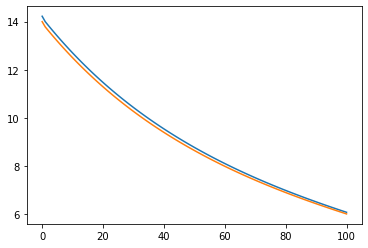

In [242]:
plt.plot(ems_dict[0][0][:,-1])
plt.plot((ems_dict[0][1][:,-1] + ems_dict[0][2][:,-1] )/2)

In [243]:
ξp = 5
dmg_weight = np.array([1/3,1/3,1/3])
ϕ_bound = list()
for i in range(len(ℓ_list)):
    ϕ_weight_i =  np.array([ np.exp(- 1/ξp*v_dict[γ3][i])for γ3 in γ3_list] ) 
    ϕ_weight = np.average(ϕ_weight_i, axis=0, weights=dmg_weight)
    ϕ_bound_i = -ξp*np.log(ϕ_weight)
    ϕ_bound.append(ϕ_bound_i)
ϕ_bound = np.array(ϕ_bound)

In [244]:
v_dict[0].shape, ϕ_bound.shape

((5, 101, 50), (5, 101, 50))

In [245]:
(y_mat_cap, b_mat) = np.meshgrid(y_grid[:numy_bar+1], b_grid, indexing = 'ij')
# stateSpace = np.hstack([y_mat_cap.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
num_y = len(y_grid[:numy_bar+1])
num_b = len(b_grid)
# ℓ_list = np.array([ℓ, ℓ+ℓ_step])
πa_o = np.ones((len(θ_list), len(y_grid[:numy_bar+1]), len(b_grid)))/len(θ_list)
dΛ = γ1 + γ2*y_mat_cap
ddΛ = γ2
vjp_list = list()
emsjp_list = list()
ϵ = 5
tol = 1e-6
max_iter = 5_000

for i in range(len(ℓ_list)):
    episode = 0
    lhs_error = 1
    πa = πa_o
    ems = - η/(b_mat*(η-1)/δ*dΛ*(πa.T@θ_list).T)
    ems_old = ems
    v0 =  - η*(y_mat_cap + y_mat_cap**2)
    while lhs_error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls
        temp = v0_dy + b_mat*(η-1)/δ*dΛ
        weight = np.array([-1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        print(np.min(ems))

        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2 + b_mat*(η - 1)/δ*ddΛ*σy**2
        b = (πa.T@θ_list).T*temp  - ℓ_list[i]
        c = η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 0] = 1e-15
        ems = ems_new*1. + ems_old*0.
        # HJB coefficient
        A =  np.zeros(y_mat_cap.shape)
        B_y =  ems*(πa.T@θ_list).T
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat_cap.shape)
        D = b_mat*η*np.log(ems) + b_mat*(η-1)/δ*(dΛ*ems*(πa.T@θ_list).T + 1/2*ddΛ*ems**2*σy**2)\
        - ℓ_list[i]*ems - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
        # PDE solver
        phi_mat = false_transient_one_iteration_python(A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, 
                                                   hy, hb, 
                                                   bc=(np.zeros(num_b), ϕ_bound[i][numy_bar], np.zeros(num_y), np.zeros(num_y)), 
                                                   impose_bc=(False, True, False, False))
        rhs = A*phi_mat + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((phi_mat-v0_old)/ϵ))
        v0 = phi_mat
        ems_old = ems
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))

    vjp_list.append(v0)
    emsjp_list.append(ems)

vjp_list = np.array(vjp_list)
emsjp_list = np.array(emsjp_list)

19.77823832509321
Episode: 1	 lhs error: 0.087470776080	 rhs error: 0.122631114814
7.176555552054027e-09
Episode: 2	 lhs error: 0.078387446714	 rhs error: 0.098917260400
1.0827380377150496e-08
Episode: 3	 lhs error: 0.068380353478	 rhs error: 0.080031564220
1.0827318428237157e-08
Episode: 4	 lhs error: 0.061018623109	 rhs error: 0.069590839405
1.0822986749083876e-08
Episode: 5	 lhs error: 0.054809156009	 rhs error: 0.061542208201
1.0800111304028973e-08
Episode: 6	 lhs error: 0.049516960432	 rhs error: 0.055123990284
1.0797281244952347e-08
Episode: 7	 lhs error: 0.044881994309	 rhs error: 0.049708000251
1.0790237298661295e-08
Episode: 8	 lhs error: 0.040763239705	 rhs error: 0.045014598621
1.0787253430083726e-08
Episode: 9	 lhs error: 0.037058196035	 rhs error: 0.040859659874
1.0784235998076343e-08
Episode: 10	 lhs error: 0.033698983392	 rhs error: 0.037132525801
1.0783298304875262e-08
Episode: 11	 lhs error: 0.030636543192	 rhs error: 0.033758354346
1.078263061758851e-08
Episode: 12	 l

Episode: 96	 lhs error: 0.000014361179	 rhs error: 0.002737469937
1.0784079714873276e-08
Episode: 97	 lhs error: 0.000013628436	 rhs error: 0.002737316596
1.0784332955240863e-08
Episode: 98	 lhs error: 0.000006627871	 rhs error: 0.002737110035
1.0781030031280052e-08
Episode: 99	 lhs error: 0.000011864601	 rhs error: 0.002737688166
1.0784225674411677e-08
Episode: 100	 lhs error: 0.000011360878	 rhs error: 0.002736692782
1.0784241022431841e-08
Episode: 101	 lhs error: 0.000012254027	 rhs error: 0.002736478908
1.0784271817622457e-08
Episode: 102	 lhs error: 0.000015788837	 rhs error: 0.002737638428
1.078704123873525e-08
Episode: 103	 lhs error: 0.000014389613	 rhs error: 0.002737662957
1.078653681946143e-08
Episode: 104	 lhs error: 0.000012159133	 rhs error: 0.002737292542
1.078451713358347e-08
Episode: 105	 lhs error: 0.000009341084	 rhs error: 0.002737170515
1.0785081848362315e-08
Episode: 106	 lhs error: 0.000011295359	 rhs error: 0.002737615873
1.078442677941347e-08
Episode: 107	 lhs 

Episode: 188	 lhs error: 0.000013264609	 rhs error: 0.002736811568
1.078987626343072e-08
Episode: 189	 lhs error: 0.000014433975	 rhs error: 0.002737037934
1.0788246741040217e-08
Episode: 190	 lhs error: 0.000004839841	 rhs error: 0.002736656321
1.0790137858971956e-08
Episode: 191	 lhs error: 0.000003305557	 rhs error: 0.002736282268
1.0788359886183428e-08
Episode: 192	 lhs error: 0.000003291447	 rhs error: 0.002735626957
1.0782945948249398e-08
Episode: 193	 lhs error: 0.000003329688	 rhs error: 0.002736240673
1.0789796792671862e-08
Episode: 194	 lhs error: 0.000016668729	 rhs error: 0.002736112861
1.078843815158052e-08
Episode: 195	 lhs error: 0.000005889945	 rhs error: 0.002736884401
1.0789364170255239e-08
Episode: 196	 lhs error: 0.000011314708	 rhs error: 0.002737115419
1.0788499068631547e-08
Episode: 197	 lhs error: 0.000005799707	 rhs error: 0.002737665770
1.0788511347316018e-08
Episode: 198	 lhs error: 0.000007525897	 rhs error: 0.002737315213
1.0788641006769222e-08
Episode: 199

Episode: 280	 lhs error: 0.000013519804	 rhs error: 0.002737303697
1.079198876997086e-08
Episode: 281	 lhs error: 0.000012002758	 rhs error: 0.002737608002
1.0792421817950389e-08
Episode: 282	 lhs error: 0.000014730673	 rhs error: 0.002738250619
1.079316502729103e-08
Episode: 283	 lhs error: 0.000013632609	 rhs error: 0.002737664222
1.079311014949005e-08
Episode: 284	 lhs error: 0.000009421587	 rhs error: 0.002737149412
1.0795828176614493e-08
Episode: 285	 lhs error: 0.000009312076	 rhs error: 0.002736817806
1.0792292573299383e-08
Episode: 286	 lhs error: 0.000009429133	 rhs error: 0.002736917685
1.0792086224933255e-08
Episode: 287	 lhs error: 0.000009959258	 rhs error: 0.002736874656
1.0792047579143127e-08
Episode: 288	 lhs error: 0.000009881076	 rhs error: 0.002737128129
1.0792108247884751e-08
Episode: 289	 lhs error: 0.000008396409	 rhs error: 0.002736670033
1.0791641755940936e-08
Episode: 290	 lhs error: 0.000012522495	 rhs error: 0.002736343938
1.0792841983493914e-08
Episode: 291	

Episode: 372	 lhs error: 0.000014564449	 rhs error: 0.002735735435
1.079619169722947e-08
Episode: 373	 lhs error: 0.000006785729	 rhs error: 0.002736787416
1.0795577515170852e-08
Episode: 374	 lhs error: 0.000014170322	 rhs error: 0.002736864535
1.07948896127042e-08
Episode: 375	 lhs error: 0.000017914580	 rhs error: 0.002735864917
1.0797059190426972e-08
Episode: 376	 lhs error: 0.000011504373	 rhs error: 0.002737054873
1.079441553645448e-08
Episode: 377	 lhs error: 0.000007373117	 rhs error: 0.002736382687
1.079187365686518e-08
Episode: 378	 lhs error: 0.000010395530	 rhs error: 0.002736584023
1.0796820519500417e-08
Episode: 379	 lhs error: 0.000013087696	 rhs error: 0.002736379303
1.0795924065189351e-08
Episode: 380	 lhs error: 0.000018563069	 rhs error: 0.002735601551
1.0795427403978387e-08
Episode: 381	 lhs error: 0.000005875698	 rhs error: 0.002736939467
1.0795772207550475e-08
Episode: 382	 lhs error: 0.000009574039	 rhs error: 0.002736663153
1.079605867711545e-08
Episode: 383	 lh

Episode: 464	 lhs error: 0.000008370197	 rhs error: 0.002737333515
1.0800691428424218e-08
Episode: 465	 lhs error: 0.000006770764	 rhs error: 0.002737191058
1.079883775895749e-08
Episode: 466	 lhs error: 0.000008037356	 rhs error: 0.002737570927
1.079915650560061e-08
Episode: 467	 lhs error: 0.000010006019	 rhs error: 0.002737706714
1.0799193801125351e-08
Episode: 468	 lhs error: 0.000017308239	 rhs error: 0.002738074553
1.0797490807110555e-08
Episode: 469	 lhs error: 0.000012114292	 rhs error: 0.002736844998
1.079449612041792e-08
Episode: 470	 lhs error: 0.000010062407	 rhs error: 0.002737336560
1.0799872167342717e-08
Episode: 471	 lhs error: 0.000013406779	 rhs error: 0.002737330592
1.080127606127091e-08
Episode: 472	 lhs error: 0.000007843284	 rhs error: 0.002737374833
1.0800211149995971e-08
Episode: 473	 lhs error: 0.000012582778	 rhs error: 0.002737628510
1.0799509337472944e-08
Episode: 474	 lhs error: 0.000013086029	 rhs error: 0.002736840577
1.0799528533814509e-08
Episode: 475	 

Episode: 556	 lhs error: 0.000013590970	 rhs error: 0.002737257999
1.0806555991992603e-08
Episode: 557	 lhs error: 0.000011239705	 rhs error: 0.002737755209
1.0803107636648927e-08
Episode: 558	 lhs error: 0.000005485885	 rhs error: 0.002737229132
1.0803452123891479e-08
Episode: 559	 lhs error: 0.000014409817	 rhs error: 0.002737399115
1.0804001534885609e-08
Episode: 560	 lhs error: 0.000013208565	 rhs error: 0.002736561277
1.0803245624252042e-08
Episode: 561	 lhs error: 0.000007348574	 rhs error: 0.002736920462
1.0807225284630408e-08
Episode: 562	 lhs error: 0.000006048040	 rhs error: 0.002736676003
1.0802554470628993e-08
Episode: 563	 lhs error: 0.000009902393	 rhs error: 0.002736675865
1.0803566655105852e-08
Episode: 564	 lhs error: 0.000015528633	 rhs error: 0.002735955434
1.0803454589624717e-08
Episode: 565	 lhs error: 0.000008861830	 rhs error: 0.002736658117
1.0803492379572754e-08
Episode: 566	 lhs error: 0.000004205920	 rhs error: 0.002736524771
1.0804156993647791e-08
Episode: 5

Episode: 648	 lhs error: 0.000009328257	 rhs error: 0.002737706598
1.0806342582570091e-08
Episode: 649	 lhs error: 0.000011143195	 rhs error: 0.002737613307
1.0806960722942421e-08
Episode: 650	 lhs error: 0.000015324179	 rhs error: 0.002737621598
1.0806554570508688e-08
Episode: 651	 lhs error: 0.000011360432	 rhs error: 0.002737695256
1.0810441392552377e-08
Episode: 652	 lhs error: 0.000011274995	 rhs error: 0.002736766177
1.0807256215386953e-08
Episode: 653	 lhs error: 0.000008602837	 rhs error: 0.002737046081
1.0807674811371651e-08
Episode: 654	 lhs error: 0.000011368963	 rhs error: 0.002737243727
1.0807181750687681e-08
Episode: 655	 lhs error: 0.000017750928	 rhs error: 0.002736292877
1.0807214677921212e-08
Episode: 656	 lhs error: 0.000009169724	 rhs error: 0.002737251640
1.0807213524939964e-08
Episode: 657	 lhs error: 0.000010343788	 rhs error: 0.002737244262
1.0807173114488829e-08
Episode: 658	 lhs error: 0.000009031843	 rhs error: 0.002736562136
1.0807224406602831e-08
Episode: 6

Episode: 740	 lhs error: 0.000011076121	 rhs error: 0.002737358125
1.0806414813582495e-08
Episode: 741	 lhs error: 0.000008927737	 rhs error: 0.002737472129
1.0811085192208975e-08
Episode: 742	 lhs error: 0.000009786868	 rhs error: 0.002736370002
1.081067218857974e-08
Episode: 743	 lhs error: 0.000015851450	 rhs error: 0.002735967780
1.0811026616790696e-08
Episode: 744	 lhs error: 0.000007009280	 rhs error: 0.002737610437
1.0815112979061393e-08
Episode: 745	 lhs error: 0.000011523723	 rhs error: 0.002736861084
1.0811139610010078e-08
Episode: 746	 lhs error: 0.000008426760	 rhs error: 0.002736599181
1.0810192804523418e-08
Episode: 747	 lhs error: 0.000013393078	 rhs error: 0.002736372463
1.0811118028477944e-08
Episode: 748	 lhs error: 0.000006851913	 rhs error: 0.002736224135
1.0810117142648107e-08
Episode: 749	 lhs error: 0.000004511902	 rhs error: 0.002736844433
1.0810945699895875e-08
Episode: 750	 lhs error: 0.000009078547	 rhs error: 0.002736807451
1.0810686480234623e-08
Episode: 75

Episode: 832	 lhs error: 0.000008186147	 rhs error: 0.002737405419
1.0814028954887799e-08
Episode: 833	 lhs error: 0.000009958145	 rhs error: 0.002737260007
1.081354911394868e-08
Episode: 834	 lhs error: 0.000011194533	 rhs error: 0.002736605725
1.0814572029804433e-08
Episode: 835	 lhs error: 0.000013048441	 rhs error: 0.002736240446
1.0813865493751354e-08
Episode: 836	 lhs error: 0.000010966921	 rhs error: 0.002737318221
1.0814429206835812e-08
Episode: 837	 lhs error: 0.000015144468	 rhs error: 0.002737134996
1.0814315375948279e-08
Episode: 838	 lhs error: 0.000008077735	 rhs error: 0.002737295641
1.08143914210484e-08
Episode: 839	 lhs error: 0.000003395747	 rhs error: 0.002737186667
1.0814385050289988e-08
Episode: 840	 lhs error: 0.000009284138	 rhs error: 0.002737207833
1.0814401701114587e-08
Episode: 841	 lhs error: 0.000005168027	 rhs error: 0.002736357756
1.0814431331519704e-08
Episode: 842	 lhs error: 0.000004562646	 rhs error: 0.002736862168
1.0812331899983426e-08
Episode: 843	

Episode: 924	 lhs error: 0.000004508507	 rhs error: 0.002736411753
1.0817413150182673e-08
Episode: 925	 lhs error: 0.000010108825	 rhs error: 0.002736773176
1.0814019694825464e-08
Episode: 926	 lhs error: 0.000006635785	 rhs error: 0.002736661153
1.0820904021836917e-08
Episode: 927	 lhs error: 0.000014744182	 rhs error: 0.002736282772
1.0818039821870848e-08
Episode: 928	 lhs error: 0.000014446092	 rhs error: 0.002735694604
1.081530978085121e-08
Episode: 929	 lhs error: 0.000008873723	 rhs error: 0.002737062810
1.081770205112523e-08
Episode: 930	 lhs error: 0.000006301612	 rhs error: 0.002736826040
1.0817401836316163e-08
Episode: 931	 lhs error: 0.000006892272	 rhs error: 0.002736670478
1.0816709444656206e-08
Episode: 932	 lhs error: 0.000015483931	 rhs error: 0.002736137956
1.0818800565674412e-08
Episode: 933	 lhs error: 0.000010661490	 rhs error: 0.002737092716
1.0817840783209319e-08
Episode: 934	 lhs error: 0.000006958945	 rhs error: 0.002737390329
1.0817971546393888e-08
Episode: 935

Episode: 1016	 lhs error: 0.000011872120	 rhs error: 0.002737153383
1.0823674551790376e-08
Episode: 1017	 lhs error: 0.000017695574	 rhs error: 0.002736592869
1.0822122767197083e-08
Episode: 1018	 lhs error: 0.000012236504	 rhs error: 0.002738133696
1.0821684187767148e-08
Episode: 1019	 lhs error: 0.000007906263	 rhs error: 0.002736546541
1.0822194807986216e-08
Episode: 1020	 lhs error: 0.000010827413	 rhs error: 0.002736884168
1.0820889740603928e-08
Episode: 1021	 lhs error: 0.000009270962	 rhs error: 0.002736816656
1.0822281364670345e-08
Episode: 1022	 lhs error: 0.000006669911	 rhs error: 0.002737218175
1.0822321298465548e-08
Episode: 1023	 lhs error: 0.000012874373	 rhs error: 0.002736994538
1.0822346442265892e-08
Episode: 1024	 lhs error: 0.000012966739	 rhs error: 0.002736968073
1.082249073557529e-08
Episode: 1025	 lhs error: 0.000011135978	 rhs error: 0.002737797475
1.0822415394745794e-08
Episode: 1026	 lhs error: 0.000016454847	 rhs error: 0.002737805314
1.0822445388019826e-08


Episode: 1108	 lhs error: 0.000010001042	 rhs error: 0.002737498479
1.0827972887024126e-08
Episode: 1109	 lhs error: 0.000011648749	 rhs error: 0.002736761523
1.0828163689611614e-08
Episode: 1110	 lhs error: 0.000009608367	 rhs error: 0.002737183234
1.0825872782753952e-08
Episode: 1111	 lhs error: 0.000011985309	 rhs error: 0.002736686571
1.0829355523339136e-08
Episode: 1112	 lhs error: 0.000010988404	 rhs error: 0.002737263042
1.0824707902427964e-08
Episode: 1113	 lhs error: 0.000012088781	 rhs error: 0.002737137782
1.0824933702018036e-08
Episode: 1114	 lhs error: 0.000016469867	 rhs error: 0.002736847932
1.0826142208972484e-08
Episode: 1115	 lhs error: 0.000012825223	 rhs error: 0.002737153373
1.0826297149526686e-08
Episode: 1116	 lhs error: 0.000013789733	 rhs error: 0.002736892956
1.0826756930584313e-08
Episode: 1117	 lhs error: 0.000011886347	 rhs error: 0.002737854045
1.082571586424907e-08
Episode: 1118	 lhs error: 0.000015309081	 rhs error: 0.002737949556
1.0828600984546578e-08


Episode: 1200	 lhs error: 0.000012945034	 rhs error: 0.002736210326
1.0829779508147444e-08
Episode: 1201	 lhs error: 0.000009817545	 rhs error: 0.002736461464
1.0829797140893293e-08
Episode: 1202	 lhs error: 0.000011873648	 rhs error: 0.002735640402
1.0825140132580242e-08
Episode: 1203	 lhs error: 0.000010187222	 rhs error: 0.002736503567
1.0829972780588139e-08
Episode: 1204	 lhs error: 0.000013243642	 rhs error: 0.002736485833
1.0829148893703859e-08
Episode: 1205	 lhs error: 0.000006561136	 rhs error: 0.002737431212
1.0830530023560607e-08
Episode: 1206	 lhs error: 0.000011162090	 rhs error: 0.002737689305
1.0829958761854048e-08
Episode: 1207	 lhs error: 0.000009708134	 rhs error: 0.002737446875
1.0834236826112145e-08
Episode: 1208	 lhs error: 0.000014877780	 rhs error: 0.002737677601
1.082820956520064e-08
Episode: 1209	 lhs error: 0.000004437647	 rhs error: 0.002737247473
1.0830803486399352e-08
Episode: 1210	 lhs error: 0.000009417590	 rhs error: 0.002737202981
1.083084493471657e-08
E

Episode: 1292	 lhs error: 0.000007506262	 rhs error: 0.002736292530
1.0833624719162275e-08
Episode: 1293	 lhs error: 0.000010892520	 rhs error: 0.002736834179
1.0833656156783336e-08
Episode: 1294	 lhs error: 0.000010549828	 rhs error: 0.002736873943
1.0834169276522092e-08
Episode: 1295	 lhs error: 0.000015874921	 rhs error: 0.002735948867
1.083376937283337e-08
Episode: 1296	 lhs error: 0.000006819574	 rhs error: 0.002736840290
1.083375988123966e-08
Episode: 1297	 lhs error: 0.000006126963	 rhs error: 0.002736102624
1.0833814952340335e-08
Episode: 1298	 lhs error: 0.000010244712	 rhs error: 0.002736456044
1.0833832681403995e-08
Episode: 1299	 lhs error: 0.000007032064	 rhs error: 0.002736948693
1.0834565173555239e-08
Episode: 1300	 lhs error: 0.000006018075	 rhs error: 0.002737314257
1.083366198441067e-08
Episode: 1301	 lhs error: 0.000009524851	 rhs error: 0.002737548298
1.0833961496954886e-08
Episode: 1302	 lhs error: 0.000011295823	 rhs error: 0.002737408862
1.0833932111091568e-08
Ep

Episode: 1384	 lhs error: 0.000011669605	 rhs error: 0.002736864950
1.0836812957423455e-08
Episode: 1385	 lhs error: 0.000013686587	 rhs error: 0.002736421016
1.0836856805744154e-08
Episode: 1386	 lhs error: 0.000010162209	 rhs error: 0.002736901173
1.083747229640769e-08
Episode: 1387	 lhs error: 0.000006443494	 rhs error: 0.002736777102
1.0837022122763668e-08
Episode: 1388	 lhs error: 0.000008528588	 rhs error: 0.002736385143
1.0835709508168743e-08
Episode: 1389	 lhs error: 0.000016807546	 rhs error: 0.002736398672
1.0837016313174747e-08
Episode: 1390	 lhs error: 0.000012557289	 rhs error: 0.002737234936
1.0838188775800866e-08
Episode: 1391	 lhs error: 0.000011022729	 rhs error: 0.002736882340
1.0837131062530598e-08
Episode: 1392	 lhs error: 0.000009304459	 rhs error: 0.002737377305
1.0837228151195288e-08
Episode: 1393	 lhs error: 0.000011579802	 rhs error: 0.002737119003
1.0837296719189995e-08
Episode: 1394	 lhs error: 0.000008423501	 rhs error: 0.002737327152
1.0835595457079749e-08


Episode: 1476	 lhs error: 0.000014535935	 rhs error: 0.002737061577
1.084024459275688e-08
Episode: 1477	 lhs error: 0.000014667345	 rhs error: 0.002737120263
1.0838022980065435e-08
Episode: 1478	 lhs error: 0.000013155901	 rhs error: 0.002736950470
1.0840354869738112e-08
Episode: 1479	 lhs error: 0.000010811906	 rhs error: 0.002736378928
1.0842720714346007e-08
Episode: 1480	 lhs error: 0.000009917194	 rhs error: 0.002737053867
1.0840690309137351e-08
Episode: 1481	 lhs error: 0.000010082170	 rhs error: 0.002737180546
1.0842013494540828e-08
Episode: 1482	 lhs error: 0.000007038142	 rhs error: 0.002736917334
1.083962353970252e-08
Episode: 1483	 lhs error: 0.000011395011	 rhs error: 0.002737143772
1.084125079400984e-08
Episode: 1484	 lhs error: 0.000013380647	 rhs error: 0.002737397182
1.0841266966335364e-08
Episode: 1485	 lhs error: 0.000009064318	 rhs error: 0.002736146186
1.08412836889477e-08
Episode: 1486	 lhs error: 0.000012155467	 rhs error: 0.002736354014
1.0841090528572852e-08
Epis

Episode: 1568	 lhs error: 0.000011238016	 rhs error: 0.002736680862
1.0844319804279284e-08
Episode: 1569	 lhs error: 0.000011845163	 rhs error: 0.002736325114
1.0847345633364729e-08
Episode: 1570	 lhs error: 0.000009719727	 rhs error: 0.002737353757
1.0844588210087388e-08
Episode: 1571	 lhs error: 0.000004372578	 rhs error: 0.002737377582
1.0844470056621319e-08
Episode: 1572	 lhs error: 0.000009357691	 rhs error: 0.002737787343
1.0844769420033525e-08
Episode: 1573	 lhs error: 0.000008000329	 rhs error: 0.002737619613
1.0844495705632771e-08
Episode: 1574	 lhs error: 0.000012066466	 rhs error: 0.002737743437
1.0844503987839614e-08
Episode: 1575	 lhs error: 0.000012392197	 rhs error: 0.002736889657
1.084360338667208e-08
Episode: 1576	 lhs error: 0.000012726746	 rhs error: 0.002736282362
1.0845554667551576e-08
Episode: 1577	 lhs error: 0.000013846531	 rhs error: 0.002738075332
1.0847493057375662e-08
Episode: 1578	 lhs error: 0.000009803827	 rhs error: 0.002737205328
1.0843125247550901e-08


Episode: 1660	 lhs error: 0.000011753949	 rhs error: 0.002736601412
1.0848306648215326e-08
Episode: 1661	 lhs error: 0.000011095134	 rhs error: 0.002737317952
1.0848088783738325e-08
Episode: 1662	 lhs error: 0.000004571933	 rhs error: 0.002737248148
1.084909489063859e-08
Episode: 1663	 lhs error: 0.000015624558	 rhs error: 0.002737231463
1.08481430458751e-08
Episode: 1664	 lhs error: 0.000012365332	 rhs error: 0.002736225185
1.0850552033719917e-08
Episode: 1665	 lhs error: 0.000014151834	 rhs error: 0.002736995375
1.0848227624012238e-08
Episode: 1666	 lhs error: 0.000008407281	 rhs error: 0.002737251540
1.084892260612934e-08
Episode: 1667	 lhs error: 0.000007593144	 rhs error: 0.002736941968
1.084607493283317e-08
Episode: 1668	 lhs error: 0.000012669390	 rhs error: 0.002736562131
1.0848404012836575e-08
Episode: 1669	 lhs error: 0.000010600731	 rhs error: 0.002736637393
1.0848445918565136e-08
Episode: 1670	 lhs error: 0.000009760600	 rhs error: 0.002737470561
1.084844403502136e-08
Episo

Episode: 1752	 lhs error: 0.000009691266	 rhs error: 0.002737312195
1.0852349350531898e-08
Episode: 1753	 lhs error: 0.000008446942	 rhs error: 0.002736228886
1.085514782819515e-08
Episode: 1754	 lhs error: 0.000015899792	 rhs error: 0.002736258116
1.0849944377094704e-08
Episode: 1755	 lhs error: 0.000004786485	 rhs error: 0.002736875567
1.0851006029908433e-08
Episode: 1756	 lhs error: 0.000011764233	 rhs error: 0.002737019695
1.0852092515586877e-08
Episode: 1757	 lhs error: 0.000013264541	 rhs error: 0.002737560262
1.085214197675446e-08
Episode: 1758	 lhs error: 0.000004170912	 rhs error: 0.002736809127
1.0852121777431018e-08
Episode: 1759	 lhs error: 0.000012475351	 rhs error: 0.002736878362
1.0853909905223012e-08
Episode: 1760	 lhs error: 0.000003355379	 rhs error: 0.002737227055
1.0851560844430666e-08
Episode: 1761	 lhs error: 0.000011493907	 rhs error: 0.002736671791
1.0852046037086575e-08
Episode: 1762	 lhs error: 0.000009732241	 rhs error: 0.002736615187
1.0851946601097076e-08
E

Episode: 1843	 lhs error: 0.000012236767	 rhs error: 0.002736793495
1.085413637910552e-08
Episode: 1844	 lhs error: 0.000009553406	 rhs error: 0.002736462238
1.0855937744653674e-08
Episode: 1845	 lhs error: 0.000014075436	 rhs error: 0.002736279833
1.0855969848123947e-08
Episode: 1846	 lhs error: 0.000015452538	 rhs error: 0.002737519696
1.085704284613763e-08
Episode: 1847	 lhs error: 0.000014945307	 rhs error: 0.002737398341
1.0856306790362922e-08
Episode: 1848	 lhs error: 0.000009031263	 rhs error: 0.002736925765
1.0856156217056386e-08
Episode: 1849	 lhs error: 0.000013259857	 rhs error: 0.002736692973
1.0856209818981802e-08
Episode: 1850	 lhs error: 0.000014919843	 rhs error: 0.002737093823
1.0856242015313991e-08
Episode: 1851	 lhs error: 0.000016213662	 rhs error: 0.002736411511
1.085630718634066e-08
Episode: 1852	 lhs error: 0.000011646085	 rhs error: 0.002737293922
1.0856960188962796e-08
Episode: 1853	 lhs error: 0.000010830931	 rhs error: 0.002736995985
1.0856084173014647e-08
Ep

Episode: 1935	 lhs error: 0.000006565418	 rhs error: 0.002736271291
1.0860270828146924e-08
Episode: 1936	 lhs error: 0.000006336670	 rhs error: 0.002736699338
1.0859781482806959e-08
Episode: 1937	 lhs error: 0.000012452090	 rhs error: 0.002736184348
1.0859231249459034e-08
Episode: 1938	 lhs error: 0.000015816053	 rhs error: 0.002736672187
1.0860785073843189e-08
Episode: 1939	 lhs error: 0.000009131677	 rhs error: 0.002736879404
1.0859871394093925e-08
Episode: 1940	 lhs error: 0.000010497158	 rhs error: 0.002737075614
1.0859063728012558e-08
Episode: 1941	 lhs error: 0.000012068676	 rhs error: 0.002736368511
1.0861859163133463e-08
Episode: 1942	 lhs error: 0.000009707399	 rhs error: 0.002736957047
1.0862373700019326e-08
Episode: 1943	 lhs error: 0.000006230555	 rhs error: 0.002736565248
1.0858972600020361e-08
Episode: 1944	 lhs error: 0.000012809061	 rhs error: 0.002736804188
1.0859463636336245e-08
Episode: 1945	 lhs error: 0.000013510289	 rhs error: 0.002737274869
1.0859511497045239e-08

Episode: 2027	 lhs error: 0.000008462486	 rhs error: 0.002736541962
1.0866250086698421e-08
Episode: 2028	 lhs error: 0.000009019672	 rhs error: 0.002736568473
1.0863149982608426e-08
Episode: 2029	 lhs error: 0.000005127243	 rhs error: 0.002736839979
1.0867091121270051e-08
Episode: 2030	 lhs error: 0.000005335864	 rhs error: 0.002736515276
1.086331074294305e-08
Episode: 2031	 lhs error: 0.000006433950	 rhs error: 0.002736876599
1.0863635504021539e-08
Episode: 2032	 lhs error: 0.000005116114	 rhs error: 0.002737077537
1.0864390953150898e-08
Episode: 2033	 lhs error: 0.000005714428	 rhs error: 0.002737325958
1.0863865729799217e-08
Episode: 2034	 lhs error: 0.000012451105	 rhs error: 0.002737576690
1.086369840354979e-08
Episode: 2035	 lhs error: 0.000012408612	 rhs error: 0.002737667415
1.0863723000532769e-08
Episode: 2036	 lhs error: 0.000012450326	 rhs error: 0.002736468387
1.0863744512825042e-08
Episode: 2037	 lhs error: 0.000013754126	 rhs error: 0.002737304149
1.0863782898975854e-08
E

Episode: 2119	 lhs error: 0.000013532910	 rhs error: 0.002737340476
1.086962536134045e-08
Episode: 2120	 lhs error: 0.000008538464	 rhs error: 0.002737061769
1.0866300269375445e-08
Episode: 2121	 lhs error: 0.000014177639	 rhs error: 0.002737199273
1.0867303743683759e-08
Episode: 2122	 lhs error: 0.000012820525	 rhs error: 0.002737045817
1.0867374753084917e-08
Episode: 2123	 lhs error: 0.000012966634	 rhs error: 0.002737256778
1.086741855685846e-08
Episode: 2124	 lhs error: 0.000012450315	 rhs error: 0.002737228608
1.0867240830521666e-08
Episode: 2125	 lhs error: 0.000008019222	 rhs error: 0.002737526947
1.0868204723996793e-08
Episode: 2126	 lhs error: 0.000011194283	 rhs error: 0.002737603583
1.086755507595039e-08
Episode: 2127	 lhs error: 0.000014978587	 rhs error: 0.002737788518
1.0867647056816672e-08
Episode: 2128	 lhs error: 0.000016762298	 rhs error: 0.002737394092
1.086709144415901e-08
Episode: 2129	 lhs error: 0.000011997813	 rhs error: 0.002737242595
1.0870543496943803e-08
Epi

Episode: 2211	 lhs error: 0.000017298276	 rhs error: 0.002735731209
1.087109787255389e-08
Episode: 2212	 lhs error: 0.000010736694	 rhs error: 0.002736946774
1.0871059416295856e-08
Episode: 2213	 lhs error: 0.000009949556	 rhs error: 0.002736459932
1.0874440064094775e-08
Episode: 2214	 lhs error: 0.000010885745	 rhs error: 0.002736100883
1.0868377528367433e-08
Episode: 2215	 lhs error: 0.000012539655	 rhs error: 0.002736971841
1.0870951808715241e-08
Episode: 2216	 lhs error: 0.000014224508	 rhs error: 0.002736760871
1.0870867525738593e-08
Episode: 2217	 lhs error: 0.000011429218	 rhs error: 0.002736640541
1.0871041895100858e-08
Episode: 2218	 lhs error: 0.000011568831	 rhs error: 0.002737418809
1.0871395002807777e-08
Episode: 2219	 lhs error: 0.000010265684	 rhs error: 0.002736322351
1.0871441294174784e-08
Episode: 2220	 lhs error: 0.000011047520	 rhs error: 0.002736931551
1.0871360833607105e-08
Episode: 2221	 lhs error: 0.000005018129	 rhs error: 0.002737003082
1.0871583426669252e-08


Episode: 2303	 lhs error: 0.000006529445	 rhs error: 0.002737545746
1.0875401134320998e-08
Episode: 2304	 lhs error: 0.000006116721	 rhs error: 0.002737364936
1.0872937195667738e-08
Episode: 2305	 lhs error: 0.000015771964	 rhs error: 0.002737743540
1.0874840349260032e-08
Episode: 2306	 lhs error: 0.000011969642	 rhs error: 0.002736963077
1.0875678038241255e-08
Episode: 2307	 lhs error: 0.000008109010	 rhs error: 0.002736068524
1.0874872605833204e-08
Episode: 2308	 lhs error: 0.000004756310	 rhs error: 0.002736615130
1.0875427171883403e-08
Episode: 2309	 lhs error: 0.000012086062	 rhs error: 0.002736290435
1.0874536154710708e-08
Episode: 2310	 lhs error: 0.000016769529	 rhs error: 0.002735801845
1.0875050063260754e-08
Episode: 2311	 lhs error: 0.000011890831	 rhs error: 0.002737139742
1.0875115748944643e-08
Episode: 2312	 lhs error: 0.000005412696	 rhs error: 0.002736669276
1.0874487840574812e-08
Episode: 2313	 lhs error: 0.000004797651	 rhs error: 0.002736828666
1.0876031682031939e-08

Episode: 2395	 lhs error: 0.000012819711	 rhs error: 0.002736433863
1.087866738517043e-08
Episode: 2396	 lhs error: 0.000010056797	 rhs error: 0.002736515926
1.0876315981024165e-08
Episode: 2397	 lhs error: 0.000018586556	 rhs error: 0.002737218284
1.0878742393312488e-08
Episode: 2398	 lhs error: 0.000015967295	 rhs error: 0.002737702223
1.0878772802594893e-08
Episode: 2399	 lhs error: 0.000008637995	 rhs error: 0.002736892035
1.087714644546487e-08
Episode: 2400	 lhs error: 0.000011072310	 rhs error: 0.002737548378
1.0878483695694581e-08
Episode: 2401	 lhs error: 0.000010825664	 rhs error: 0.002736982212
1.0878926752906594e-08
Episode: 2402	 lhs error: 0.000014521626	 rhs error: 0.002738065667
1.0879949188569204e-08
Episode: 2403	 lhs error: 0.000010248780	 rhs error: 0.002736979501
1.0877992108834387e-08
Episode: 2404	 lhs error: 0.000012117757	 rhs error: 0.002736694187
1.0879235260534133e-08
Episode: 2405	 lhs error: 0.000009781252	 rhs error: 0.002736876084
1.087721317614347e-08
Ep

Episode: 2487	 lhs error: 0.000011601296	 rhs error: 0.002735906295
1.0880617185151731e-08
Episode: 2488	 lhs error: 0.000011007105	 rhs error: 0.002735798478
1.0882429416072615e-08
Episode: 2489	 lhs error: 0.000008037061	 rhs error: 0.002736331233
1.0882073345756154e-08
Episode: 2490	 lhs error: 0.000007846057	 rhs error: 0.002736732832
1.0882017536666165e-08
Episode: 2491	 lhs error: 0.000003882775	 rhs error: 0.002736586412
1.0882013547046116e-08
Episode: 2492	 lhs error: 0.000013894351	 rhs error: 0.002736956984
1.0881392203764386e-08
Episode: 2493	 lhs error: 0.000013020164	 rhs error: 0.002736507504
1.0882206670327697e-08
Episode: 2494	 lhs error: 0.000016473048	 rhs error: 0.002737377705
1.088226269475379e-08
Episode: 2495	 lhs error: 0.000006705838	 rhs error: 0.002737156514
1.0882798968714141e-08
Episode: 2496	 lhs error: 0.000009740290	 rhs error: 0.002736614112
1.0882379948941919e-08
Episode: 2497	 lhs error: 0.000006366294	 rhs error: 0.002737178165
1.0882375053796215e-08


Episode: 2579	 lhs error: 0.000012608762	 rhs error: 0.002736333896
1.0885731518736727e-08
Episode: 2580	 lhs error: 0.000004226100	 rhs error: 0.002735849256
1.0887357136901655e-08
Episode: 2581	 lhs error: 0.000009086978	 rhs error: 0.002738396566
1.0893868061513613e-08
Episode: 2582	 lhs error: 0.000005953018	 rhs error: 0.002736365295
1.0887437517902447e-08
Episode: 2583	 lhs error: 0.000012236645	 rhs error: 0.002736865457
1.088774741830965e-08
Episode: 2584	 lhs error: 0.000015548907	 rhs error: 0.002737677515
1.0885596514302338e-08
Episode: 2585	 lhs error: 0.000009825103	 rhs error: 0.002736790636
1.0885897609348044e-08
Episode: 2586	 lhs error: 0.000012035104	 rhs error: 0.002736498620
1.0885456417153504e-08
Episode: 2587	 lhs error: 0.000002889334	 rhs error: 0.002737317551
1.0886084560158237e-08
Episode: 2588	 lhs error: 0.000006497136	 rhs error: 0.002736016057
1.088662968107279e-08
Episode: 2589	 lhs error: 0.000015911612	 rhs error: 0.002736737402
1.0885483604593628e-08
E

Episode: 2671	 lhs error: 0.000007536555	 rhs error: 0.002736733047
1.0889787835800108e-08
Episode: 2672	 lhs error: 0.000012412359	 rhs error: 0.002736758262
1.088978489095793e-08
Episode: 2673	 lhs error: 0.000008652443	 rhs error: 0.002736797580
1.0892331718886602e-08
Episode: 2674	 lhs error: 0.000010073309	 rhs error: 0.002737016850
1.0891050346214246e-08
Episode: 2675	 lhs error: 0.000014018025	 rhs error: 0.002735908562
1.088993772276601e-08
Episode: 2676	 lhs error: 0.000012870492	 rhs error: 0.002736800927
1.0889965009193794e-08
Episode: 2677	 lhs error: 0.000012923638	 rhs error: 0.002736398137
1.088998067244574e-08
Episode: 2678	 lhs error: 0.000014522668	 rhs error: 0.002736827192
1.0890064605279296e-08
Episode: 2679	 lhs error: 0.000009804463	 rhs error: 0.002736984194
1.0895082481896445e-08
Episode: 2680	 lhs error: 0.000005315534	 rhs error: 0.002737113469
1.089034732541566e-08
Episode: 2681	 lhs error: 0.000009942113	 rhs error: 0.002737518603
1.0890206920190779e-08
Epi

Episode: 2763	 lhs error: 0.000009517081	 rhs error: 0.002737149018
1.0893453306803002e-08
Episode: 2764	 lhs error: 0.000008153988	 rhs error: 0.002738017331
1.0902172273784781e-08
Episode: 2765	 lhs error: 0.000010621484	 rhs error: 0.002736315297
1.0894897561918894e-08
Episode: 2766	 lhs error: 0.000006910361	 rhs error: 0.002737168374
1.0893498541099996e-08
Episode: 2767	 lhs error: 0.000006338447	 rhs error: 0.002737289949
1.0893918942999595e-08
Episode: 2768	 lhs error: 0.000005240636	 rhs error: 0.002737768080
1.0893485896836105e-08
Episode: 2769	 lhs error: 0.000011029837	 rhs error: 0.002737567487
1.089363996697925e-08
Episode: 2770	 lhs error: 0.000013784404	 rhs error: 0.002737670659
1.089368755642086e-08
Episode: 2771	 lhs error: 0.000008447553	 rhs error: 0.002736822524
1.0892366345810326e-08
Episode: 2772	 lhs error: 0.000003028534	 rhs error: 0.002736537675
1.0894349273101117e-08
Episode: 2773	 lhs error: 0.000014052789	 rhs error: 0.002736345185
1.0894216582110219e-08
E

Episode: 2855	 lhs error: 0.000014138098	 rhs error: 0.002736909917
1.0896856527596284e-08
Episode: 2856	 lhs error: 0.000009724682	 rhs error: 0.002735985783
1.0896871986909801e-08
Episode: 2857	 lhs error: 0.000008227081	 rhs error: 0.002736679823
1.0896918437004006e-08
Episode: 2858	 lhs error: 0.000009723945	 rhs error: 0.002736626472
1.0899435274179417e-08
Episode: 2859	 lhs error: 0.000012765734	 rhs error: 0.002736193940
1.0894707038147547e-08
Episode: 2860	 lhs error: 0.000009091676	 rhs error: 0.002736100141
1.0896987965791573e-08
Episode: 2861	 lhs error: 0.000006892921	 rhs error: 0.002736244433
1.0893688938575343e-08
Episode: 2862	 lhs error: 0.000013791561	 rhs error: 0.002736069980
1.0897451590251035e-08
Episode: 2863	 lhs error: 0.000012442423	 rhs error: 0.002736738535
1.0897126150949876e-08
Episode: 2864	 lhs error: 0.000013543658	 rhs error: 0.002736963440
1.0897151609209508e-08
Episode: 2865	 lhs error: 0.000007549055	 rhs error: 0.002735210408
1.0895037888620433e-08

Episode: 2947	 lhs error: 0.000012305153	 rhs error: 0.002736712493
1.089922227198324e-08
Episode: 2948	 lhs error: 0.000014785368	 rhs error: 0.002736688981
1.0900039468404992e-08
Episode: 2949	 lhs error: 0.000012482615	 rhs error: 0.002736799084
1.0900082190117661e-08
Episode: 2950	 lhs error: 0.000008912429	 rhs error: 0.002736731278
1.090041809317596e-08
Episode: 2951	 lhs error: 0.000006883280	 rhs error: 0.002736791800
1.0900233098402011e-08
Episode: 2952	 lhs error: 0.000010329564	 rhs error: 0.002736906932
1.0900228656019135e-08
Episode: 2953	 lhs error: 0.000012137649	 rhs error: 0.002737064300
1.090026350791481e-08
Episode: 2954	 lhs error: 0.000016314098	 rhs error: 0.002737296523
1.0900311136563881e-08
Episode: 2955	 lhs error: 0.000012584473	 rhs error: 0.002737305634
1.090099478795513e-08
Episode: 2956	 lhs error: 0.000009261727	 rhs error: 0.002737366091
1.0903431327084767e-08
Episode: 2957	 lhs error: 0.000008666858	 rhs error: 0.002737281466
1.0899616213969478e-08
Epi

Episode: 3039	 lhs error: 0.000011459502	 rhs error: 0.002737319004
1.0903643932869524e-08
Episode: 3040	 lhs error: 0.000010888927	 rhs error: 0.002737557556
1.0903676158583592e-08
Episode: 3041	 lhs error: 0.000005997771	 rhs error: 0.002737574203
1.0903710491959578e-08
Episode: 3042	 lhs error: 0.000006403299	 rhs error: 0.002737240876
1.0903709276785783e-08
Episode: 3043	 lhs error: 0.000005183493	 rhs error: 0.002736792641
1.0903837328529796e-08
Episode: 3044	 lhs error: 0.000009607870	 rhs error: 0.002737049358
1.0903747596556317e-08
Episode: 3045	 lhs error: 0.000013734654	 rhs error: 0.002736340346
1.090440505341979e-08
Episode: 3046	 lhs error: 0.000012548587	 rhs error: 0.002735928771
1.0903003344470683e-08
Episode: 3047	 lhs error: 0.000014633212	 rhs error: 0.002735968353
1.0903885468705452e-08
Episode: 3048	 lhs error: 0.000004869576	 rhs error: 0.002737040417
1.090390885471592e-08
Episode: 3049	 lhs error: 0.000010777741	 rhs error: 0.002736412029
1.090393467087069e-08
Ep

Episode: 3131	 lhs error: 0.000012332246	 rhs error: 0.002736821631
1.090765420591307e-08
Episode: 3132	 lhs error: 0.000011980064	 rhs error: 0.002736989293
1.090738736637053e-08
Episode: 3133	 lhs error: 0.000006756851	 rhs error: 0.002736971677
1.0907721190051034e-08
Episode: 3134	 lhs error: 0.000006537433	 rhs error: 0.002737276134
1.0906440795369694e-08
Episode: 3135	 lhs error: 0.000013811466	 rhs error: 0.002737822771
1.0907883615760851e-08
Episode: 3136	 lhs error: 0.000009244996	 rhs error: 0.002737093174
1.0912703266529288e-08
Episode: 3137	 lhs error: 0.000014319262	 rhs error: 0.002737191105
1.0908884827528966e-08
Episode: 3138	 lhs error: 0.000012362007	 rhs error: 0.002737759487
1.0909065324463097e-08
Episode: 3139	 lhs error: 0.000015474975	 rhs error: 0.002737064916
1.0912029379381489e-08
Episode: 3140	 lhs error: 0.000011638095	 rhs error: 0.002737508137
1.0909187898140108e-08
Episode: 3141	 lhs error: 0.000012848087	 rhs error: 0.002736771868
1.090826029632693e-08
Ep

Episode: 3223	 lhs error: 0.000016812290	 rhs error: 0.002737839541
1.0912435251847117e-08
Episode: 3224	 lhs error: 0.000002883935	 rhs error: 0.002736915003
1.0911948692852525e-08
Episode: 3225	 lhs error: 0.000009917789	 rhs error: 0.002736911634
1.0911668898557695e-08
Episode: 3226	 lhs error: 0.000008973737	 rhs error: 0.002736268238
1.0912068856985075e-08
Episode: 3227	 lhs error: 0.000010877955	 rhs error: 0.002736155765
1.0912947493612506e-08
Episode: 3228	 lhs error: 0.000014670193	 rhs error: 0.002736699806
1.0909565128871027e-08
Episode: 3229	 lhs error: 0.000011253496	 rhs error: 0.002736686166
1.0916043033821219e-08
Episode: 3230	 lhs error: 0.000013658589	 rhs error: 0.002736375966
1.0910676983918077e-08
Episode: 3231	 lhs error: 0.000015067793	 rhs error: 0.002736393587
1.0912288066577502e-08
Episode: 3232	 lhs error: 0.000008878166	 rhs error: 0.002736956377
1.0912229465639815e-08
Episode: 3233	 lhs error: 0.000011667923	 rhs error: 0.002736570348
1.0912344301311711e-08

Episode: 3315	 lhs error: 0.000009364797	 rhs error: 0.002737106872
1.0916443293954958e-08
Episode: 3316	 lhs error: 0.000015048266	 rhs error: 0.002736771237
1.0914448200438566e-08
Episode: 3317	 lhs error: 0.000006478233	 rhs error: 0.002736659428
1.0915447697879758e-08
Episode: 3318	 lhs error: 0.000006742357	 rhs error: 0.002737498379
1.0916371336147949e-08
Episode: 3319	 lhs error: 0.000002823792	 rhs error: 0.002738262477
1.091567297374597e-08
Episode: 3320	 lhs error: 0.000014204603	 rhs error: 0.002737889515
1.091577608161652e-08
Episode: 3321	 lhs error: 0.000013113452	 rhs error: 0.002737511007
1.0921119263527439e-08
Episode: 3322	 lhs error: 0.000010805236	 rhs error: 0.002736430194
1.0911806830541239e-08
Episode: 3323	 lhs error: 0.000006175692	 rhs error: 0.002736742855
1.0918196407600422e-08
Episode: 3324	 lhs error: 0.000012072106	 rhs error: 0.002735999149
1.0912542262682856e-08
Episode: 3325	 lhs error: 0.000006734208	 rhs error: 0.002735863421
1.09177592410621e-08
Epi

Episode: 3407	 lhs error: 0.000011695470	 rhs error: 0.002737035598
1.0919594093332765e-08
Episode: 3408	 lhs error: 0.000015394372	 rhs error: 0.002736900822
1.0919912813196092e-08
Episode: 3409	 lhs error: 0.000010397848	 rhs error: 0.002736997319
1.0921303413450397e-08
Episode: 3410	 lhs error: 0.000007601222	 rhs error: 0.002736914498
1.0919925366929101e-08
Episode: 3411	 lhs error: 0.000007491399	 rhs error: 0.002737157729
1.0919983655846956e-08
Episode: 3412	 lhs error: 0.000012918178	 rhs error: 0.002737311865
1.0920027206405081e-08
Episode: 3413	 lhs error: 0.000013636176	 rhs error: 0.002736940039
1.0920045912592396e-08
Episode: 3414	 lhs error: 0.000012783002	 rhs error: 0.002737141979
1.0920103904845432e-08
Episode: 3415	 lhs error: 0.000011061681	 rhs error: 0.002737124697
1.0921545456923335e-08
Episode: 3416	 lhs error: 0.000004942512	 rhs error: 0.002737342154
1.0919599357473125e-08
Episode: 3417	 lhs error: 0.000008154653	 rhs error: 0.002737620823
1.0920234482129985e-08

Episode: 3499	 lhs error: 0.000016163170	 rhs error: 0.002737473018
1.092359021877124e-08
Episode: 3500	 lhs error: 0.000007944018	 rhs error: 0.002736106029
1.0922578591628508e-08
Episode: 3501	 lhs error: 0.000011630171	 rhs error: 0.002736861544
1.0923499531371702e-08
Episode: 3502	 lhs error: 0.000012599157	 rhs error: 0.002736830765
1.0923549698327794e-08
Episode: 3503	 lhs error: 0.000009974092	 rhs error: 0.002736617687
1.0923619442288835e-08
Episode: 3504	 lhs error: 0.000008401551	 rhs error: 0.002737145077
1.09218153126079e-08
Episode: 3505	 lhs error: 0.000015809998	 rhs error: 0.002737599116
1.0923629832957195e-08
Episode: 3506	 lhs error: 0.000003108489	 rhs error: 0.002736666283
1.0923011000240463e-08
Episode: 3507	 lhs error: 0.000010840814	 rhs error: 0.002737006919
1.0926023279021367e-08
Episode: 3508	 lhs error: 0.000012302895	 rhs error: 0.002736048527
1.0923790981260013e-08
Episode: 3509	 lhs error: 0.000018440739	 rhs error: 0.002736412277
1.0926546254374711e-08
Ep

Episode: 3591	 lhs error: 0.000010891283	 rhs error: 0.002737329488
1.092878268438291e-08
Episode: 3592	 lhs error: 0.000013097991	 rhs error: 0.002737095783
1.0928895357789755e-08
Episode: 3593	 lhs error: 0.000012688168	 rhs error: 0.002736639009
1.092738589113869e-08
Episode: 3594	 lhs error: 0.000004955559	 rhs error: 0.002737245701
1.0927793490345355e-08
Episode: 3595	 lhs error: 0.000010168962	 rhs error: 0.002737522119
1.0932963573687376e-08
Episode: 3596	 lhs error: 0.000009596523	 rhs error: 0.002737131196
1.0928847194927168e-08
Episode: 3597	 lhs error: 0.000009902500	 rhs error: 0.002737444409
1.0927531260803347e-08
Episode: 3598	 lhs error: 0.000012863818	 rhs error: 0.002737464642
1.0928378963164127e-08
Episode: 3599	 lhs error: 0.000011038078	 rhs error: 0.002737745700
1.0932408796177095e-08
Episode: 3600	 lhs error: 0.000012748483	 rhs error: 0.002735816614
1.0927263497683185e-08
Episode: 3601	 lhs error: 0.000004822465	 rhs error: 0.002737099517
1.0926682455944482e-08
E

Episode: 3683	 lhs error: 0.000005280247	 rhs error: 0.002736338368
1.0930883535126279e-08
Episode: 3684	 lhs error: 0.000011329316	 rhs error: 0.002736443448
1.0930672621049277e-08
Episode: 3685	 lhs error: 0.000010148514	 rhs error: 0.002736985285
1.0930870647892681e-08
Episode: 3686	 lhs error: 0.000015811547	 rhs error: 0.002737587141
1.093082056508423e-08
Episode: 3687	 lhs error: 0.000013127484	 rhs error: 0.002736340896
1.092807248165295e-08
Episode: 3688	 lhs error: 0.000011046916	 rhs error: 0.002736201457
1.0930887161565706e-08
Episode: 3689	 lhs error: 0.000015702374	 rhs error: 0.002736034944
1.0930934739460563e-08
Episode: 3690	 lhs error: 0.000011584150	 rhs error: 0.002737079380
1.093096720440384e-08
Episode: 3691	 lhs error: 0.000013301946	 rhs error: 0.002737538027
1.0931002759499492e-08
Episode: 3692	 lhs error: 0.000015327578	 rhs error: 0.002736919192
1.0933464140018383e-08
Episode: 3693	 lhs error: 0.000006942815	 rhs error: 0.002736393861
1.0927480267847829e-08
Ep

Episode: 3775	 lhs error: 0.000012962823	 rhs error: 0.002736114587
1.0935911354324583e-08
Episode: 3776	 lhs error: 0.000009449856	 rhs error: 0.002736859066
1.0935109824881722e-08
Episode: 3777	 lhs error: 0.000012856025	 rhs error: 0.002736240942
1.093477959752693e-08
Episode: 3778	 lhs error: 0.000016941765	 rhs error: 0.002737119705
1.0934693522404748e-08
Episode: 3779	 lhs error: 0.000014729803	 rhs error: 0.002737557350
1.0936436032810463e-08
Episode: 3780	 lhs error: 0.000018646287	 rhs error: 0.002737251408
1.0935558588127795e-08
Episode: 3781	 lhs error: 0.000007324213	 rhs error: 0.002737071675
1.0934479449057483e-08
Episode: 3782	 lhs error: 0.000005443665	 rhs error: 0.002737687996
1.0935034741631558e-08
Episode: 3783	 lhs error: 0.000005393190	 rhs error: 0.002737823575
1.0935000139630931e-08
Episode: 3784	 lhs error: 0.000008016147	 rhs error: 0.002737914877
1.0935011334180992e-08
Episode: 3785	 lhs error: 0.000010798915	 rhs error: 0.002737618457
1.0935025489795607e-08


Episode: 3867	 lhs error: 0.000005052623	 rhs error: 0.002736266534
1.0933815592216348e-08
Episode: 3868	 lhs error: 0.000011782581	 rhs error: 0.002736571780
1.0938213923240283e-08
Episode: 3869	 lhs error: 0.000012529341	 rhs error: 0.002736830444
1.093804909541279e-08
Episode: 3870	 lhs error: 0.000008191450	 rhs error: 0.002736590129
1.0938483001240182e-08
Episode: 3871	 lhs error: 0.000010853450	 rhs error: 0.002736633747
1.0938133975378259e-08
Episode: 3872	 lhs error: 0.000007662715	 rhs error: 0.002736680915
1.093797557864503e-08
Episode: 3873	 lhs error: 0.000007409508	 rhs error: 0.002737186637
1.0939793580814735e-08
Episode: 3874	 lhs error: 0.000014346529	 rhs error: 0.002737727380
1.093778333341813e-08
Episode: 3875	 lhs error: 0.000016132683	 rhs error: 0.002736953791
1.0938278402071629e-08
Episode: 3876	 lhs error: 0.000013442505	 rhs error: 0.002737119667
1.0937148581374452e-08
Episode: 3877	 lhs error: 0.000006511103	 rhs error: 0.002737168855
1.0939230668427133e-08
Ep

Episode: 3959	 lhs error: 0.000005223760	 rhs error: 0.002736358326
1.0938333570520106e-08
Episode: 3960	 lhs error: 0.000010995755	 rhs error: 0.002736791838
1.0940848962264285e-08
Episode: 3961	 lhs error: 0.000010400408	 rhs error: 0.002736900581
1.094027246566372e-08
Episode: 3962	 lhs error: 0.000008851487	 rhs error: 0.002736514497
1.0943212115977255e-08
Episode: 3963	 lhs error: 0.000006017378	 rhs error: 0.002736515200
1.0941838503341402e-08
Episode: 3964	 lhs error: 0.000011852626	 rhs error: 0.002736601338
1.0941732918272177e-08
Episode: 3965	 lhs error: 0.000011570394	 rhs error: 0.002736595806
1.0941034454158482e-08
Episode: 3966	 lhs error: 0.000017339113	 rhs error: 0.002736222022
1.0941779133311351e-08
Episode: 3967	 lhs error: 0.000015420316	 rhs error: 0.002736956997
1.0942168166409622e-08
Episode: 3968	 lhs error: 0.000008439955	 rhs error: 0.002736586898
1.0938657663282824e-08
Episode: 3969	 lhs error: 0.000013445696	 rhs error: 0.002736582692
1.0943147733450168e-08


Episode: 4051	 lhs error: 0.000008416814	 rhs error: 0.002737142689
1.0945382871861871e-08
Episode: 4052	 lhs error: 0.000011390070	 rhs error: 0.002737517072
1.0945487785471138e-08
Episode: 4053	 lhs error: 0.000013660853	 rhs error: 0.002737244429
1.0945445749855156e-08
Episode: 4054	 lhs error: 0.000007964367	 rhs error: 0.002737400567
1.0945501672190061e-08
Episode: 4055	 lhs error: 0.000009406174	 rhs error: 0.002737217215
1.0946136047310854e-08
Episode: 4056	 lhs error: 0.000006121783	 rhs error: 0.002737100376
1.0945867240944257e-08
Episode: 4057	 lhs error: 0.000011783065	 rhs error: 0.002737387409
1.0945569480823119e-08
Episode: 4058	 lhs error: 0.000004407353	 rhs error: 0.002737749921
1.0944797330548627e-08
Episode: 4059	 lhs error: 0.000004599214	 rhs error: 0.002737805216
1.0945573297241871e-08
Episode: 4060	 lhs error: 0.000004961058	 rhs error: 0.002737768182
1.0945635823926547e-08
Episode: 4061	 lhs error: 0.000009121175	 rhs error: 0.002737707952
1.0945615167191761e-08

Episode: 4143	 lhs error: 0.000009194435	 rhs error: 0.002736870282
1.0949612989623477e-08
Episode: 4144	 lhs error: 0.000008744348	 rhs error: 0.002736918991
1.0952345987452175e-08
Episode: 4145	 lhs error: 0.000008832558	 rhs error: 0.002736666008
1.0947685004196461e-08
Episode: 4146	 lhs error: 0.000008871979	 rhs error: 0.002736746352
1.0947407333785925e-08
Episode: 4147	 lhs error: 0.000009253151	 rhs error: 0.002737330543
1.0949315673401813e-08
Episode: 4148	 lhs error: 0.000014523501	 rhs error: 0.002736608669
1.0948126108828123e-08
Episode: 4149	 lhs error: 0.000017445388	 rhs error: 0.002736377705
1.0948219664308327e-08
Episode: 4150	 lhs error: 0.000008440358	 rhs error: 0.002736676815
1.0949964889908647e-08
Episode: 4151	 lhs error: 0.000007786317	 rhs error: 0.002736533458
1.0948787961047204e-08
Episode: 4152	 lhs error: 0.000014040659	 rhs error: 0.002735687626
1.0948214409993548e-08
Episode: 4153	 lhs error: 0.000006413244	 rhs error: 0.002736888822
1.0949713395269189e-08

Episode: 4235	 lhs error: 0.000004368528	 rhs error: 0.002737336346
1.0952684237306733e-08
Episode: 4236	 lhs error: 0.000012061795	 rhs error: 0.002737516151
1.0952401992891177e-08
Episode: 4237	 lhs error: 0.000005836561	 rhs error: 0.002737251259
1.0952240128255983e-08
Episode: 4238	 lhs error: 0.000007593301	 rhs error: 0.002737565451
1.0953684367989757e-08
Episode: 4239	 lhs error: 0.000011501764	 rhs error: 0.002736886339
1.0952316305425482e-08
Episode: 4240	 lhs error: 0.000019715057	 rhs error: 0.002737822053
1.0952359378324787e-08
Episode: 4241	 lhs error: 0.000005016307	 rhs error: 0.002736462977
1.0952384520403961e-08
Episode: 4242	 lhs error: 0.000008061880	 rhs error: 0.002736791324
1.0953231528834694e-08
Episode: 4243	 lhs error: 0.000011408675	 rhs error: 0.002736740304
1.0953187937144649e-08
Episode: 4244	 lhs error: 0.000005913077	 rhs error: 0.002736773283
1.0955142981086598e-08
Episode: 4245	 lhs error: 0.000007500798	 rhs error: 0.002736789254
1.0952563796797496e-08

Episode: 4327	 lhs error: 0.000009323953	 rhs error: 0.002736823210
1.0955920375877392e-08
Episode: 4328	 lhs error: 0.000006464130	 rhs error: 0.002736386054
1.0956389465921978e-08
Episode: 4329	 lhs error: 0.000006208731	 rhs error: 0.002735771239
1.0955995741860377e-08
Episode: 4330	 lhs error: 0.000002624016	 rhs error: 0.002736716741
1.095775916534693e-08
Episode: 4331	 lhs error: 0.000006625991	 rhs error: 0.002736132668
1.0955590876211992e-08
Episode: 4332	 lhs error: 0.000005846052	 rhs error: 0.002736218518
1.0955510124658003e-08
Episode: 4333	 lhs error: 0.000003976339	 rhs error: 0.002735691070
1.0956205468654685e-08
Episode: 4334	 lhs error: 0.000005860392	 rhs error: 0.002735607526
1.0956240993460439e-08
Episode: 4335	 lhs error: 0.000012480865	 rhs error: 0.002735874187
1.0955840613698542e-08
Episode: 4336	 lhs error: 0.000010790389	 rhs error: 0.002736371580
1.0954235880140592e-08
Episode: 4337	 lhs error: 0.000013223670	 rhs error: 0.002736379807
1.0956405569942764e-08


Episode: 4419	 lhs error: 0.000017448864	 rhs error: 0.002736570454
1.0959753071390892e-08
Episode: 4420	 lhs error: 0.000012421954	 rhs error: 0.002736728362
1.0958848775099723e-08
Episode: 4421	 lhs error: 0.000007186424	 rhs error: 0.002736408967
1.0959972236517478e-08
Episode: 4422	 lhs error: 0.000002628825	 rhs error: 0.002736351720
1.0963111086848931e-08
Episode: 4423	 lhs error: 0.000012668388	 rhs error: 0.002736276356
1.0959964788658416e-08
Episode: 4424	 lhs error: 0.000010296191	 rhs error: 0.002736660855
1.0963503458395426e-08
Episode: 4425	 lhs error: 0.000017200390	 rhs error: 0.002736365781
1.0960067399368059e-08
Episode: 4426	 lhs error: 0.000017296844	 rhs error: 0.002737790809
1.0958831813339493e-08
Episode: 4427	 lhs error: 0.000015115123	 rhs error: 0.002737566925
1.0956418394075795e-08
Episode: 4428	 lhs error: 0.000010179091	 rhs error: 0.002737368121
1.095989553589517e-08
Episode: 4429	 lhs error: 0.000014963184	 rhs error: 0.002736977827
1.0960109182419145e-08


Episode: 4511	 lhs error: 0.000014119450	 rhs error: 0.002737182439
1.0963877672591298e-08
Episode: 4512	 lhs error: 0.000012794534	 rhs error: 0.002736832982
1.0963364826532276e-08
Episode: 4513	 lhs error: 0.000005746759	 rhs error: 0.002736152595
1.0964515421491754e-08
Episode: 4514	 lhs error: 0.000008492151	 rhs error: 0.002736582534
1.0964054268782853e-08
Episode: 4515	 lhs error: 0.000011767257	 rhs error: 0.002736309449
1.0964073649736943e-08
Episode: 4516	 lhs error: 0.000007373349	 rhs error: 0.002736964718
1.0965964100342245e-08
Episode: 4517	 lhs error: 0.000016335824	 rhs error: 0.002737124664
1.0964152835702995e-08
Episode: 4518	 lhs error: 0.000013776581	 rhs error: 0.002736634249
1.0964187617586315e-08
Episode: 4519	 lhs error: 0.000013189257	 rhs error: 0.002736087626
1.0963222113230704e-08
Episode: 4520	 lhs error: 0.000004461369	 rhs error: 0.002736885671
1.0961745538712125e-08
Episode: 4521	 lhs error: 0.000012596977	 rhs error: 0.002736955731
1.0963454093898019e-08

Episode: 4603	 lhs error: 0.000013138462	 rhs error: 0.002736876961
1.0969980830121437e-08
Episode: 4604	 lhs error: 0.000009490469	 rhs error: 0.002736897956
1.0969463171532916e-08
Episode: 4605	 lhs error: 0.000011217784	 rhs error: 0.002736508365
1.0967809629795246e-08
Episode: 4606	 lhs error: 0.000002679244	 rhs error: 0.002736004764
1.0967988445728118e-08
Episode: 4607	 lhs error: 0.000014741498	 rhs error: 0.002735977463
1.0967994442436782e-08
Episode: 4608	 lhs error: 0.000013633747	 rhs error: 0.002735991233
1.0968033888381665e-08
Episode: 4609	 lhs error: 0.000012970734	 rhs error: 0.002736716533
1.096807827033312e-08
Episode: 4610	 lhs error: 0.000011843359	 rhs error: 0.002736819097
1.0966619246391418e-08
Episode: 4611	 lhs error: 0.000009787500	 rhs error: 0.002736734582
1.0969138651187966e-08
Episode: 4612	 lhs error: 0.000006729971	 rhs error: 0.002735741370
1.096729396987922e-08
Episode: 4613	 lhs error: 0.000006286500	 rhs error: 0.002735580895
1.0968262545359457e-08
E

Episode: 4695	 lhs error: 0.000011292615	 rhs error: 0.002737221748
1.0973523224621458e-08
Episode: 4696	 lhs error: 0.000017284033	 rhs error: 0.002736532829
1.0972329590657544e-08
Episode: 4697	 lhs error: 0.000011946101	 rhs error: 0.002736192154
1.0972319184512198e-08
Episode: 4698	 lhs error: 0.000010743836	 rhs error: 0.002737088271
1.0971687018643066e-08
Episode: 4699	 lhs error: 0.000010272680	 rhs error: 0.002736920870
1.0974450145691196e-08
Episode: 4700	 lhs error: 0.000008855162	 rhs error: 0.002737329071
1.0973118889459643e-08
Episode: 4701	 lhs error: 0.000011087504	 rhs error: 0.002736883520
1.0972655539547276e-08
Episode: 4702	 lhs error: 0.000015371166	 rhs error: 0.002737803003
1.0973627343890003e-08
Episode: 4703	 lhs error: 0.000014665559	 rhs error: 0.002738264146
1.0972557208061636e-08
Episode: 4704	 lhs error: 0.000014734049	 rhs error: 0.002737272633
1.097321429194601e-08
Episode: 4705	 lhs error: 0.000011529808	 rhs error: 0.002737136168
1.0970815521324311e-08


Episode: 4787	 lhs error: 0.000008958589	 rhs error: 0.002736680181
1.0976236344904366e-08
Episode: 4788	 lhs error: 0.000013042172	 rhs error: 0.002736829623
1.0976268634355969e-08
Episode: 4789	 lhs error: 0.000009118055	 rhs error: 0.002736793184
1.0977089094903886e-08
Episode: 4790	 lhs error: 0.000009113420	 rhs error: 0.002736959607
1.097631867447396e-08
Episode: 4791	 lhs error: 0.000010147802	 rhs error: 0.002737058818
1.0976357369690153e-08
Episode: 4792	 lhs error: 0.000007233237	 rhs error: 0.002736457972
1.0976393394922972e-08
Episode: 4793	 lhs error: 0.000007579843	 rhs error: 0.002737216001
1.0976353944383782e-08
Episode: 4794	 lhs error: 0.000009872359	 rhs error: 0.002737308117
1.0972547511187798e-08
Episode: 4795	 lhs error: 0.000011974179	 rhs error: 0.002737855026
1.0976411628818268e-08
Episode: 4796	 lhs error: 0.000011427984	 rhs error: 0.002736512950
1.0976437206841583e-08
Episode: 4797	 lhs error: 0.000006279757	 rhs error: 0.002736110207
1.0978821495449603e-08


Episode: 4879	 lhs error: 0.000012740073	 rhs error: 0.002736427390
1.0979906234857817e-08
Episode: 4880	 lhs error: 0.000015388055	 rhs error: 0.002737293610
1.0979947533731318e-08
Episode: 4881	 lhs error: 0.000011290017	 rhs error: 0.002736093933
1.0979965039259595e-08
Episode: 4882	 lhs error: 0.000009524604	 rhs error: 0.002736809390
1.0981017024432288e-08
Episode: 4883	 lhs error: 0.000010992701	 rhs error: 0.002736566307
1.0983935584086223e-08
Episode: 4884	 lhs error: 0.000010475151	 rhs error: 0.002736730527
1.0979059722070108e-08
Episode: 4885	 lhs error: 0.000013916591	 rhs error: 0.002736082292
1.0978937696308217e-08
Episode: 4886	 lhs error: 0.000010694370	 rhs error: 0.002736250023
1.0980415077866236e-08
Episode: 4887	 lhs error: 0.000009510601	 rhs error: 0.002736545687
1.0982908067039081e-08
Episode: 4888	 lhs error: 0.000011236252	 rhs error: 0.002736703034
1.0979450722209275e-08
Episode: 4889	 lhs error: 0.000009326278	 rhs error: 0.002736782637
1.0978905668542361e-08

Episode: 4971	 lhs error: 0.000009735960	 rhs error: 0.002737136711
1.0983948946783131e-08
Episode: 4972	 lhs error: 0.000022791639	 rhs error: 0.002736722914
1.0984593413630641e-08
Episode: 4973	 lhs error: 0.000011697676	 rhs error: 0.002737101164
1.0983379930052696e-08
Episode: 4974	 lhs error: 0.000009163004	 rhs error: 0.002736941498
1.098399145864847e-08
Episode: 4975	 lhs error: 0.000011254413	 rhs error: 0.002736485020
1.0982997137988048e-08
Episode: 4976	 lhs error: 0.000007615734	 rhs error: 0.002737215278
1.0984067504372008e-08
Episode: 4977	 lhs error: 0.000009670130	 rhs error: 0.002736689933
1.0984075100875187e-08
Episode: 4978	 lhs error: 0.000012271065	 rhs error: 0.002736311731
1.0984400360781544e-08
Episode: 4979	 lhs error: 0.000015845677	 rhs error: 0.002736825477
1.0984143151732562e-08
Episode: 4980	 lhs error: 0.000010137725	 rhs error: 0.002736509855
1.09842698135836e-08
Episode: 4981	 lhs error: 0.000009499287	 rhs error: 0.002736763475
1.0984243729807077e-08
Ep

Episode: 67	 lhs error: 0.000100416281	 rhs error: 0.002705601339
8.072529914736034e-09
Episode: 68	 lhs error: 0.000093243841	 rhs error: 0.002705431421
8.072533931434032e-09
Episode: 69	 lhs error: 0.000086545064	 rhs error: 0.002705730429
8.072553157509842e-09
Episode: 70	 lhs error: 0.000080530895	 rhs error: 0.002705744559
8.072532357199583e-09
Episode: 71	 lhs error: 0.000074773150	 rhs error: 0.002705902685
8.072595998132384e-09
Episode: 72	 lhs error: 0.000069344849	 rhs error: 0.002705856975
8.07260371404688e-09
Episode: 73	 lhs error: 0.000064316793	 rhs error: 0.002705978455
8.072620932912103e-09
Episode: 74	 lhs error: 0.000059824494	 rhs error: 0.002706043187
8.073825930358328e-09
Episode: 75	 lhs error: 0.000055571042	 rhs error: 0.002705871164
8.073046465134409e-09
Episode: 76	 lhs error: 0.000051540502	 rhs error: 0.002706969820
8.074295246974063e-09
Episode: 77	 lhs error: 0.000047749101	 rhs error: 0.002705924593
8.072712642104426e-09
Episode: 78	 lhs error: 0.0000443

Episode: 163	 lhs error: 0.000006256184	 rhs error: 0.002705705137
8.07423250311014e-09
Episode: 164	 lhs error: 0.000007590339	 rhs error: 0.002705781279
8.075022024363419e-09
Episode: 165	 lhs error: 0.000008621669	 rhs error: 0.002707345308
8.074701531328096e-09
Episode: 166	 lhs error: 0.000009734971	 rhs error: 0.002705895590
8.074666797420723e-09
Episode: 167	 lhs error: 0.000013493679	 rhs error: 0.002705685306
8.075713458252729e-09
Episode: 168	 lhs error: 0.000006055000	 rhs error: 0.002705818593
8.074211728847838e-09
Episode: 169	 lhs error: 0.000005555507	 rhs error: 0.002706012299
8.074326591990706e-09
Episode: 170	 lhs error: 0.000008540775	 rhs error: 0.002705474767
8.075039818343684e-09
Episode: 171	 lhs error: 0.000013426589	 rhs error: 0.002705964448
8.074493435526221e-09
Episode: 172	 lhs error: 0.000003123190	 rhs error: 0.002705899852
8.074361651131626e-09
Episode: 173	 lhs error: 0.000002490253	 rhs error: 0.002705779941
8.074452543729979e-09
Episode: 174	 lhs erro

Episode: 259	 lhs error: 0.000009485908	 rhs error: 0.002705785173
8.075765857906356e-09
Episode: 260	 lhs error: 0.000012397663	 rhs error: 0.002706059384
8.075708945179871e-09
Episode: 261	 lhs error: 0.000009211736	 rhs error: 0.002705487080
8.075730125367466e-09
Episode: 262	 lhs error: 0.000008301829	 rhs error: 0.002706138938
8.076168865530373e-09
Episode: 263	 lhs error: 0.000008484689	 rhs error: 0.002706471459
8.07654577711283e-09
Episode: 264	 lhs error: 0.000010989650	 rhs error: 0.002705525577
8.07539311662624e-09
Episode: 265	 lhs error: 0.000013837561	 rhs error: 0.002705736556
8.075187448000664e-09
Episode: 266	 lhs error: 0.000014532144	 rhs error: 0.002705456450
8.075814741438127e-09
Episode: 267	 lhs error: 0.000012062688	 rhs error: 0.002705269821
8.076073930131855e-09
Episode: 268	 lhs error: 0.000010460925	 rhs error: 0.002705775500
8.07699697787578e-09
Episode: 269	 lhs error: 0.000010869036	 rhs error: 0.002705734939
8.075899954280768e-09
Episode: 270	 lhs error:

Episode: 355	 lhs error: 0.000003929902	 rhs error: 0.002705922989
8.077763290643145e-09
Episode: 356	 lhs error: 0.000011176295	 rhs error: 0.002705831327
8.077414630143801e-09
Episode: 357	 lhs error: 0.000006984110	 rhs error: 0.002705988096
8.077133895777926e-09
Episode: 358	 lhs error: 0.000012518315	 rhs error: 0.002705405312
8.076952157310335e-09
Episode: 359	 lhs error: 0.000012076612	 rhs error: 0.002705713526
8.07729534405238e-09
Episode: 360	 lhs error: 0.000006942741	 rhs error: 0.002705995544
8.077073909256967e-09
Episode: 361	 lhs error: 0.000005673699	 rhs error: 0.002706169305
8.077420549779243e-09
Episode: 362	 lhs error: 0.000006190718	 rhs error: 0.002705882717
8.077355846382523e-09
Episode: 363	 lhs error: 0.000004813953	 rhs error: 0.002705728332
8.077392792089433e-09
Episode: 364	 lhs error: 0.000010895778	 rhs error: 0.002705731880
8.077602297733603e-09
Episode: 365	 lhs error: 0.000013543368	 rhs error: 0.002704468177
8.076623219966392e-09
Episode: 366	 lhs erro

Episode: 451	 lhs error: 0.000010121288	 rhs error: 0.002705543234
8.078790729058524e-09
Episode: 452	 lhs error: 0.000007535433	 rhs error: 0.002705771848
8.078800317715433e-09
Episode: 453	 lhs error: 0.000006206540	 rhs error: 0.002706035873
8.07881727162875e-09
Episode: 454	 lhs error: 0.000009020640	 rhs error: 0.002705739469
8.07882965606359e-09
Episode: 455	 lhs error: 0.000012726173	 rhs error: 0.002705969641
8.078865802198503e-09
Episode: 456	 lhs error: 0.000011038076	 rhs error: 0.002705930591
8.078914590374693e-09
Episode: 457	 lhs error: 0.000007612037	 rhs error: 0.002705795450
8.078441408605318e-09
Episode: 458	 lhs error: 0.000005861788	 rhs error: 0.002705731261
8.078919837127161e-09
Episode: 459	 lhs error: 0.000011162025	 rhs error: 0.002705770275
8.078652319104453e-09
Episode: 460	 lhs error: 0.000009069735	 rhs error: 0.002705920074
8.077573739414699e-09
Episode: 461	 lhs error: 0.000009508792	 rhs error: 0.002705870187
8.079466464621949e-09
Episode: 462	 lhs error

Episode: 547	 lhs error: 0.000017487114	 rhs error: 0.002705617387
8.080551619862354e-09
Episode: 548	 lhs error: 0.000015596253	 rhs error: 0.002705723639
8.080423053190072e-09
Episode: 549	 lhs error: 0.000009747015	 rhs error: 0.002705632645
8.080582681061974e-09
Episode: 550	 lhs error: 0.000006974633	 rhs error: 0.002704838463
8.081375339752395e-09
Episode: 551	 lhs error: 0.000015743271	 rhs error: 0.002705507525
8.08050590350197e-09
Episode: 552	 lhs error: 0.000009534036	 rhs error: 0.002705845894
8.080555069414196e-09
Episode: 553	 lhs error: 0.000008859350	 rhs error: 0.002706229013
8.080790217496843e-09
Episode: 554	 lhs error: 0.000011025027	 rhs error: 0.002707349259
8.083373811534336e-09
Episode: 555	 lhs error: 0.000011048436	 rhs error: 0.002706165720
8.080617372034941e-09
Episode: 556	 lhs error: 0.000011204130	 rhs error: 0.002705984901
8.080637232233496e-09
Episode: 557	 lhs error: 0.000007008515	 rhs error: 0.002705922810
8.080582384153209e-09
Episode: 558	 lhs erro

Episode: 643	 lhs error: 0.000008078332	 rhs error: 0.002705590813
8.081896849616767e-09
Episode: 644	 lhs error: 0.000012804205	 rhs error: 0.002705792504
8.081991651604208e-09
Episode: 645	 lhs error: 0.000006449471	 rhs error: 0.002705965458
8.082305517209806e-09
Episode: 646	 lhs error: 0.000010757009	 rhs error: 0.002705795427
8.082013121626149e-09
Episode: 647	 lhs error: 0.000010058014	 rhs error: 0.002705678754
8.08195903124055e-09
Episode: 648	 lhs error: 0.000009628982	 rhs error: 0.002705583297
8.082052368904536e-09
Episode: 649	 lhs error: 0.000008940322	 rhs error: 0.002705483639
8.082065376972467e-09
Episode: 650	 lhs error: 0.000005753530	 rhs error: 0.002705802185
8.081841648303412e-09
Episode: 651	 lhs error: 0.000005925078	 rhs error: 0.002706309016
8.082317923193165e-09
Episode: 652	 lhs error: 0.000010394375	 rhs error: 0.002706009611
8.082116575574031e-09
Episode: 653	 lhs error: 0.000007763941	 rhs error: 0.002705991204
8.082079421347938e-09
Episode: 654	 lhs erro

Episode: 739	 lhs error: 0.000008311960	 rhs error: 0.002705653843
8.083623080672652e-09
Episode: 740	 lhs error: 0.000004047826	 rhs error: 0.002705975786
8.08364240519402e-09
Episode: 741	 lhs error: 0.000008769767	 rhs error: 0.002706175538
8.084365579129034e-09
Episode: 742	 lhs error: 0.000003586478	 rhs error: 0.002705984532
8.083664994221022e-09
Episode: 743	 lhs error: 0.000005753250	 rhs error: 0.002705956659
8.08367249863478e-09
Episode: 744	 lhs error: 0.000006053394	 rhs error: 0.002706036470
8.083675049599861e-09
Episode: 745	 lhs error: 0.000012019742	 rhs error: 0.002705984738
8.083280588633149e-09
Episode: 746	 lhs error: 0.000006498791	 rhs error: 0.002705742811
8.083666152853674e-09
Episode: 747	 lhs error: 0.000011367549	 rhs error: 0.002705900410
8.083601123871041e-09
Episode: 748	 lhs error: 0.000013347357	 rhs error: 0.002705724166
8.083536344227803e-09
Episode: 749	 lhs error: 0.000011492352	 rhs error: 0.002706265034
8.083515965645084e-09
Episode: 750	 lhs error

Episode: 835	 lhs error: 0.000011298380	 rhs error: 0.002706183377
8.0851872505817e-09
Episode: 836	 lhs error: 0.000007416395	 rhs error: 0.002706153412
8.085201419775947e-09
Episode: 837	 lhs error: 0.000008712851	 rhs error: 0.002705499471
8.084556857193385e-09
Episode: 838	 lhs error: 0.000008007675	 rhs error: 0.002705568152
8.085138572777291e-09
Episode: 839	 lhs error: 0.000005001549	 rhs error: 0.002705504156
8.086368578430828e-09
Episode: 840	 lhs error: 0.000010662491	 rhs error: 0.002705652508
8.085288262011823e-09
Episode: 841	 lhs error: 0.000007212801	 rhs error: 0.002705745852
8.085314016312859e-09
Episode: 842	 lhs error: 0.000006699219	 rhs error: 0.002706104652
8.085763646392121e-09
Episode: 843	 lhs error: 0.000010639821	 rhs error: 0.002705921759
8.085034748059371e-09
Episode: 844	 lhs error: 0.000007876415	 rhs error: 0.002705985051
8.085493774620707e-09
Episode: 845	 lhs error: 0.000007989842	 rhs error: 0.002706155903
8.085190163182416e-09
Episode: 846	 lhs error

Episode: 23	 lhs error: 0.008334026012	 rhs error: 0.009395179564
8.052075818420048e-09
Episode: 24	 lhs error: 0.007374519513	 rhs error: 0.008349960046
8.052015868246967e-09
Episode: 25	 lhs error: 0.006502438794	 rhs error: 0.007405075808
8.05204820178494e-09
Episode: 26	 lhs error: 0.005711609085	 rhs error: 0.006546623462
8.05204733838054e-09
Episode: 27	 lhs error: 0.004996169603	 rhs error: 0.005768315497
8.051835333975623e-09
Episode: 28	 lhs error: 0.004350705687	 rhs error: 0.005064391918
8.052119271887868e-09
Episode: 29	 lhs error: 0.003770129589	 rhs error: 0.004429530658
8.051924604065425e-09
Episode: 30	 lhs error: 0.003249708518	 rhs error: 0.003858639994
8.052161574990079e-09
Episode: 31	 lhs error: 0.002784891851	 rhs error: 0.003347034858
8.05219316893954e-09
Episode: 32	 lhs error: 0.002371510753	 rhs error: 0.002890235579
8.052178919948014e-09
Episode: 33	 lhs error: 0.002005540985	 rhs error: 0.002706284754
8.052762191741508e-09
Episode: 34	 lhs error: 0.001683177

Episode: 119	 lhs error: 0.000008281142	 rhs error: 0.002705379688
8.053254739286142e-09
Episode: 120	 lhs error: 0.000012992096	 rhs error: 0.002705185968
8.05325013416452e-09
Episode: 121	 lhs error: 0.000008913977	 rhs error: 0.002705682983
8.053222730222773e-09
Episode: 122	 lhs error: 0.000010112377	 rhs error: 0.002705671159
8.053171427077014e-09
Episode: 123	 lhs error: 0.000011448761	 rhs error: 0.002705473012
8.053268354724129e-09
Episode: 124	 lhs error: 0.000004515751	 rhs error: 0.002705617754
8.053283275568637e-09
Episode: 125	 lhs error: 0.000006578083	 rhs error: 0.002704718792
8.052593506390447e-09
Episode: 126	 lhs error: 0.000010245844	 rhs error: 0.002705884732
8.053321906505194e-09
Episode: 127	 lhs error: 0.000006942029	 rhs error: 0.002705781794
8.053332131182202e-09
Episode: 128	 lhs error: 0.000009396900	 rhs error: 0.002706134817
8.053350223318064e-09
Episode: 129	 lhs error: 0.000003137062	 rhs error: 0.002705371117
8.053626527173077e-09
Episode: 130	 lhs erro

Episode: 212	 lhs error: 0.000013343151	 rhs error: 0.002705301120
7.956185395512246e-09
Episode: 213	 lhs error: 0.000013193067	 rhs error: 0.002705958439
7.95630656228786e-09
Episode: 214	 lhs error: 0.000012108761	 rhs error: 0.002705785327
7.956210565346995e-09
Episode: 215	 lhs error: 0.000008914191	 rhs error: 0.002705878951
7.956128586327068e-09
Episode: 216	 lhs error: 0.000010294326	 rhs error: 0.002705626859
7.956231713496416e-09
Episode: 217	 lhs error: 0.000006433327	 rhs error: 0.002705881216
7.956258567286875e-09
Episode: 218	 lhs error: 0.000005787512	 rhs error: 0.002705831493
7.95627992482284e-09
Episode: 219	 lhs error: 0.000012066474	 rhs error: 0.002705745640
7.958010720803552e-09
Episode: 220	 lhs error: 0.000012575186	 rhs error: 0.002705675172
7.956332344778152e-09
Episode: 221	 lhs error: 0.000010627789	 rhs error: 0.002705467246
7.956347210111509e-09
Episode: 222	 lhs error: 0.000008797256	 rhs error: 0.002705776526
7.956690239454504e-09
Episode: 223	 lhs error

Episode: 308	 lhs error: 0.000010526202	 rhs error: 0.002705365218
7.957925720410326e-09
Episode: 309	 lhs error: 0.000009953512	 rhs error: 0.002705345831
7.957904862583142e-09
Episode: 310	 lhs error: 0.000008395110	 rhs error: 0.002705489052
7.956398278419078e-09
Episode: 311	 lhs error: 0.000008203588	 rhs error: 0.002705938110
7.957992886518071e-09
Episode: 312	 lhs error: 0.000007650741	 rhs error: 0.002705468644
7.957948727424372e-09
Episode: 313	 lhs error: 0.000012354234	 rhs error: 0.002705184118
7.957801302437657e-09
Episode: 314	 lhs error: 0.000012162898	 rhs error: 0.002705084658
7.957995290763494e-09
Episode: 315	 lhs error: 0.000006836424	 rhs error: 0.002705214510
7.958001605292472e-09
Episode: 316	 lhs error: 0.000012669212	 rhs error: 0.002705387389
7.957913558047196e-09
Episode: 317	 lhs error: 0.000009609050	 rhs error: 0.002705767827
7.958014575603061e-09
Episode: 318	 lhs error: 0.000007731505	 rhs error: 0.002705526434
7.958033597469391e-09
Episode: 319	 lhs err

Episode: 404	 lhs error: 0.000005257205	 rhs error: 0.002705648277
7.959408196146463e-09
Episode: 405	 lhs error: 0.000008202947	 rhs error: 0.002705781970
7.959320481968095e-09
Episode: 406	 lhs error: 0.000006416809	 rhs error: 0.002705658383
7.960534612706316e-09
Episode: 407	 lhs error: 0.000008771852	 rhs error: 0.002705508429
7.959465275460612e-09
Episode: 408	 lhs error: 0.000008042358	 rhs error: 0.002705571526
7.959556538801897e-09
Episode: 409	 lhs error: 0.000009352442	 rhs error: 0.002704679789
7.959099071838281e-09
Episode: 410	 lhs error: 0.000012200648	 rhs error: 0.002705104109
7.959537473974055e-09
Episode: 411	 lhs error: 0.000010620962	 rhs error: 0.002705429441
7.959559042766814e-09
Episode: 412	 lhs error: 0.000011464596	 rhs error: 0.002705410836
7.958212436319587e-09
Episode: 413	 lhs error: 0.000009403985	 rhs error: 0.002705534861
7.959431330283213e-09
Episode: 414	 lhs error: 0.000014245351	 rhs error: 0.002705491885
7.958964553980274e-09
Episode: 415	 lhs err

Episode: 500	 lhs error: 0.000009990450	 rhs error: 0.002705177227
7.9611763417265e-09
Episode: 501	 lhs error: 0.000009345816	 rhs error: 0.002705409204
7.96269722892957e-09
Episode: 502	 lhs error: 0.000006980917	 rhs error: 0.002705520571
7.961206751293508e-09
Episode: 503	 lhs error: 0.000008841538	 rhs error: 0.002705537638
7.961223324489232e-09
Episode: 504	 lhs error: 0.000012594390	 rhs error: 0.002706203768
7.963713215080031e-09
Episode: 505	 lhs error: 0.000012830350	 rhs error: 0.002705513728
7.960897929613258e-09
Episode: 506	 lhs error: 0.000007785497	 rhs error: 0.002705575961
7.961279020036148e-09
Episode: 507	 lhs error: 0.000008834452	 rhs error: 0.002705788380
7.961041707831755e-09
Episode: 508	 lhs error: 0.000012264009	 rhs error: 0.002705562160
7.961321593294435e-09
Episode: 509	 lhs error: 0.000008527438	 rhs error: 0.002705513152
7.961329439855292e-09
Episode: 510	 lhs error: 0.000011770290	 rhs error: 0.002705296595
7.961290969733022e-09
Episode: 511	 lhs error:

Episode: 596	 lhs error: 0.000009372181	 rhs error: 0.002705438591
7.962673975340845e-09
Episode: 597	 lhs error: 0.000010209006	 rhs error: 0.002705523520
7.96270648462799e-09
Episode: 598	 lhs error: 0.000006926023	 rhs error: 0.002705622901
7.962673934683263e-09
Episode: 599	 lhs error: 0.000011689804	 rhs error: 0.002705748489
7.96271255027836e-09
Episode: 600	 lhs error: 0.000005954265	 rhs error: 0.002705597165
7.962724029865172e-09
Episode: 601	 lhs error: 0.000011258010	 rhs error: 0.002705791206
7.96290650076554e-09
Episode: 602	 lhs error: 0.000007891336	 rhs error: 0.002705570169
7.962642600888113e-09
Episode: 603	 lhs error: 0.000004756799	 rhs error: 0.002705349176
7.962231500860395e-09
Episode: 604	 lhs error: 0.000008184374	 rhs error: 0.002705584956
7.962895798714316e-09
Episode: 605	 lhs error: 0.000010975510	 rhs error: 0.002705414123
7.962829906815174e-09
Episode: 606	 lhs error: 0.000016071659	 rhs error: 0.002705210680
7.962678727724227e-09
Episode: 607	 lhs error:

Episode: 692	 lhs error: 0.000008794747	 rhs error: 0.002705719092
7.964209680660266e-09
Episode: 693	 lhs error: 0.000007006672	 rhs error: 0.002705598416
7.964176509738744e-09
Episode: 694	 lhs error: 0.000009026943	 rhs error: 0.002705692890
7.96419335623473e-09
Episode: 695	 lhs error: 0.000009439430	 rhs error: 0.002705374483
7.964228855778573e-09
Episode: 696	 lhs error: 0.000007431125	 rhs error: 0.002705428987
7.964242105759113e-09
Episode: 697	 lhs error: 0.000013802467	 rhs error: 0.002705425649
7.964236223420226e-09
Episode: 698	 lhs error: 0.000006588430	 rhs error: 0.002705672783
7.964246439586247e-09
Episode: 699	 lhs error: 0.000006769224	 rhs error: 0.002705757272
7.964271115675327e-09
Episode: 700	 lhs error: 0.000005060023	 rhs error: 0.002706406368
7.965088029947016e-09
Episode: 701	 lhs error: 0.000006454149	 rhs error: 0.002705679930
7.96429978059841e-09
Episode: 702	 lhs error: 0.000010687606	 rhs error: 0.002705470119
7.964784430678894e-09
Episode: 703	 lhs error

Episode: 788	 lhs error: 0.000008878200	 rhs error: 0.002705429247
7.96559924279099e-09
Episode: 789	 lhs error: 0.000009843281	 rhs error: 0.002705744911
7.96521141266924e-09
Episode: 790	 lhs error: 0.000009578439	 rhs error: 0.002705795199
7.965467330758695e-09
Episode: 791	 lhs error: 0.000012561398	 rhs error: 0.002705627736
7.965692023852687e-09
Episode: 792	 lhs error: 0.000007879968	 rhs error: 0.002705680123
7.96567854833099e-09
Episode: 793	 lhs error: 0.000009221631	 rhs error: 0.002705817612
7.966626240830553e-09
Episode: 794	 lhs error: 0.000005019388	 rhs error: 0.002705576486
7.965498140829986e-09
Episode: 795	 lhs error: 0.000007813762	 rhs error: 0.002705784091
7.965116753308596e-09
Episode: 796	 lhs error: 0.000016302046	 rhs error: 0.002705622915
7.96567852043989e-09
Episode: 797	 lhs error: 0.000003509483	 rhs error: 0.002705188687
7.965832083745624e-09
Episode: 798	 lhs error: 0.000005431268	 rhs error: 0.002705091466
7.965729453411922e-09
Episode: 799	 lhs error: 

Episode: 884	 lhs error: 0.000011872732	 rhs error: 0.002705611465
7.967186342220734e-09
Episode: 885	 lhs error: 0.000009846070	 rhs error: 0.002705208933
7.967005698580496e-09
Episode: 886	 lhs error: 0.000008167091	 rhs error: 0.002705442556
7.96751393894869e-09
Episode: 887	 lhs error: 0.000011195686	 rhs error: 0.002705510926
7.968981189423454e-09
Episode: 888	 lhs error: 0.000009297683	 rhs error: 0.002706022080
7.965574336119214e-09
Episode: 889	 lhs error: 0.000008970603	 rhs error: 0.002705686171
7.967309975529186e-09
Episode: 890	 lhs error: 0.000005754555	 rhs error: 0.002705650523
7.967411544672906e-09
Episode: 891	 lhs error: 0.000006041179	 rhs error: 0.002705571559
7.967373416372476e-09
Episode: 892	 lhs error: 0.000010747636	 rhs error: 0.002705624377
7.967363416531894e-09
Episode: 893	 lhs error: 0.000004398382	 rhs error: 0.002705793039
7.967875840971797e-09
Episode: 894	 lhs error: 0.000005325046	 rhs error: 0.002705457912
7.96739614821601e-09
Episode: 895	 lhs error

Episode: 980	 lhs error: 0.000012493973	 rhs error: 0.002705165607
7.968753013167353e-09
Episode: 981	 lhs error: 0.000010741482	 rhs error: 0.002705419086
7.968877520559596e-09
Episode: 982	 lhs error: 0.000014284532	 rhs error: 0.002705685952
7.968771342553756e-09
Episode: 983	 lhs error: 0.000016317402	 rhs error: 0.002705414240
7.969292972032733e-09
Episode: 984	 lhs error: 0.000014964847	 rhs error: 0.002705387627
7.968813968395848e-09
Episode: 985	 lhs error: 0.000013602687	 rhs error: 0.002705507463
7.968846285128688e-09
Episode: 986	 lhs error: 0.000014922846	 rhs error: 0.002705208009
7.968875387256297e-09
Episode: 987	 lhs error: 0.000006436233	 rhs error: 0.002705596879
7.968470778780667e-09
Episode: 988	 lhs error: 0.000008898520	 rhs error: 0.002705337133
7.968945175398576e-09
Episode: 989	 lhs error: 0.000008067404	 rhs error: 0.002705542330
7.968955826492298e-09
Episode: 990	 lhs error: 0.000012986148	 rhs error: 0.002705322249
7.968969070021835e-09
Episode: 991	 lhs err

Episode: 1072	 lhs error: 0.000011416825	 rhs error: 0.002705470604
7.968866165818664e-09
Episode: 1073	 lhs error: 0.000008142561	 rhs error: 0.002705804331
7.970438050801951e-09
Episode: 1074	 lhs error: 0.000012300732	 rhs error: 0.002705526262
7.970773649511147e-09
Episode: 1075	 lhs error: 0.000012277907	 rhs error: 0.002705290601
7.970148718387587e-09
Episode: 1076	 lhs error: 0.000010665005	 rhs error: 0.002705078701
7.970049829147691e-09
Episode: 1077	 lhs error: 0.000005116848	 rhs error: 0.002706047427
7.972066385096609e-09
Episode: 1078	 lhs error: 0.000010594216	 rhs error: 0.002705459815
7.970075558810233e-09
Episode: 1079	 lhs error: 0.000013376362	 rhs error: 0.002706290104
7.97081933556808e-09
Episode: 1080	 lhs error: 0.000008128266	 rhs error: 0.002705462647
7.970128132180152e-09
Episode: 1081	 lhs error: 0.000012903322	 rhs error: 0.002705903883
7.970258889564239e-09
Episode: 1082	 lhs error: 0.000007249763	 rhs error: 0.002705523086
7.970440134557211e-09
Episode: 10

Episode: 1164	 lhs error: 0.000012877029	 rhs error: 0.002705251857
7.970740600535264e-09
Episode: 1165	 lhs error: 0.000010994540	 rhs error: 0.002705692928
7.971855565426511e-09
Episode: 1166	 lhs error: 0.000013338251	 rhs error: 0.002705497861
7.971723224212785e-09
Episode: 1167	 lhs error: 0.000008375049	 rhs error: 0.002705812208
7.971693456493463e-09
Episode: 1168	 lhs error: 0.000014510291	 rhs error: 0.002705779919
7.971850672096846e-09
Episode: 1169	 lhs error: 0.000012589378	 rhs error: 0.002705263378
7.971718895562717e-09
Episode: 1170	 lhs error: 0.000011728817	 rhs error: 0.002705563545
7.971713930567288e-09
Episode: 1171	 lhs error: 0.000005461172	 rhs error: 0.002705774190
7.97174391011261e-09
Episode: 1172	 lhs error: 0.000005560807	 rhs error: 0.002705462805
7.971751930308446e-09
Episode: 1173	 lhs error: 0.000007965066	 rhs error: 0.002705634333
7.971754571885724e-09
Episode: 1174	 lhs error: 0.000009225167	 rhs error: 0.002705580414
7.971764414679621e-09
Episode: 11

Episode: 1256	 lhs error: 0.000009048766	 rhs error: 0.002705698880
7.972923978823545e-09
Episode: 1257	 lhs error: 0.000011439578	 rhs error: 0.002705640280
7.9730771807918e-09
Episode: 1258	 lhs error: 0.000009918842	 rhs error: 0.002705449637
7.973097902226351e-09
Episode: 1259	 lhs error: 0.000010959056	 rhs error: 0.002705487434
7.973106280263114e-09
Episode: 1260	 lhs error: 0.000011887180	 rhs error: 0.002705950683
7.971447412504244e-09
Episode: 1261	 lhs error: 0.000008321324	 rhs error: 0.002705879938
7.97293189450229e-09
Episode: 1262	 lhs error: 0.000010376092	 rhs error: 0.002705260403
7.973162890226142e-09
Episode: 1263	 lhs error: 0.000008338504	 rhs error: 0.002705728156
7.97364753754191e-09
Episode: 1264	 lhs error: 0.000007434360	 rhs error: 0.002705828799
7.973180178751354e-09
Episode: 1265	 lhs error: 0.000005642253	 rhs error: 0.002705875711
7.973211414019632e-09
Episode: 1266	 lhs error: 0.000012328345	 rhs error: 0.002705728236
7.973216055651763e-09
Episode: 1267	

Episode: 1348	 lhs error: 0.000008979626	 rhs error: 0.002705694719
7.973639801352834e-09
Episode: 1349	 lhs error: 0.000013374364	 rhs error: 0.002705495915
7.97606713063225e-09
Episode: 1350	 lhs error: 0.000013789147	 rhs error: 0.002705618895
7.973676499129813e-09
Episode: 1351	 lhs error: 0.000014167928	 rhs error: 0.002705303196
7.97468855301452e-09
Episode: 1352	 lhs error: 0.000010861336	 rhs error: 0.002705037081
7.974724523237631e-09
Episode: 1353	 lhs error: 0.000010897837	 rhs error: 0.002705238887
7.974646228174056e-09
Episode: 1354	 lhs error: 0.000011508886	 rhs error: 0.002705620485
7.974463771991732e-09
Episode: 1355	 lhs error: 0.000008914286	 rhs error: 0.002705633823
7.974753652903975e-09
Episode: 1356	 lhs error: 0.000002602630	 rhs error: 0.002705678984
7.97477845107422e-09
Episode: 1357	 lhs error: 0.000002499733	 rhs error: 0.002705734476
7.974945067550695e-09
Episode: 1358	 lhs error: 0.000007077434	 rhs error: 0.002705922458
7.975377663838046e-09
Episode: 1359

Episode: 1440	 lhs error: 0.000012328663	 rhs error: 0.002705453839
7.976109405003103e-09
Episode: 1441	 lhs error: 0.000008721582	 rhs error: 0.002705556636
7.975813276402946e-09
Episode: 1442	 lhs error: 0.000010794428	 rhs error: 0.002705858611
7.976941237002218e-09
Episode: 1443	 lhs error: 0.000009851305	 rhs error: 0.002705573177
7.976231534279196e-09
Episode: 1444	 lhs error: 0.000006817681	 rhs error: 0.002705810341
7.976253759962946e-09
Episode: 1445	 lhs error: 0.000012348111	 rhs error: 0.002705536287
7.976264453936864e-09
Episode: 1446	 lhs error: 0.000010567930	 rhs error: 0.002705831449
7.976266776894229e-09
Episode: 1447	 lhs error: 0.000003983098	 rhs error: 0.002705510269
7.976202270551253e-09
Episode: 1448	 lhs error: 0.000008866177	 rhs error: 0.002705521391
7.976258491556752e-09
Episode: 1449	 lhs error: 0.000004318728	 rhs error: 0.002706077287
7.976366102200238e-09
Episode: 1450	 lhs error: 0.000008598266	 rhs error: 0.002705719953
7.976289255468135e-09
Episode: 1

Episode: 1532	 lhs error: 0.000011465404	 rhs error: 0.002705102929
7.977500963583708e-09
Episode: 1533	 lhs error: 0.000012099648	 rhs error: 0.002705337676
7.97749822488902e-09
Episode: 1534	 lhs error: 0.000015904884	 rhs error: 0.002705619769
7.977525157961763e-09
Episode: 1535	 lhs error: 0.000007177683	 rhs error: 0.002705193951
7.978325232296888e-09
Episode: 1536	 lhs error: 0.000007446785	 rhs error: 0.002705213663
7.977551825079712e-09
Episode: 1537	 lhs error: 0.000014358908	 rhs error: 0.002705188815
7.977546155434187e-09
Episode: 1538	 lhs error: 0.000010816078	 rhs error: 0.002705527858
7.977572802521501e-09
Episode: 1539	 lhs error: 0.000009527293	 rhs error: 0.002705769107
7.977576235728995e-09
Episode: 1540	 lhs error: 0.000008417325	 rhs error: 0.002705988616
7.977591096454493e-09
Episode: 1541	 lhs error: 0.000010268898	 rhs error: 0.002705686572
7.977597016252565e-09
Episode: 1542	 lhs error: 0.000011176523	 rhs error: 0.002705703007
7.977590684159512e-09
Episode: 15

Episode: 1624	 lhs error: 0.000013529473	 rhs error: 0.002705662156
7.978841244659935e-09
Episode: 1625	 lhs error: 0.000008158501	 rhs error: 0.002706071543
7.978858194751439e-09
Episode: 1626	 lhs error: 0.000006470850	 rhs error: 0.002705654515
7.978981131893676e-09
Episode: 1627	 lhs error: 0.000005099756	 rhs error: 0.002705392356
7.979028708067363e-09
Episode: 1628	 lhs error: 0.000016338415	 rhs error: 0.002705304174
7.978810533928668e-09
Episode: 1629	 lhs error: 0.000010791822	 rhs error: 0.002705362031
7.97892655388815e-09
Episode: 1630	 lhs error: 0.000014679368	 rhs error: 0.002705279614
7.979012878227753e-09
Episode: 1631	 lhs error: 0.000011692511	 rhs error: 0.002706041252
7.978952019872722e-09
Episode: 1632	 lhs error: 0.000011122465	 rhs error: 0.002705899105
7.97916584644202e-09
Episode: 1633	 lhs error: 0.000008065325	 rhs error: 0.002705638974
7.978996198861532e-09
Episode: 1634	 lhs error: 0.000012014399	 rhs error: 0.002705410524
7.978997446805337e-09
Episode: 163

Episode: 1716	 lhs error: 0.000007762288	 rhs error: 0.002705623838
7.980270752295246e-09
Episode: 1717	 lhs error: 0.000009948054	 rhs error: 0.002705527184
7.980343701103699e-09
Episode: 1718	 lhs error: 0.000008973988	 rhs error: 0.002705774662
7.97958793203983e-09
Episode: 1719	 lhs error: 0.000011668873	 rhs error: 0.002706143987
7.981436967287661e-09
Episode: 1720	 lhs error: 0.000008225929	 rhs error: 0.002705535389
7.980427414332105e-09
Episode: 1721	 lhs error: 0.000008135653	 rhs error: 0.002705645301
7.980412101819562e-09
Episode: 1722	 lhs error: 0.000016169339	 rhs error: 0.002705485757
7.980450692938795e-09
Episode: 1723	 lhs error: 0.000010361242	 rhs error: 0.002705201431
7.980459490968374e-09
Episode: 1724	 lhs error: 0.000007157955	 rhs error: 0.002705108673
7.980448306203237e-09
Episode: 1725	 lhs error: 0.000003718412	 rhs error: 0.002705389482
7.980463966988623e-09
Episode: 1726	 lhs error: 0.000003580427	 rhs error: 0.002705544958
7.980452529523065e-09
Episode: 17

Episode: 1808	 lhs error: 0.000010685738	 rhs error: 0.002705709025
7.981542843017936e-09
Episode: 1809	 lhs error: 0.000011167506	 rhs error: 0.002705701129
7.981642960171002e-09
Episode: 1810	 lhs error: 0.000004939957	 rhs error: 0.002705237066
7.98157805877186e-09
Episode: 1811	 lhs error: 0.000005922742	 rhs error: 0.002705036356
7.981292222990818e-09
Episode: 1812	 lhs error: 0.000005501261	 rhs error: 0.002705877395
7.982874170237627e-09
Episode: 1813	 lhs error: 0.000009953055	 rhs error: 0.002705136926
7.981627359856993e-09
Episode: 1814	 lhs error: 0.000007759906	 rhs error: 0.002705675664
7.981625889353586e-09
Episode: 1815	 lhs error: 0.000009519499	 rhs error: 0.002705716249
7.981647395099989e-09
Episode: 1816	 lhs error: 0.000004021008	 rhs error: 0.002705688447
7.981676461421821e-09
Episode: 1817	 lhs error: 0.000007349045	 rhs error: 0.002705898860
7.981674633538273e-09
Episode: 1818	 lhs error: 0.000014662411	 rhs error: 0.002705695591
7.980008555997587e-09
Episode: 18

Episode: 1900	 lhs error: 0.000011097685	 rhs error: 0.002705685793
7.983055507414889e-09
Episode: 1901	 lhs error: 0.000003972309	 rhs error: 0.002705675508
7.983074156207252e-09
Episode: 1902	 lhs error: 0.000012709197	 rhs error: 0.002705406913
7.983097153111112e-09
Episode: 1903	 lhs error: 0.000007998030	 rhs error: 0.002705758259
7.983341396728414e-09
Episode: 1904	 lhs error: 0.000014120672	 rhs error: 0.002705062166
7.983140446388062e-09
Episode: 1905	 lhs error: 0.000014380093	 rhs error: 0.002705028742
7.983140708927618e-09
Episode: 1906	 lhs error: 0.000012206570	 rhs error: 0.002705300980
7.983164994378655e-09
Episode: 1907	 lhs error: 0.000008982714	 rhs error: 0.002705471558
7.983188085011793e-09
Episode: 1908	 lhs error: 0.000010335939	 rhs error: 0.002705694445
7.983196833249388e-09
Episode: 1909	 lhs error: 0.000011438148	 rhs error: 0.002705887075
7.983762926211824e-09
Episode: 1910	 lhs error: 0.000007657189	 rhs error: 0.002705347460
7.983225511860523e-09
Episode: 1

Episode: 1992	 lhs error: 0.000007698980	 rhs error: 0.002707405893
7.985236870686327e-09
Episode: 1993	 lhs error: 0.000007250636	 rhs error: 0.002705765825
7.984615668757454e-09
Episode: 1994	 lhs error: 0.000013068304	 rhs error: 0.002705330788
7.984991609897652e-09
Episode: 1995	 lhs error: 0.000007434558	 rhs error: 0.002705162815
7.984473041907454e-09
Episode: 1996	 lhs error: 0.000006134287	 rhs error: 0.002704304079
7.983425090332761e-09
Episode: 1997	 lhs error: 0.000007389169	 rhs error: 0.002705979529
7.984365803687414e-09
Episode: 1998	 lhs error: 0.000003626968	 rhs error: 0.002704680414
7.984463278693996e-09
Episode: 1999	 lhs error: 0.000008214139	 rhs error: 0.002705696860
7.984515680543132e-09
Episode: 2000	 lhs error: 0.000013541967	 rhs error: 0.002705252575
7.98581041556003e-09
Episode: 2001	 lhs error: 0.000008870622	 rhs error: 0.002705233931
7.984583419651725e-09
Episode: 2002	 lhs error: 0.000009159582	 rhs error: 0.002705418513
7.984579990103413e-09
Episode: 20

Episode: 2084	 lhs error: 0.000008508293	 rhs error: 0.002705385008
7.985190063754082e-09
Episode: 2085	 lhs error: 0.000011970881	 rhs error: 0.002705643337
7.985646018662243e-09
Episode: 2086	 lhs error: 0.000013661853	 rhs error: 0.002705268095
7.98579848524327e-09
Episode: 2087	 lhs error: 0.000009147491	 rhs error: 0.002705731702
7.985822048371715e-09
Episode: 2088	 lhs error: 0.000005236917	 rhs error: 0.002705804467
7.987324249052186e-09
Episode: 2089	 lhs error: 0.000015792936	 rhs error: 0.002704791297
7.98585559030722e-09
Episode: 2090	 lhs error: 0.000004483905	 rhs error: 0.002705450884
7.985923808904224e-09
Episode: 2091	 lhs error: 0.000004961131	 rhs error: 0.002705648069
7.985888535253904e-09
Episode: 2092	 lhs error: 0.000007423191	 rhs error: 0.002704587199
7.987411336859854e-09
Episode: 2093	 lhs error: 0.000003510598	 rhs error: 0.002705379754
7.9871098245996e-09
Episode: 2094	 lhs error: 0.000012666677	 rhs error: 0.002705687774
7.98596257943181e-09
Episode: 2095	 

Episode: 2176	 lhs error: 0.000011247785	 rhs error: 0.002705636454
7.987505110210484e-09
Episode: 2177	 lhs error: 0.000011874688	 rhs error: 0.002705385921
7.987192969462122e-09
Episode: 2178	 lhs error: 0.000007176210	 rhs error: 0.002705606573
7.98691555080333e-09
Episode: 2179	 lhs error: 0.000008610431	 rhs error: 0.002705755334
7.987195143450108e-09
Episode: 2180	 lhs error: 0.000010792343	 rhs error: 0.002705772665
7.987089206733461e-09
Episode: 2181	 lhs error: 0.000007937856	 rhs error: 0.002705747419
7.986922701252184e-09
Episode: 2182	 lhs error: 0.000009279495	 rhs error: 0.002705908034
7.987239295008603e-09
Episode: 2183	 lhs error: 0.000011225270	 rhs error: 0.002705648488
7.98724465844833e-09
Episode: 2184	 lhs error: 0.000009993765	 rhs error: 0.002704884238
7.987150609086932e-09
Episode: 2185	 lhs error: 0.000013999973	 rhs error: 0.002705693183
7.987126649330227e-09
Episode: 2186	 lhs error: 0.000011007848	 rhs error: 0.002705652671
7.987334036958348e-09
Episode: 218

Episode: 46	 lhs error: 0.001670319052	 rhs error: 0.002467195618
2.4698281868035937e-09
Episode: 47	 lhs error: 0.001652497963	 rhs error: 0.002467131955
2.469822119282976e-09
Episode: 48	 lhs error: 0.001634656750	 rhs error: 0.002467093661
2.4698178582600178e-09
Episode: 49	 lhs error: 0.001616287377	 rhs error: 0.002466984195
2.4698051490253115e-09
Episode: 50	 lhs error: 0.001595437057	 rhs error: 0.002467057214
2.4697999060404457e-09
Episode: 51	 lhs error: 0.001572203626	 rhs error: 0.002467039044
2.4698005821489205e-09
Episode: 52	 lhs error: 0.001540500347	 rhs error: 0.002467033242
2.4697954813029596e-09
Episode: 53	 lhs error: 0.001501518391	 rhs error: 0.002467000562
2.4697839099384333e-09
Episode: 54	 lhs error: 0.001457905565	 rhs error: 0.002467017496
2.4697714964740797e-09
Episode: 55	 lhs error: 0.001410739863	 rhs error: 0.002466990062
2.4697595294841806e-09
Episode: 56	 lhs error: 0.001361273141	 rhs error: 0.002467089614
2.469747352592741e-09
Episode: 57	 lhs error:

Episode: 138	 lhs error: 0.000015360589	 rhs error: 0.002466734604
2.4695091135852262e-09
Episode: 139	 lhs error: 0.000014557710	 rhs error: 0.002466720093
2.469503964600689e-09
Episode: 140	 lhs error: 0.000013795495	 rhs error: 0.002466741679
2.469503489069616e-09
Episode: 141	 lhs error: 0.000013069999	 rhs error: 0.002466759355
2.4695029856745473e-09
Episode: 142	 lhs error: 0.000012378585	 rhs error: 0.002466773084
2.4695021544167417e-09
Episode: 143	 lhs error: 0.000011731002	 rhs error: 0.002466785388
2.469500587419342e-09
Episode: 144	 lhs error: 0.000011116436	 rhs error: 0.002466795211
2.4694995131918293e-09
Episode: 145	 lhs error: 0.000010531765	 rhs error: 0.002466740917
2.469499210591003e-09
Episode: 146	 lhs error: 0.000009977342	 rhs error: 0.002466549350
2.4695027367417285e-09
Episode: 147	 lhs error: 0.000009450170	 rhs error: 0.002466642999
2.469495447216842e-09
Episode: 148	 lhs error: 0.000008946188	 rhs error: 0.002466646300
2.469496968894591e-09
Episode: 149	 lh

Episode: 230	 lhs error: 0.000007477303	 rhs error: 0.002466666599
2.4694613605510604e-09
Episode: 231	 lhs error: 0.000010340122	 rhs error: 0.002466729690
2.4694629430525514e-09
Episode: 232	 lhs error: 0.000006554555	 rhs error: 0.002466707802
2.469460634135605e-09
Episode: 233	 lhs error: 0.000003676205	 rhs error: 0.002466714376
2.4694594083366286e-09
Episode: 234	 lhs error: 0.000004188805	 rhs error: 0.002466731959
2.4694609390132558e-09
Episode: 235	 lhs error: 0.000004561060	 rhs error: 0.002466712672
2.469458987883026e-09
Episode: 236	 lhs error: 0.000004223823	 rhs error: 0.002466733762
2.4694594410795342e-09
Episode: 237	 lhs error: 0.000005957465	 rhs error: 0.002466880564
2.4694596259360047e-09
Episode: 238	 lhs error: 0.000003999630	 rhs error: 0.002466922064
2.4694615267592535e-09
Episode: 239	 lhs error: 0.000003949639	 rhs error: 0.002466882247
2.469460660698558e-09
Episode: 240	 lhs error: 0.000005641323	 rhs error: 0.002466902820
2.469461686787494e-09
Episode: 241	 

Episode: 322	 lhs error: 0.000007116497	 rhs error: 0.002466763306
2.469422935125025e-09
Episode: 323	 lhs error: 0.000011252709	 rhs error: 0.002466813589
2.469424734792211e-09
Episode: 324	 lhs error: 0.000009514673	 rhs error: 0.002466803020
2.4694222049148618e-09
Episode: 325	 lhs error: 0.000005697699	 rhs error: 0.002466779968
2.4694208717798705e-09
Episode: 326	 lhs error: 0.000006835902	 rhs error: 0.002466773490
2.4694204969711794e-09
Episode: 327	 lhs error: 0.000008289830	 rhs error: 0.002466735496
2.4694219920859753e-09
Episode: 328	 lhs error: 0.000010261962	 rhs error: 0.002466811710
2.4694239097143578e-09
Episode: 329	 lhs error: 0.000003104317	 rhs error: 0.002466809401
2.4694216637895575e-09
Episode: 330	 lhs error: 0.000007159837	 rhs error: 0.002466837706
2.46942273812549e-09
Episode: 331	 lhs error: 0.000003426831	 rhs error: 0.002466726079
2.4694212970039625e-09
Episode: 332	 lhs error: 0.000003722484	 rhs error: 0.002466726427
2.4694220350203813e-09
Episode: 333	 

Episode: 414	 lhs error: 0.000005224684	 rhs error: 0.002466745680
2.469407946355251e-09
Episode: 415	 lhs error: 0.000007991183	 rhs error: 0.002466832316
2.4694072559353075e-09
Episode: 416	 lhs error: 0.000006988848	 rhs error: 0.002466791149
2.4694051183223042e-09
Episode: 417	 lhs error: 0.000004773786	 rhs error: 0.002466717671
2.469403405499712e-09
Episode: 418	 lhs error: 0.000007344010	 rhs error: 0.002466668375
2.469402375832909e-09
Episode: 419	 lhs error: 0.000002718925	 rhs error: 0.002466645528
2.469401894338724e-09
Episode: 420	 lhs error: 0.000006906060	 rhs error: 0.002466664261
2.46940092419462e-09
Episode: 421	 lhs error: 0.000004271517	 rhs error: 0.002466676737
2.4694019477898912e-09
Episode: 422	 lhs error: 0.000002378230	 rhs error: 0.002466733068
2.4694008639129794e-09
Episode: 423	 lhs error: 0.000005313272	 rhs error: 0.002466833702
2.4694010439989603e-09
Episode: 424	 lhs error: 0.000006691501	 rhs error: 0.002466870994
2.4694025563525707e-09
Episode: 425	 lh

Episode: 506	 lhs error: 0.000007105527	 rhs error: 0.002466807844
2.469363467177965e-09
Episode: 507	 lhs error: 0.000002408585	 rhs error: 0.002466851518
2.4693631663118623e-09
Episode: 508	 lhs error: 0.000005974644	 rhs error: 0.002466969196
2.4693638187847297e-09
Episode: 509	 lhs error: 0.000007965794	 rhs error: 0.002466884054
2.469362711597471e-09
Episode: 510	 lhs error: 0.000007602832	 rhs error: 0.002466734870
2.4693609509615633e-09
Episode: 511	 lhs error: 0.000005730143	 rhs error: 0.002466689314
2.4693595847584057e-09
Episode: 512	 lhs error: 0.000009282255	 rhs error: 0.002466695272
2.4693607635030076e-09
Episode: 513	 lhs error: 0.000005585403	 rhs error: 0.002466691935
2.4693616840990723e-09
Episode: 514	 lhs error: 0.000006073266	 rhs error: 0.002466780420
2.4693512359679967e-09
Episode: 515	 lhs error: 0.000005058217	 rhs error: 0.002466722249
2.4693581912333534e-09
Episode: 516	 lhs error: 0.000003322758	 rhs error: 0.002466673627
2.469360147893014e-09
Episode: 517	

Episode: 598	 lhs error: 0.000003332882	 rhs error: 0.002466726003
2.469323687474996e-09
Episode: 599	 lhs error: 0.000010031846	 rhs error: 0.002466737655
2.469323348011296e-09
Episode: 600	 lhs error: 0.000007356176	 rhs error: 0.002466722456
2.4693257831293752e-09
Episode: 601	 lhs error: 0.000006817308	 rhs error: 0.002466769430
2.4693269266374065e-09
Episode: 602	 lhs error: 0.000005086488	 rhs error: 0.002466784973
2.46932512675338e-09
Episode: 603	 lhs error: 0.000004372107	 rhs error: 0.002466846876
2.4693245486567816e-09
Episode: 604	 lhs error: 0.000004549541	 rhs error: 0.002466827868
2.469324558414601e-09
Episode: 605	 lhs error: 0.000007130004	 rhs error: 0.002466799156
2.469324459535363e-09
Episode: 606	 lhs error: 0.000007191499	 rhs error: 0.002466749832
2.4693265457571834e-09
Episode: 607	 lhs error: 0.000006687072	 rhs error: 0.002466779607
2.469329131254104e-09
Episode: 608	 lhs error: 0.000010629236	 rhs error: 0.002466874068
2.469330194314334e-09
Episode: 609	 lhs 

Episode: 15	 lhs error: 0.016156792409	 rhs error: 0.017914227044
2.450908339994562e-09
Episode: 16	 lhs error: 0.014522698475	 rhs error: 0.016143909426
2.450904621940052e-09
Episode: 17	 lhs error: 0.013015548194	 rhs error: 0.014510334302
2.4508904216020977e-09
Episode: 18	 lhs error: 0.011626426088	 rhs error: 0.013003686016
2.4509007117649168e-09
Episode: 19	 lhs error: 0.010347082006	 rhs error: 0.011618799569
2.450890070429014e-09
Episode: 20	 lhs error: 0.009169904333	 rhs error: 0.010362537935
2.4508861460508305e-09
Episode: 21	 lhs error: 0.008087776472	 rhs error: 0.009207189131
2.4508739134313992e-09
Episode: 22	 lhs error: 0.007094122561	 rhs error: 0.008145698970
2.4508702174946134e-09
Episode: 23	 lhs error: 0.006182695226	 rhs error: 0.007171448131
2.4508676328650544e-09
Episode: 24	 lhs error: 0.005347635804	 rhs error: 0.006278270762
2.4508650113726216e-09
Episode: 25	 lhs error: 0.004583570953	 rhs error: 0.005460380987
2.450863671515577e-09
Episode: 26	 lhs error: 0

Episode: 111	 lhs error: 0.000068120679	 rhs error: 0.002464498108
2.4505044020437655e-09
Episode: 112	 lhs error: 0.000064486018	 rhs error: 0.002464511298
2.4505016447008005e-09
Episode: 113	 lhs error: 0.000061028045	 rhs error: 0.002464413970
2.4505005197326263e-09
Episode: 114	 lhs error: 0.000057758740	 rhs error: 0.002464354846
2.4504990006569624e-09
Episode: 115	 lhs error: 0.000054655802	 rhs error: 0.002464391128
2.4504989513257636e-09
Episode: 116	 lhs error: 0.000051720199	 rhs error: 0.002464405808
2.450499104740371e-09
Episode: 117	 lhs error: 0.000048918430	 rhs error: 0.002464396326
2.450500385833658e-09
Episode: 118	 lhs error: 0.000046310701	 rhs error: 0.002464429124
2.4504985709876415e-09
Episode: 119	 lhs error: 0.000043872334	 rhs error: 0.002464481900
2.450497041178376e-09
Episode: 120	 lhs error: 0.000041550015	 rhs error: 0.002464439126
2.4504982355354893e-09
Episode: 121	 lhs error: 0.000039334433	 rhs error: 0.002464462609
2.4504997772709786e-09
Episode: 122	

Episode: 203	 lhs error: 0.000002139218	 rhs error: 0.002464440250
2.450447394476696e-09
Episode: 204	 lhs error: 0.000002063365	 rhs error: 0.002464436752
2.4504468806732863e-09
Episode: 205	 lhs error: 0.000001774551	 rhs error: 0.002464413073
2.4504462411024247e-09
Episode: 206	 lhs error: 0.000001270929	 rhs error: 0.002464409226
2.4504452567552723e-09
Episode: 207	 lhs error: 0.000002385851	 rhs error: 0.002464416510
2.4504439436780212e-09
Episode: 208	 lhs error: 0.000006176353	 rhs error: 0.002464402057
2.450443125539062e-09
Episode: 209	 lhs error: 0.000005862859	 rhs error: 0.002464394688
2.450443858784991e-09
Episode: 210	 lhs error: 0.000006203174	 rhs error: 0.002464395295
2.450442082644992e-09
Episode: 211	 lhs error: 0.000012005904	 rhs error: 0.002464410875
2.4504405827597067e-09
Episode: 212	 lhs error: 0.000004958497	 rhs error: 0.002464366418
2.4504415907424665e-09
Episode: 213	 lhs error: 0.000006338479	 rhs error: 0.002464399898
2.4504425395277876e-09
Episode: 214	 

Episode: 295	 lhs error: 0.000003474700	 rhs error: 0.002464421946
2.4503941465974996e-09
Episode: 296	 lhs error: 0.000007963497	 rhs error: 0.002464423742
2.4503934498891836e-09
Episode: 297	 lhs error: 0.000005007340	 rhs error: 0.002464559700
2.4503933361563757e-09
Episode: 298	 lhs error: 0.000004211151	 rhs error: 0.002464562888
2.4503925566150137e-09
Episode: 299	 lhs error: 0.000005202500	 rhs error: 0.002464546231
2.450391887553853e-09
Episode: 300	 lhs error: 0.000006081555	 rhs error: 0.002464531211
2.450393168213459e-09
Episode: 301	 lhs error: 0.000007298403	 rhs error: 0.002464533593
2.4503912396346347e-09
Episode: 302	 lhs error: 0.000004259995	 rhs error: 0.002464533332
2.4503925241973687e-09
Episode: 303	 lhs error: 0.000006513152	 rhs error: 0.002464583662
2.4503906834389202e-09
Episode: 304	 lhs error: 0.000005412359	 rhs error: 0.002464542514
2.450388812756492e-09
Episode: 305	 lhs error: 0.000006074834	 rhs error: 0.002464457840
2.450386999753619e-09
Episode: 306	 

Episode: 387	 lhs error: 0.000004599876	 rhs error: 0.002464488168
2.4503512966508184e-09
Episode: 388	 lhs error: 0.000006676434	 rhs error: 0.002464519541
2.450352913413098e-09
Episode: 389	 lhs error: 0.000004559348	 rhs error: 0.002464465614
2.45035431680439e-09
Episode: 390	 lhs error: 0.000004941201	 rhs error: 0.002464557022
2.4503532460463245e-09
Episode: 391	 lhs error: 0.000009796485	 rhs error: 0.002464645626
2.450354153523543e-09
Episode: 392	 lhs error: 0.000008559821	 rhs error: 0.002464553216
2.450352092455213e-09
Episode: 393	 lhs error: 0.000006152994	 rhs error: 0.002464493037
2.4503508668730772e-09
Episode: 394	 lhs error: 0.000006668099	 rhs error: 0.002464374552
2.4503447863420333e-09
Episode: 395	 lhs error: 0.000008128855	 rhs error: 0.002464436582
2.4503527563122032e-09
Episode: 396	 lhs error: 0.000002314328	 rhs error: 0.002464431081
2.4503509147948133e-09
Episode: 397	 lhs error: 0.000005017814	 rhs error: 0.002464483586
2.450352451759813e-09
Episode: 398	 lh

Episode: 479	 lhs error: 0.000001198238	 rhs error: 0.002464488192
2.450312820809382e-09
Episode: 480	 lhs error: 0.000002337795	 rhs error: 0.002464493734
2.4503121918637016e-09
Episode: 481	 lhs error: 0.000003853950	 rhs error: 0.002464496846
2.450311732378821e-09
Episode: 482	 lhs error: 0.000004495362	 rhs error: 0.002464491630
2.4503111221898383e-09
Episode: 483	 lhs error: 0.000000709044	 rhs error: 0.002464502784


$$
 V( \ell)  = \min_{\ell \geqslant 0} \tilde V(\ell) + \ell r
$$

$$
 - \frac{\partial V}{\partial \ell} (\ell) = r
$$

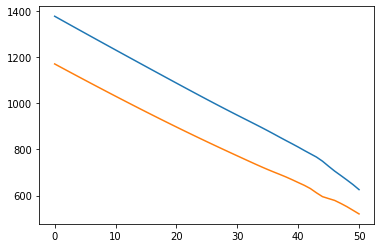

In [246]:
plt.plot(- (vjp_list[2][:,-1] - vjp_list[1][:,-1])/(ℓ_list[1]*0.01) )
plt.plot(- (vjp_list[4][:,-1] - vjp_list[3][:,-1])/(ℓ_list[3]*0.01) )

In [247]:
def compute_res_ems(vjp_list, emsjp_list, ℓ_list):
    num_ell_total, numy_cap, num_b = vjp_list.shape
    num_ell = int(num_ell_total/2)
    res_grid = np.zeros((num_ell, numy_cap))
    ℓ_list_new = np.zeros(num_ell)
    ems_list_new = np.zeros((num_ell, numy_cap))
    for i in range(num_ell):
        res_grid[i] =  -(vjp_list[2*i+1][:,-1] - vjp_list[2*i][:,-1])/(ℓ_list[i*2]*0.01) 
        ℓ_list_new[i] = (ℓ_list[2*i +1] + ℓ_list[2*i])/2
        ems_list_new[i] = (emsjp_list[2*i +1][:,-1] + emsjp_list[2*i][:,-1])/2
    return res_grid, ℓ_list_new, ems_list_new

In [248]:
res_grid, ℓ_list_new, ems_list_new = compute_res_ems(vjp_list[1:], emsjp_list[1:], ℓ_list[1:])

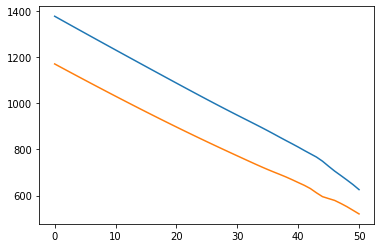

In [249]:
# res_grid.shape
plt.plot(res_grid.T)
plt.show()

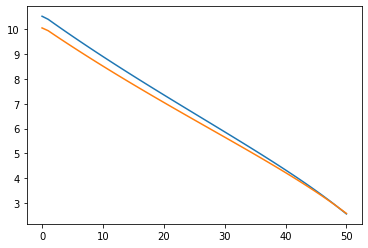

In [250]:
plt.plot(ems_list_new.T)

In [251]:
emsjp_list[0].shape

(51, 50)

In [252]:
from scipy import interpolate
def simulate_res_ems(y_grid_cap, res_grid, ems_list_new, T=100, dt=1):
    periods = int(T/dt)
    num_ell = len(ems_list_new)
    yt = np.zeros((num_ell,periods))
    rt = np.zeros((num_ell,periods))
    ems_t = np.zeros((num_ell,periods))
    ems_func = interpolate.interp1d(y_grid_cap, ems_list_new, )
    res_func = interpolate.interp1d(y_grid_cap, res_grid, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y= np.ones(num_ell)
    for t in range(periods):
        if y.any() > np.max(y_grid_cap):
            break
        ems_point = ems_func(y).diagonal()
        res_point = res_func(y).diagonal()
#         π_list = f_π(y2, y1)
        ems_t[:,t] = ems_point
        rt[:, t] = res_point
        yt[:, t] = y
        y += ems_point*np.mean(θ_list)*dt
    return yt, ems_t, rt

def simulate_ems(y_grid_cap, ems, T=100, dt=1):
    periods = int(T/dt)
    yt = np.zeros(periods)
    ems_t = np.zeros(periods)
    ems_func = interpolate.interp1d(y_grid_cap, ems )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y= 1
    for t in range(periods):
        if y > np.max(y_grid_cap):
            break
        ems_point = ems_func(y)
        ems_t[t] = ems_point
        yt[t] = y
        y += ems_point*np.mean(θ_list)*dt
    return yt, ems_t

In [253]:
yt_null, ems_t_null = simulate_ems(y_grid[:numy_bar+1], emsjp_list[0][:,-1])
yt, ems_t, rt = simulate_res_ems(y_grid[:numy_bar+1], res_grid, ems_list_new, T=100, dt=1)

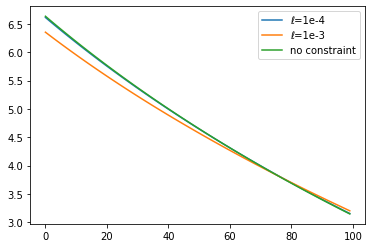

In [256]:
plt.plot(ems_t.T)
plt.plot(ems_t_null)
plt.legend(["ℓ=1e-4", "ℓ=1e-3","no constraint"])

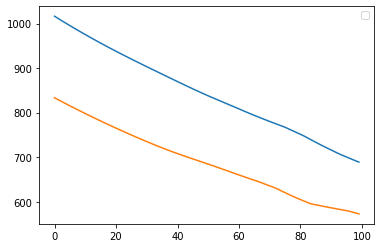

In [257]:
plt.plot(rt.T)
plt.legend([""])

In [260]:
σy, 1.2*1.86/1000, γ1

(0.002234339333333333, 0.002232, 0.00017675)

In [266]:
σy/np.sqrt(100)

0.0002234339333333333

In [267]:
1.2*np.mean(θ_list)

0.002234339333333333

In [268]:
σy/5

0.0004468678666666666